# Creating the models

In [1]:
import networkx as nx
from torch_geometric.utils.convert import to_networkx
from torch_geometric.data import Dataset, InMemoryDataset, DataLoader, Data
from torch_geometric.transforms import NormalizeFeatures, Compose, TargetIndegree
from torch_geometric.nn import GENConv, DeepGCNLayer
import torch_geometric.nn as gnn
from tqdm import tqdm
import torch
import numpy as np
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.cm as cm
from matplotlib import pyplot as plt
import matplotlib as mpl
import seaborn as sns
from IPython.display import display
import torch.nn as nn
from torch.nn import Linear, LayerNorm, ReLU
import torch.nn.functional as F
import os.path as osp
import os
from IPython import display
import time
import re
# For debugging memory leaks:
import gc

# fix random generator seed (for reproducibility of results)
np.random.seed(42)

# matplotlib options
sns.set(color_codes=True)
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (9, 6)
#mpl.rcParams['agg.path.chunksize'] = 10000

Loading data

In [2]:
path = "./content/"

def reverse_cyclical_encoding(value, max_t):
    orig_t_sin = max_val*np.arcsin(value)/(2*np.pi)
    orig_t_cos = max_val*np.arccos(value)/(2*np.pi)
    return orig_t_sin, orig_t_cos

df_season_mappings = pd.read_csv(path+"mappings_season_id.csv")
df_zone_mappings = pd.read_csv(path+"mappings_zone_id.csv")
val_nodes = torch.load(path+"val_nodes.pt")
test_nodes = torch.load(path+"test_nodes.pt")
df_processed = pd.read_csv(path+"drivenow_processed.csv")
df_processed.time_until_pickup = pd.to_timedelta(df_processed.time_until_pickup)
df_processed["start_parking"] = pd.to_datetime(df_processed["start_parking"], format="%Y-%m-%d %H:%M:%S")
df_processed["end_parking"] = pd.to_datetime(df_processed["end_parking"], format="%Y-%m-%d %H:%M:%S")

# Creating PyTorch Geometric dataloader

We now have the raw graphs as such it is possible to define the datasets using the PyTorch Geometric toolbox. The InMemoryDataset is used as it is possible to store the sparse data in CPU memory by using the Collate function. A benefit of in-memory datasets is that they do not get any overhead from loading objects.

In [3]:
in_memory = True
if in_memory:
    class DriveNowDataset(InMemoryDataset):
        def __init__(self, root, transform=None, pre_transform=None):
            super(DriveNowDataset, self).__init__(root, transform, pre_transform)
            self.data, self.slices = torch.load(self.processed_paths[0])

        def atoi(self, text):
          return int(text) if text.isdigit() else text

        def natural_keys(self, text):
          return [ self.atoi(c) for c in re.split(r'(\d+)', text) ]

        @property
        def raw_file_names(self):
          path_to_raw = os.listdir(self.root+"/raw")
          path_to_raw.sort(key=self.natural_keys)
          return path_to_raw

        @property
        def processed_file_names(self):
            return ['data.pt']

        def download(self):
            pass

        def process(self):
            # Read data into huge `Data` list.
          data_list = []

          for raw_path in self.raw_paths:
            data = torch.load(raw_path)
            data = data if self.pre_filter is None else self.pre_filter(data)
            data = data if self.pre_transform is None else self.pre_transform(data)
            data_list.append(data)

          data, slices = self.collate(data_list)
          torch.save((data, slices), self.processed_paths[0])
else:
    class DriveNowDataset(Dataset):
      "WARNING: This method is very slow due to overhead"
      def __init__(self, root, pre_filter=None, pre_transform=None):
          super(DriveNowDataset, self).__init__(root, pre_filter, pre_transform)

      def atoi(self, text):
        return int(text) if text.isdigit() else text

      def natural_keys(self, text):
        return [ self.atoi(c) for c in re.split(r'(\d+)', text) ]

      @property
      def raw_file_names(self):
        path_to_raw = os.listdir(self.root+"/raw")
        path_to_raw.sort(key=self.natural_keys)
        return path_to_raw

      @property
      def processed_file_names(self):
        names = []
        for i in range(len(self.raw_paths)):
          names.append('data_{}.pt'.format(i))
        names.sort(key=self.natural_keys)
        return names

      def download(self):
        pass

      def process(self):
          i = 0
          for raw_path in self.raw_paths:

            data = torch.load(raw_path)
            data = data if self.pre_filter is None else self.pre_filter(data)
            data = data if self.pre_transform is None else self.pre_transform(data)
            torch.save(data, osp.join(self.processed_dir, 'data_{}.pt'.format(i)))
            i += 1

      def len(self):
        return len(self.processed_file_names)

      def get(self, idx):
        data = torch.load(osp.join(self.processed_dir, 'data_{}.pt'.format(idx)))
        return data


Different transformations of the graph is also added.

In [4]:

class AddNoise(object):
    """Add noise to targets."""
    def __init__(self, r1, r2):
        self.r1 = r1
        self.r2 = r2

    def __call__(self, data):
        noise = (self.r1 - self.r2) * torch.rand(data.y.shape) + self.r2
        use = (data.mask == 1)&(data.mask!=0)
        data.y = data.y + noise
        return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

class transform_target(object):
    """Add a transformation to target."""
    def __init__(self, transformation):
      self.transformation = transformation

    def __call__(self, data):
      data.y = self.transformation(data.y)
      return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

class standardize(object):
    """Standardize data."""
    def __init__(self, train_mean_y, train_std_y, train_mean_x, train_std_x, features = "target"):
      self.train_mean_y = train_mean_y
      self.train_std_y = train_std_y
      self.train_mean_x = train_mean_x
      self.train_std_x = train_std_x
      self.features = features

    def __call__(self, data):
      if self.features != "target":
        x= (data.x - self.train_mean_x) / self.train_std_x
        data.x = x
      elif self.features == "both":
        x= (data.x - self.train_mean_x) / self.train_std_x
        data.x = x
        y= (data.y - self.train_mean_y)/ self.train_std_y
        data.y = y
      else:
        y= (data.y - self.train_mean_y)/ self.train_std_y
        data.y = y
      return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)

    
from torch_geometric.utils import degree
class AddDegree(object):
    """Add the degree of the nodes to the features or to the edge features."""
    def __init__(self, max_degree = None, in_degree=True, one_hot_enable=False, norm=False):
      self.in_degree = in_degree
      self.one_hot_enable = one_hot_enable 
      self.norm = norm
      self.max_degree = max_degree

    def __call__(self, data):
      idx, x = data.edge_index[1 if self.in_degree else 0], data.x
      deg = degree(idx, data.num_nodes, dtype=torch.long)
      if self.one_hot_enable:
        deg = F.one_hot(deg, num_classes=self.max_degree + 1).to(torch.float)
      else:

        deg=deg.view(-1, 1)

      if self.norm:
        deg = deg / deg.max()
      
      if x is not None:
        if x.dim() == 1:
          x = x.view(-1, 1)

        data.x = torch.cat([x, deg.to(x.dtype)], dim=-1)
      
      else:
        data.x = deg
      return data

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
def inverse_logit(x):
  y = 1.0 / (1.0 + np.exp(-x))
  return y

Loading and processing the dataset. The data is standardized. The target is log-transformed as it gave a more stable training.

In [5]:
# Mask values:
# 1 = training
# 2 = validation
# 3 = test

# Log transforming target
transform_target_fun = np.log

def online_mean_and_sd(loader, n_features, target_bool):
    """
    Approximate the mean and sd in an online fashion as concatenating all the graphs can't always be in memory
    Var[x] = E[X^2] - E^2[X]
    For simplicity we also calculate E[X] in an online fashion.
    """
    cnt = 0
    fst_moment = torch.empty(n_features)
    snd_moment = torch.empty(n_features)

    for data in loader:
        use = (data.mask==1)&(data.mask != 0)
        if target_bool:
            x = transform_target_fun(data.y[use])
        else:
            x = data.x[use]
        
        nb = x.shape[0]
        sum_ = x.sum(0)
        sum_of_square = (x ** 2).sum(0)
        fst_moment = (cnt * fst_moment + sum_) / (cnt + nb)
        snd_moment = (cnt * snd_moment + sum_of_square) / (cnt + nb)
        cnt += nb
    return fst_moment, torch.sqrt(snd_moment - fst_moment ** 2)

# Removing the old processed folder
!rm -rf ./content/processed
standardize_graph=True
if standardize_graph:
    """ Standardize based on the graph nodes """
    dataset=DriveNowDataset(path, pre_transform=None)
    data_loader = DataLoader(dataset, batch_size=1, shuffle=False, num_workers=0, drop_last = False)
    train_mean_x, train_std_x = online_mean_and_sd(data_loader, dataset[0].x.shape[-1], target_bool = False)
    train_mean_y, train_std_y = online_mean_and_sd(data_loader, 1, target_bool = True)
else:
    """ Standardize based on the processed data frame """
    df_processed.loc[:,"time_until_pickup_minutes"]=transform_target_fun(df_processed["time_until_pickup"].dt.total_seconds()/60)
    train_pickup_time = df_processed[~df_processed["carid"].isin(np.concatenate([val_nodes, test_nodes]))]["time_until_pickup_minutes"].copy()
    df_temp = df_processed[~df_processed["carid"].isin(np.concatenate([val_nodes, test_nodes]))].iloc[:,5:26].drop(["time_until_pickup","battery_charging"], 1).copy()
    train_mean_x = df_temp.mean().values.astype('float32')
    train_std_x = (df_temp.std().values+ 1e-8).astype('float32')
    train_mean_y = train_pickup_time.mean().astype('float32')
    train_std_y = train_pickup_time.std().astype('float32')

Processing...
Done!


Setting up the data

In [6]:
transforms = Compose([
    #AddDegree(),
    transform_target(transformation=transform_target_fun),
    standardize(train_mean_y, train_std_y, train_mean_x, train_std_x, features = "both"),
    #AddNoise(),
    #TargetIndegree(),
    #NormalizeFeatures(),
    ])

!rm -rf ./content/processed
transform=transforms
dataset=DriveNowDataset(path, pre_transform=transforms)

batch_size= 150
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=0, drop_last = True)

Processing...
Done!


Visualising and looking at statistic of the data

In [7]:
print()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')

data = dataset[0]
print()
print(data)
print('===========================================================================================================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {(data.mask==1).sum()}')
print(f'Training node label rate: {int((data.mask==1).sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

use = (data.mask==1)*(data.mask != 0)
data.x=data.x[use]
data.y = data.y[use]


Dataset: DriveNowDataset(6677):
Number of graphs: 6677
Number of features: 12

Data(edge_attr=[2436, 1], edge_index=[2, 2436], mask=[255], x=[255, 12], y=[255])
Number of nodes: 255
Number of edges: 2436
Average node degree: 9.55
Number of training nodes: 208
Training node label rate: 0.82
Contains isolated nodes: True
Contains self-loops: False
Is undirected: True


We notice that the number of training nodes is quite lower than the expected training nodes as we are supposed to use $346-60=286$ training nodes. We also see that the nodes are well connected to each other on average there is approx. 9 edges connected to a node. We could adjust the node degree by reducing or increasing the minimum distance. Looking at the log of the target below, even though it looks shuffled patterns can be observed.

<AxesSubplot:title={'center':'targets'}, xlabel='index', ylabel='y0'>

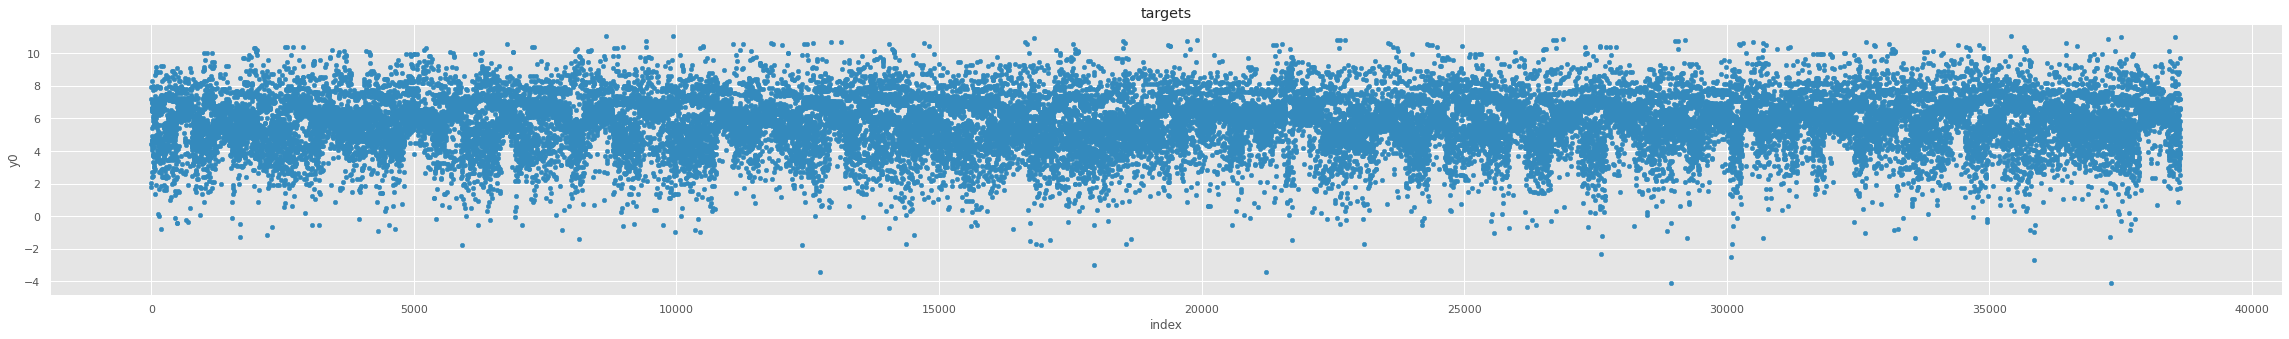

In [8]:
data = next(iter(data_loader))
use = (data.mask==1)&(data.mask != 0)
test = pd.DataFrame(data.y[use].detach().cpu().numpy())
test.reset_index(inplace=True)
test.columns = ["index", "y0"]
test.plot.scatter(x="index", y="y0", title="targets", figsize=(40, 5))

We can also visualize a graph using the NetworkX package. Nodes closer to each other will be clustered and that is why we see small graphs disconnected from the larger graph.

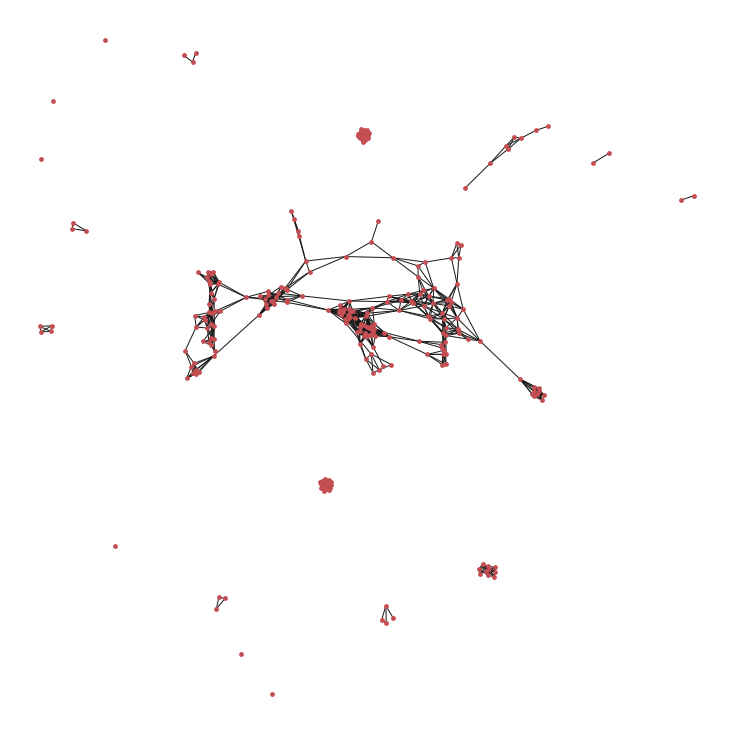

In [9]:
data = dataset[0]
datagraph = to_networkx(data, to_undirected=True)

plt.figure(1,figsize=(10,10)) 
nx.draw(datagraph, node_color = "r", node_size=8, linewidths=2, cmap="Set2", pos=nx.spring_layout(datagraph, seed=40))
plt.show()

# Creating the model

We are now ready to create a model. Graph neural networks generalize the convolution operator to irregular domains. It works by a node sends messages by its connected edge to its neighbours. Next the nodes collect the messages they receive and uses the information to update themselves through backpropagation. This can be expressed by a message passing scheme. Let $x_i^{k-1}$ denote node features of node $i$ in layer $k-1$ and $\mathbf{e}_{j,i}$ denotes then an edge feature from node $j$ to node $i$. The message passing scheme can then be expressed as:
$$\mathbf{x}_{i}^{(k)}=\gamma^{(k)}\left(\mathbf{x}_{i}^{(k-1)}, \nabla_{j \in \mathcal{N}(i)} \phi^{(k)}\left(\mathbf{x}_{i}^{(k-1)}, \mathbf{x}_{j}^{(k-1)}, \mathbf{e}_{j, i}\right)\right),$$
with $\nabla$ denoting a differentiable permutation invariant function acting as an aggregation operator, such as a mean, sum or max operator. The aggregation operator $\nabla$ makes sure that the representation is the same size independent of neighbouring nodes and it also causes a node to be represented by its neighbouring nodes. $\gamma$ and $\phi$ are multi-layer perceptrons where they represent a message estimator and an update estimator, respectively. 

PyTorch Geometric is a toolbox based on the deep learning framework PyTorch, which allow us to easily create deep neural networks using graph neural networks, such as Graph Convolutional Networks (GCNs). The GCN is mathematically defined as
$$\mathbf{x}_{i}^{(k)}=\sum_{j \in \mathcal{N}(i) \cup\{i\}} \frac{1}{\sqrt{\operatorname{deg}(i)} \cdot \sqrt{\operatorname{deg}(j)}} \cdot\left(\mathbf{\Theta} \cdot \mathbf{x}_{j}^{(k-1)}\right),$$
where neighboring node features are first transformed by a weight matrix $\Theta$, and normalized by $\frac{1}{\sqrt{\operatorname{deg}(i)}\cdot \sqrt{\operatorname{deg}(j)}}$, given by the degree of the adjacency matrix, and then summed up. In PyTorch Geometric they divide the formula into a few steps:

1. Add self-loops to the adjacency matrix.
2. Linearly transform node feature matrix.
3. Compute normalization coefficients.
4. Normalize node features in $\phi$.
5. Sum up neighboring node features

Notice that self-loops are added, which means each node has an edge to itself. Besides the theoretical justification of self-loops shown in Kipf et al. (https://arxiv.org/abs/1609.02907), the implication of this is when doing the neighbourhood aggregation of messages the nodes own value is included to the aggregation. There are several different graph neural networks which are doing modifications and expands the concept of message parsing. 

To model the problem we need to consider the data. First let us consider the GCN layers; each GCN layer forward propagates to the neighbouring node, this mean the more GCN layers we connect the further in the graph we travel and receive information when propagating forward. We might assume that since a node and all its nodes within the minimum distance will get connected, we are not very interested in the information propagating far in the graph a few GCNs should therefore do the job of taking into account information from the vicinity of other cars. During a number of iterations the information from a node will propagate throughout the graph like when a rain drop hits a water surface and creates ripples.

We also need to take care of the output layer. Here we try to predict time. This is fairly simple, we take the log of the target, where the target is time. No output activation function is therefore required.

Finally, one can experiment with different regularization methods to avoid problems such as overfitting and vanishing/exploding gradients. In this notebook the following methods were experimented with; dropout, batch normalization, layer normalization, different activation functions, weight constraining, weight decaying and gradient clipping. One should evaluate these settings using some kind of validation method such as cross-validation, but this has not been done here, due to time constraints.

Below a simple GCN model can be seen with a downscaling structure. The structure of a DeepGCN model resembling a traditional ResNet model from Li et al. https://arxiv.org/abs/2006.07739 was also experimented with and can be found later in the notebook.

The criterion is chosen based on the data as well. As we had quite a lot of outliers, one could argue it would be wise to choose a L1 loss, but the outliers are not corrupt data, but anomalies. We actually want to be good at detecting the outliers, as they are often cars with long waiting times before they are picked up. Because of this we use the L2 loss.

In [10]:
data = dataset[0]
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        # For reproducing results
        torch.manual_seed(12345)
        
        self.conv1 = gnn.GCNConv(data.x.size(-1), 256)
        self.norm1 = nn.LayerNorm(256, elementwise_affine=True)
        self.conv2 = gnn.GCNConv(256, 128)
        self.norm2 = nn.LayerNorm(128, elementwise_affine=True)
        self.conv3 = gnn.GCNConv(128, 128)
        self.norm3 = nn.LayerNorm(128, elementwise_affine=True)
        self.out = gnn.GCNConv(128, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr.view(-1), data.batch

        x = self.conv1(x, edge_index, edge_attr)
        x = self.norm1(x)
        x = x.relu()

        x = self.conv2(x, edge_index, edge_attr)
        x = self.norm2(x)
        x = x.relu()

        x = self.conv3(x, edge_index, edge_attr)
        x = self.norm3(x)
        x = x.relu()

        x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x, edge_index, edge_attr)
        
        return x.view(-1)

The utility functions, losses and training functions are all implemented and can be seen below.

In [11]:
device = torch.device("cuda")

class EarlyStopping():
  def __init__(self, min_delta=0, patience=500, verbose=True):
    super(EarlyStopping, self).__init__()
    self.min_delta = min_delta
    self.patience = patience
    self.wait = 1
    self.best_loss = 1e15
    self.verbose = verbose
    self.model_name = "model_1"

  def checkpoint(self, model):
    # saves the model
    torch.save({
        'model_state_dict': model.state_dict(),
        }, path + self.model_name )

  def step(self, epoch, loss, model):
    # Checks for best loss and if converged
    current_loss = loss
    if current_loss is None:
      pass
    else:
      if (current_loss - self.best_loss) < -self.min_delta:
        self.best_loss = current_loss
        if self.wait == 1:
          self.checkpoint(model)
        self.wait = 1
      else:
        if self.wait >= self.patience:
          stop_training = True
          if self.verbose:
            print("Stopped - Criterion met at epoch {}".format(epoch))
          return stop_training
        self.wait += 1

def adjust_learning_rate(batch):
    # we manually and linearly adjust the learning rate.
    startbatch = (len(dataset)//batch_size) * 300
    num_steps = (len(dataset)//batch_size)*1000
    if batch > startbatch: 
        lr = learning_rate - (batch-startbatch)*(learning_rate)/num_steps
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

    if batch == (startbatch + num_steps - 10):
        stop = True
        return stop

#Error measures
def mse(target, pred):
  score = ((target-pred)**2).mean()
  return score

def mae(target, pred):
  score = (abs(target-pred)).mean()
  return score

def rmse(target, pred):
  score = ((target-pred)**2).mean()
  return torch.sqrt(score)


def plotter(target, pred):
  tars = pd.DataFrame(target.detach().cpu().numpy())
  preds = pd.DataFrame(pred.detach().cpu().numpy())
  residuals = tars - preds
  x = np.arange(0,len(pred))
  fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(25,5))
  tars.plot.scatter(x=tars.index, y="0", ax=axes[0], title="targets")
  preds.plot.scatter(x=tars.index, y="0",ax=axes[1], title="preds")
  residuals.plot.scatter(x=tars.index,ax=axes[2], title="residuals")

criterion = torch.nn.MSELoss()
# Training functions
def train(data, batch_i, model):
      model.train()
      optimizer.zero_grad() 
      out = model(data) 
      # Use training mask without empty nodes
      train_mask = (data.mask==1)*(data.mask != 0)
      loss = criterion(out[train_mask], data.y[train_mask]) 
      loss.backward() 
      # (hack) We had a few high gradients, we clip them
      torch.nn.utils.clip_grad_value_(model.parameters(), 2)
      torch.nn.utils.clip_grad_norm_(model.parameters(), 4, norm_type=2.0)
      # Debug gradients
      if (batch_i % 10 == 0) and debug:
        plot_grad_flow(model.named_parameters())
        plt.show()
      optimizer.step()  
      return loss

def validate(data, model, plot_residuals = False):
      model.eval()
      with torch.no_grad():
        out = model(data)
        # Use validation mask without empty nodes
        valid_mask = (data.mask==2)*(data.mask != 0)
        mse_score = mse(out[valid_mask], data.y[valid_mask])
        if plot_residuals:
          plotter(data.y[valid_mask],out[valid_mask])
          plt.show()
      return mse_score

def test(data, model):
      model.eval()
      with torch.no_grad():
        out = model(data)
      return out

Initialising the model and training.

In [12]:
debug = False
model_gcn = GCN().to(device)
earlystopping = EarlyStopping(min_delta = 0, patience = 150, verbose = True)
earlystopping.model_name = "gcn_model.pt"
learning_rate = 0.01
optimizer = torch.optim.Adam(model_gcn.parameters(), lr=learning_rate)
train_loss = []
val_loss = []
pbar = tqdm(total=len(dataset)//batch_size, desc='Batch', leave=True, position=0)
n_epoch = 10000
counter = 0


Batch:   0%|          | 0/44 [00:00<?, ?it/s]

In [13]:
for epoch_i in range(n_epoch):
  losses = []
  val_losses = []
  for batch_i, data in enumerate(data_loader):
    data=data.to(device)
    loss = train(data, batch_i, model_gcn)
    pbar.update()
    counter += 1
    stop = adjust_learning_rate(counter)
    losses.append(loss.detach())
  mean_train = torch.tensor(losses, dtype=float).mean()
  if epoch_i % 1 == 0: 
    for _, data_val in enumerate(data_loader):
      data_val=data_val.to(device)
      mse_score = validate(data_val, model_gcn)
      val_losses.append(mse_score.detach())
      
    mean_val = torch.tensor(val_losses, dtype=float).mean()
    print("Epoch: {}, Train Loss: {}, Validation Loss: {}".format(epoch_i, mean_train, mean_val))
    stop = earlystopping.step(epoch_i, mean_val, model_gcn)
  else:
    print("Epoch: {}, Train Loss: {}".format(epoch_i, mean_train))
  if debug:
    # Debug memory leaks
    for obj in gc.get_objects():
      try:
          if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
              print(type(obj), obj.size())
      except:
          pass
  if stop:
    break
  train_loss.append(mean_train)
  val_loss.append(val_losses)
  pbar.reset(len(dataset)//batch_size)
pbar.close()

#model_gcn.load_state_dict(torch.load(path+"gcn_model.pt")['model_state_dict'])

Batch:   5%|▍         | 2/44 [00:00<00:02, 17.17it/s] 

Epoch: 0, Train Loss: 3.927161059596322, Validation Loss: 2.7443991736932234


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.90it/s] 

Epoch: 1, Train Loss: 2.7459677132693203, Validation Loss: 2.6727272922342475


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.34it/s] 

Epoch: 2, Train Loss: 2.6882508342916314, Validation Loss: 2.6353799971667202


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.13it/s] 

Epoch: 3, Train Loss: 2.637130227955905, Validation Loss: 2.5781930793415415


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.43it/s] 

Epoch: 4, Train Loss: 2.5931249423460527, Validation Loss: 2.5461148619651794


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.63it/s] 

Epoch: 5, Train Loss: 2.548904164270921, Validation Loss: 2.5028237158601936


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.26it/s] 

Epoch: 6, Train Loss: 2.507922362197529, Validation Loss: 2.4659049185839566


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.64it/s] 

Epoch: 7, Train Loss: 2.4753876707770606, Validation Loss: 2.4361571669578552


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.19it/s] 

Epoch: 8, Train Loss: 2.4421152689240198, Validation Loss: 2.409783748063174


Batch:   5%|▍         | 2/44 [00:00<00:02, 17.50it/s] 

Epoch: 9, Train Loss: 2.4113350835713474, Validation Loss: 2.390128054402091


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.28it/s] 

Epoch: 10, Train Loss: 2.3865012418140066, Validation Loss: 2.3760604099793867


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.90it/s] 

Epoch: 11, Train Loss: 2.366054133935408, Validation Loss: 2.334470580924641


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.22it/s] 

Epoch: 12, Train Loss: 2.3420354344628076, Validation Loss: 2.3156839175657793


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.73it/s] 

Epoch: 13, Train Loss: 2.3224569504911248, Validation Loss: 2.2967108975757253


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.80it/s] 

Epoch: 14, Train Loss: 2.309541019526395, Validation Loss: 2.2856286980889062


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.85it/s] 

Epoch: 15, Train Loss: 2.2914240089329807, Validation Loss: 2.2776495814323425


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.93it/s] 

Epoch: 16, Train Loss: 2.279167272827842, Validation Loss: 2.259172331203114


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.30it/s] 

Epoch: 17, Train Loss: 2.266597558151592, Validation Loss: 2.25332892482931


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.93it/s] 

Epoch: 18, Train Loss: 2.256122962995009, Validation Loss: 2.247572524981065


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.39it/s] 

Epoch: 19, Train Loss: 2.2486037611961365, Validation Loss: 2.2337803190404717


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.97it/s] 

Epoch: 20, Train Loss: 2.2404491142793135, Validation Loss: 2.231650325385007


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.82it/s] 

Epoch: 21, Train Loss: 2.240443782372908, Validation Loss: 2.223651257428256


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.86it/s] 

Epoch: 22, Train Loss: 2.2311914508992974, Validation Loss: 2.223162602294575


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.95it/s] 

Epoch: 23, Train Loss: 2.222255278717388, Validation Loss: 2.2216355204582214


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.30it/s] 

Epoch: 24, Train Loss: 2.219508880918676, Validation Loss: 2.208592428402467


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.56it/s] 

Epoch: 25, Train Loss: 2.2133867252956736, Validation Loss: 2.2039190639149058


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.91it/s] 

Epoch: 26, Train Loss: 2.2127157829024573, Validation Loss: 2.203607824715701


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.31it/s] 

Epoch: 27, Train Loss: 2.2113943587649953, Validation Loss: 2.200034808028828


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.93it/s] 

Epoch: 28, Train Loss: 2.2055208628827874, Validation Loss: 2.1982129866426643


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.84it/s] 

Epoch: 29, Train Loss: 2.205091888254339, Validation Loss: 2.1999722773378547


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.85it/s] 

Epoch: 30, Train Loss: 2.203382058577104, Validation Loss: 2.194831845435229


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.92it/s] 

Epoch: 31, Train Loss: 2.2015518979592756, Validation Loss: 2.196356025609103


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.55it/s] 

Epoch: 32, Train Loss: 2.1986391327597876, Validation Loss: 2.2014415074478495


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.78it/s] 

Epoch: 33, Train Loss: 2.1962510726668616, Validation Loss: 2.191085782918063


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.36it/s] 

Epoch: 34, Train Loss: 2.193835513158278, Validation Loss: 2.1935446804220025


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.69it/s] 

Epoch: 35, Train Loss: 2.1975970322435554, Validation Loss: 2.1912749490954657


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.40it/s] 

Epoch: 36, Train Loss: 2.1947255676442925, Validation Loss: 2.1945436921986667


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.60it/s] 

Epoch: 37, Train Loss: 2.192619675939733, Validation Loss: 2.1902698170055044


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 38, Train Loss: 2.193208558992906, Validation Loss: 2.1865938739343123


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.06it/s] 

Epoch: 39, Train Loss: 2.1923988298936323, Validation Loss: 2.1908209323883057


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.64it/s] 

Epoch: 40, Train Loss: 2.1925569610162214, Validation Loss: 2.1924013061956926


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.37it/s] 

Epoch: 41, Train Loss: 2.1917894970286977, Validation Loss: 2.187904712828723


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.56it/s] 

Epoch: 42, Train Loss: 2.188894125548276, Validation Loss: 2.186967581510544


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.97it/s] 

Epoch: 43, Train Loss: 2.1908891038461165, Validation Loss: 2.1878445581956343


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 44, Train Loss: 2.186914796178991, Validation Loss: 2.1868663105097683


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.42it/s] 

Epoch: 45, Train Loss: 2.18994615836577, Validation Loss: 2.186067443002354


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.44it/s] 

Epoch: 46, Train Loss: 2.1899724115024912, Validation Loss: 2.1891568221829156


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.43it/s] 

Epoch: 47, Train Loss: 2.189005635001443, Validation Loss: 2.1880368807099084


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.40it/s] 

Epoch: 48, Train Loss: 2.1899966272440823, Validation Loss: 2.187184062871066


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.78it/s] 

Epoch: 49, Train Loss: 2.1863327568227593, Validation Loss: 2.1855965852737427


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.81it/s] 

Epoch: 50, Train Loss: 2.1869377277114173, Validation Loss: 2.191297373988412


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.06it/s] 

Epoch: 51, Train Loss: 2.1893056251785974, Validation Loss: 2.1912959543141453


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.27it/s] 

Epoch: 52, Train Loss: 2.1888914677229794, Validation Loss: 2.192645425146276


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.97it/s] 

Epoch: 53, Train Loss: 2.1909612850709395, Validation Loss: 2.1876642162149604


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.93it/s] 

Epoch: 54, Train Loss: 2.1845820871266453, Validation Loss: 2.1874784502116116


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.45it/s] 

Epoch: 55, Train Loss: 2.1881151470271023, Validation Loss: 2.18600673567165


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.65it/s] 

Epoch: 56, Train Loss: 2.1892394477670845, Validation Loss: 2.1948651779781687


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.43it/s] 

Epoch: 57, Train Loss: 2.184575758197091, Validation Loss: 2.1843101273883474


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 58, Train Loss: 2.184540233828805, Validation Loss: 2.185739040374756


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.36it/s] 

Epoch: 59, Train Loss: 2.184585387056524, Validation Loss: 2.1876786703413185


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.03it/s] 

Epoch: 60, Train Loss: 2.186421670696952, Validation Loss: 2.1818885667757555


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.10it/s] 

Epoch: 61, Train Loss: 2.1824176148934797, Validation Loss: 2.184436659921299


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 62, Train Loss: 2.1851356354626743, Validation Loss: 2.184154440056194


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.50it/s] 

Epoch: 63, Train Loss: 2.1833827712319116, Validation Loss: 2.1822127537293867


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.13it/s] 

Epoch: 64, Train Loss: 2.1831614537672563, Validation Loss: 2.181619015606967


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.06it/s] 

Epoch: 65, Train Loss: 2.182461001656272, Validation Loss: 2.1828173615715722


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.06it/s] 

Epoch: 66, Train Loss: 2.1839945939454166, Validation Loss: 2.180281414227052


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 67, Train Loss: 2.1818143400278958, Validation Loss: 2.180989910255779


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 68, Train Loss: 2.179778524420478, Validation Loss: 2.1842195933515374


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.97it/s] 

Epoch: 69, Train Loss: 2.1781291528181597, Validation Loss: 2.1870379989797417


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.36it/s] 

Epoch: 70, Train Loss: 2.181617948141965, Validation Loss: 2.185211040756919


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.26it/s] 

Epoch: 71, Train Loss: 2.1792516220699656, Validation Loss: 2.182618187232451


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 72, Train Loss: 2.181488719853488, Validation Loss: 2.1840022666887804


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.13it/s] 

Epoch: 73, Train Loss: 2.180097084153782, Validation Loss: 2.1829789037054237


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 74, Train Loss: 2.178813034837896, Validation Loss: 2.182588891549544


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.14it/s] 

Epoch: 75, Train Loss: 2.1774656014008955, Validation Loss: 2.181071839549325


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.65it/s] 

Epoch: 76, Train Loss: 2.1760022206739946, Validation Loss: 2.181374593214555


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.03it/s] 

Epoch: 77, Train Loss: 2.178969692100178, Validation Loss: 2.1854348968375814


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.28it/s] 

Epoch: 78, Train Loss: 2.1797885569659146, Validation Loss: 2.181338526985862


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.39it/s] 

Epoch: 79, Train Loss: 2.177010351961309, Validation Loss: 2.1768212480978533


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.49it/s] 

Epoch: 80, Train Loss: 2.174496677788821, Validation Loss: 2.178555737842213


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.95it/s] 

Epoch: 81, Train Loss: 2.1766652410680596, Validation Loss: 2.1825348274274305


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.88it/s] 

Epoch: 82, Train Loss: 2.176529190757058, Validation Loss: 2.178203271193938


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.86it/s] 

Epoch: 83, Train Loss: 2.179103531620719, Validation Loss: 2.1778646924278955


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.84it/s] 

Epoch: 84, Train Loss: 2.173113690181212, Validation Loss: 2.1760834130373867


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 85, Train Loss: 2.1745180162516506, Validation Loss: 2.1778667271137238


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 86, Train Loss: 2.1763886430046777, Validation Loss: 2.1816024346785112


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 87, Train Loss: 2.173223701390353, Validation Loss: 2.1786648360165684


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.15it/s] 

Epoch: 88, Train Loss: 2.174538325179707, Validation Loss: 2.1814315617084503


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.96it/s] 

Epoch: 89, Train Loss: 2.1753006794235925, Validation Loss: 2.1763471364974976


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 90, Train Loss: 2.1743948567997324, Validation Loss: 2.1762313029982825


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.83it/s] 

Epoch: 91, Train Loss: 2.1738580898805098, Validation Loss: 2.1807608712803233


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 92, Train Loss: 2.174485369162126, Validation Loss: 2.175339322198521


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.00it/s] 

Epoch: 93, Train Loss: 2.1703852740201084, Validation Loss: 2.1760374416004526


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.18it/s] 

Epoch: 94, Train Loss: 2.1690944704142483, Validation Loss: 2.179808248173107


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 95, Train Loss: 2.1702968207272617, Validation Loss: 2.174089556390589


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.27it/s] 

Epoch: 96, Train Loss: 2.1703921881589023, Validation Loss: 2.179657616398551


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.26it/s] 

Epoch: 97, Train Loss: 2.169901506467299, Validation Loss: 2.1777895851568743


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.76it/s] 

Epoch: 98, Train Loss: 2.168669283390045, Validation Loss: 2.17660977081819


Batch:   7%|▋         | 3/44 [00:00<00:02, 18.77it/s] 

Epoch: 99, Train Loss: 2.169688558036631, Validation Loss: 2.1771740344437687


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.15it/s] 

Epoch: 100, Train Loss: 2.168766205961054, Validation Loss: 2.1749161427671257


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.70it/s] 

Epoch: 101, Train Loss: 2.1686068827455696, Validation Loss: 2.17680103670467


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.36it/s] 

Epoch: 102, Train Loss: 2.1662526347420434, Validation Loss: 2.17660145055164


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 103, Train Loss: 2.1678992076353594, Validation Loss: 2.1756109378554602


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.61it/s] 

Epoch: 104, Train Loss: 2.1663038351319055, Validation Loss: 2.177735783837058


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.34it/s] 

Epoch: 105, Train Loss: 2.166499441320246, Validation Loss: 2.1764355247670952


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 106, Train Loss: 2.1643531159921126, Validation Loss: 2.179616630077362


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.97it/s] 

Epoch: 107, Train Loss: 2.166264620694247, Validation Loss: 2.1751779209483755


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.61it/s] 

Epoch: 108, Train Loss: 2.1658987457101997, Validation Loss: 2.176476912064986


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.65it/s] 

Epoch: 109, Train Loss: 2.1656757484782827, Validation Loss: 2.1792348352345554


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.29it/s] 

Epoch: 110, Train Loss: 2.1661548045548527, Validation Loss: 2.1766165413639764


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.44it/s] 

Epoch: 111, Train Loss: 2.164275749163194, Validation Loss: 2.174492621963674


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.23it/s] 

Epoch: 112, Train Loss: 2.161220214583657, Validation Loss: 2.173666699366136


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.56it/s] 

Epoch: 113, Train Loss: 2.1645946990359914, Validation Loss: 2.173431521112269


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.05it/s] 

Epoch: 114, Train Loss: 2.1639374548738655, Validation Loss: 2.1693555116653442


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.68it/s] 

Epoch: 115, Train Loss: 2.1621768962253225, Validation Loss: 2.1755230155858127


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 116, Train Loss: 2.162766153162176, Validation Loss: 2.1721324812282217


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.84it/s] 

Epoch: 117, Train Loss: 2.158732858571139, Validation Loss: 2.172215510498394


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.10it/s] 

Epoch: 118, Train Loss: 2.1619379791346462, Validation Loss: 2.1707284911112352


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 119, Train Loss: 2.1593863422220405, Validation Loss: 2.1748136688362467


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.64it/s] 

Epoch: 120, Train Loss: 2.1604071963917124, Validation Loss: 2.168685872446407


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 121, Train Loss: 2.157450307499279, Validation Loss: 2.171122843568975


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.10it/s] 

Epoch: 122, Train Loss: 2.1593782630833713, Validation Loss: 2.1724460531364786


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.39it/s] 

Epoch: 123, Train Loss: 2.157618671655655, Validation Loss: 2.1723035763610494


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 124, Train Loss: 2.158015562729402, Validation Loss: 2.1761758490042253


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.07it/s] 

Epoch: 125, Train Loss: 2.156227946281433, Validation Loss: 2.1725748641924425


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.95it/s] 

Epoch: 126, Train Loss: 2.1588852297176016, Validation Loss: 2.177409134127877


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.01it/s] 

Epoch: 127, Train Loss: 2.1581815481185913, Validation Loss: 2.168143169446425


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.90it/s] 

Epoch: 128, Train Loss: 2.159266471862793, Validation Loss: 2.176670589230277


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.23it/s] 

Epoch: 129, Train Loss: 2.1543789966539904, Validation Loss: 2.172459000890905


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.15it/s] 

Epoch: 130, Train Loss: 2.157035020264712, Validation Loss: 2.172807747667486


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.08it/s] 

Epoch: 131, Train Loss: 2.156159693544561, Validation Loss: 2.1709415072744545


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.58it/s] 

Epoch: 132, Train Loss: 2.1570736359466207, Validation Loss: 2.1703922260891306


Batch:   5%|▍         | 2/44 [00:00<00:02, 17.88it/s] 

Epoch: 133, Train Loss: 2.15422167561271, Validation Loss: 2.16619488325986


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.55it/s] 

Epoch: 134, Train Loss: 2.1567738868973474, Validation Loss: 2.171235379847613


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.92it/s] 

Epoch: 135, Train Loss: 2.153514163060622, Validation Loss: 2.168762307275425


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.53it/s] 

Epoch: 136, Train Loss: 2.153778623450886, Validation Loss: 2.170249253511429


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 137, Train Loss: 2.153633540326899, Validation Loss: 2.1767588176510553


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.66it/s] 

Epoch: 138, Train Loss: 2.154270513491197, Validation Loss: 2.171374494379217


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.45it/s] 

Epoch: 139, Train Loss: 2.1503209092400293, Validation Loss: 2.1705337546088477


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.29it/s] 

Epoch: 140, Train Loss: 2.153249976309863, Validation Loss: 2.169338830492713


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.91it/s] 

Epoch: 141, Train Loss: 2.153778902508996, Validation Loss: 2.1719676798040215


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.60it/s] 

Epoch: 142, Train Loss: 2.1534033092585476, Validation Loss: 2.1687951358881863


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.19it/s] 

Epoch: 143, Train Loss: 2.151318084109913, Validation Loss: 2.1691966977986423


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 144, Train Loss: 2.1484299356287178, Validation Loss: 2.1700997081669895


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.68it/s] 

Epoch: 145, Train Loss: 2.1490555568174883, Validation Loss: 2.170576420697299


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.60it/s] 

Epoch: 146, Train Loss: 2.1482640640302137, Validation Loss: 2.1687068099325355


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.12it/s] 

Epoch: 147, Train Loss: 2.1431380076841875, Validation Loss: 2.165665480223569


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.94it/s] 

Epoch: 148, Train Loss: 2.1483484506607056, Validation Loss: 2.1658370440656487


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.63it/s] 

Epoch: 149, Train Loss: 2.1488801024176856, Validation Loss: 2.164197859438983


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.50it/s] 

Epoch: 150, Train Loss: 2.1462121362035926, Validation Loss: 2.1692573563619093


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 151, Train Loss: 2.147046983242035, Validation Loss: 2.165660787712444


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.97it/s] 

Epoch: 152, Train Loss: 2.1485291069204155, Validation Loss: 2.1660159663720564


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.63it/s] 

Epoch: 153, Train Loss: 2.145815602757714, Validation Loss: 2.1663079424337908


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.87it/s] 

Epoch: 154, Train Loss: 2.146093701774424, Validation Loss: 2.1629438562826677


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 155, Train Loss: 2.14737748557871, Validation Loss: 2.166970504955812


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.15it/s] 

Epoch: 156, Train Loss: 2.1469742222265764, Validation Loss: 2.171921529553153


Batch:   7%|▋         | 3/44 [00:00<00:01, 20.50it/s] 

Epoch: 157, Train Loss: 2.1464614028280433, Validation Loss: 2.163577551191503


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 158, Train Loss: 2.1437320546670393, Validation Loss: 2.1642053371126


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.89it/s] 

Epoch: 159, Train Loss: 2.142275856299834, Validation Loss: 2.1676758148453454


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.22it/s] 

Epoch: 160, Train Loss: 2.1431861519813538, Validation Loss: 2.1626090840859846


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.00it/s] 

Epoch: 161, Train Loss: 2.140176377513192, Validation Loss: 2.164372433315624


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.99it/s] 

Epoch: 162, Train Loss: 2.142738567157225, Validation Loss: 2.1666666079651224


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.81it/s] 

Epoch: 163, Train Loss: 2.1427121704274956, Validation Loss: 2.1659425388682974


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.09it/s] 

Epoch: 164, Train Loss: 2.1416306549852546, Validation Loss: 2.1661115993152964


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.22it/s] 

Epoch: 165, Train Loss: 2.1417693224820225, Validation Loss: 2.1661428158933465


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.95it/s] 

Epoch: 166, Train Loss: 2.1389840732921255, Validation Loss: 2.162619869817387


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.87it/s] 

Epoch: 167, Train Loss: 2.1436998573216526, Validation Loss: 2.168880335309289


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 168, Train Loss: 2.141678601503372, Validation Loss: 2.1611839099363848


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.95it/s] 

Epoch: 169, Train Loss: 2.1381384567780928, Validation Loss: 2.1680266613310035


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.26it/s] 

Epoch: 170, Train Loss: 2.139841226014224, Validation Loss: 2.166035820137371


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.95it/s] 

Epoch: 171, Train Loss: 2.1407273438843815, Validation Loss: 2.1663673411716116


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.03it/s] 

Epoch: 172, Train Loss: 2.139204491268505, Validation Loss: 2.1655786443840372


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.81it/s] 

Epoch: 173, Train Loss: 2.1393074230714277, Validation Loss: 2.1660373508930206


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 174, Train Loss: 2.136955277486281, Validation Loss: 2.1667244217612525


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.12it/s] 

Epoch: 175, Train Loss: 2.1379370228810743, Validation Loss: 2.1623129953037608


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 176, Train Loss: 2.1358037780631673, Validation Loss: 2.167230971834876


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.71it/s] 

Epoch: 177, Train Loss: 2.136021386493336, Validation Loss: 2.1608173982663588


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.95it/s] 

Epoch: 178, Train Loss: 2.1368094330484215, Validation Loss: 2.160402528264306


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.24it/s] 

Epoch: 179, Train Loss: 2.1371976055882196, Validation Loss: 2.1633782874454153


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.27it/s] 

Epoch: 180, Train Loss: 2.13782398538156, Validation Loss: 2.1661581938916985


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.54it/s] 

Epoch: 181, Train Loss: 2.132214779203588, Validation Loss: 2.164659196680242


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.89it/s] 

Epoch: 182, Train Loss: 2.1362265077504246, Validation Loss: 2.1687626323916693


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.22it/s] 

Epoch: 183, Train Loss: 2.1338735331188547, Validation Loss: 2.1621856039220635


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.09it/s] 

Epoch: 184, Train Loss: 2.134597209366885, Validation Loss: 2.1646144661036404


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.89it/s] 

Epoch: 185, Train Loss: 2.1342038214206696, Validation Loss: 2.1614285111427307


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.29it/s] 

Epoch: 186, Train Loss: 2.1338246193799106, Validation Loss: 2.161913814869794


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.98it/s] 

Epoch: 187, Train Loss: 2.137108797376806, Validation Loss: 2.1677668419751255


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.27it/s] 

Epoch: 188, Train Loss: 2.132824317975478, Validation Loss: 2.16326748512008


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.30it/s] 

Epoch: 189, Train Loss: 2.1318783922628923, Validation Loss: 2.1597218107093465


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.87it/s] 

Epoch: 190, Train Loss: 2.1321276859803633, Validation Loss: 2.162684240124442


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.08it/s] 

Epoch: 191, Train Loss: 2.1309487873857673, Validation Loss: 2.159614012999968


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.95it/s] 

Epoch: 192, Train Loss: 2.128985724665902, Validation Loss: 2.1612364135005255


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 193, Train Loss: 2.1314311677759346, Validation Loss: 2.1596542434258894


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.64it/s] 

Epoch: 194, Train Loss: 2.13205380060456, Validation Loss: 2.159145013852553


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.18it/s] 

Epoch: 195, Train Loss: 2.1292446038939734, Validation Loss: 2.163404806093736


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.31it/s] 

Epoch: 196, Train Loss: 2.129332423210144, Validation Loss: 2.1639842120083896


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 197, Train Loss: 2.1299223683097144, Validation Loss: 2.164156810803847


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 198, Train Loss: 2.1269254955378445, Validation Loss: 2.1654553575949236


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.99it/s] 

Epoch: 199, Train Loss: 2.1281999078663913, Validation Loss: 2.163363055749373


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.30it/s] 

Epoch: 200, Train Loss: 2.128759281201796, Validation Loss: 2.1669924638488074


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.58it/s] 

Epoch: 201, Train Loss: 2.127500357952985, Validation Loss: 2.160308390855789


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.78it/s] 

Epoch: 202, Train Loss: 2.127000933343714, Validation Loss: 2.1613258123397827


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.07it/s] 

Epoch: 203, Train Loss: 2.1295676827430725, Validation Loss: 2.1609772768887607


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 204, Train Loss: 2.1286346235058526, Validation Loss: 2.167002561417493


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.93it/s] 

Epoch: 205, Train Loss: 2.1266876594586805, Validation Loss: 2.1611369848251343


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.92it/s] 

Epoch: 206, Train Loss: 2.1260616427118126, Validation Loss: 2.1645848913626238


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.95it/s] 

Epoch: 207, Train Loss: 2.1271527301181448, Validation Loss: 2.1657706932588057


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.90it/s] 

Epoch: 208, Train Loss: 2.1284525827928023, Validation Loss: 2.158221271905032


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.12it/s] 

Epoch: 209, Train Loss: 2.1260194128209893, Validation Loss: 2.161922186613083


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.96it/s] 

Epoch: 210, Train Loss: 2.125658539208499, Validation Loss: 2.1605004884979944


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.12it/s] 

Epoch: 211, Train Loss: 2.1257497695359318, Validation Loss: 2.1631451790983025


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.79it/s] 

Epoch: 212, Train Loss: 2.121685575355183, Validation Loss: 2.1627984534610403


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.76it/s] 

Epoch: 213, Train Loss: 2.1241928935050964, Validation Loss: 2.1626149984923275


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.83it/s] 

Epoch: 214, Train Loss: 2.12281672521071, Validation Loss: 2.1632221991365608


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 215, Train Loss: 2.124039026823911, Validation Loss: 2.1600245752117853


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.91it/s] 

Epoch: 216, Train Loss: 2.1258250908418135, Validation Loss: 2.1642109480771152


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.43it/s] 

Epoch: 217, Train Loss: 2.1233266592025757, Validation Loss: 2.1625375801866706


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.47it/s] 

Epoch: 218, Train Loss: 2.123290178450671, Validation Loss: 2.159955777905204


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.90it/s] 

Epoch: 219, Train Loss: 2.122265114025636, Validation Loss: 2.158821414817463


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 220, Train Loss: 2.124160200357437, Validation Loss: 2.1619470336220483


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.29it/s] 

Epoch: 221, Train Loss: 2.1234383203766565, Validation Loss: 2.1709876981648533


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.29it/s] 

Epoch: 222, Train Loss: 2.1205516430464657, Validation Loss: 2.1579850153489546


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.03it/s] 

Epoch: 223, Train Loss: 2.1205012527379123, Validation Loss: 2.163577502424067


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.13it/s] 

Epoch: 224, Train Loss: 2.1200342286716807, Validation Loss: 2.165155776522376


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.93it/s] 

Epoch: 225, Train Loss: 2.121802335435694, Validation Loss: 2.15974516489289


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.06it/s] 

Epoch: 226, Train Loss: 2.118304041298953, Validation Loss: 2.1630023555322127


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 227, Train Loss: 2.117289900779724, Validation Loss: 2.160144277594306


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.27it/s] 

Epoch: 228, Train Loss: 2.1208634051409634, Validation Loss: 2.159844769672914


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.26it/s] 

Epoch: 229, Train Loss: 2.118522985415025, Validation Loss: 2.1605884432792664


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.81it/s] 

Epoch: 230, Train Loss: 2.1184528415853325, Validation Loss: 2.164236355911602


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 231, Train Loss: 2.1160325570539995, Validation Loss: 2.1622325561263342


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 232, Train Loss: 2.11957065354694, Validation Loss: 2.1578510837121443


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.04it/s] 

Epoch: 233, Train Loss: 2.114591121673584, Validation Loss: 2.1583626676689494


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.86it/s] 

Epoch: 234, Train Loss: 2.1203377788717095, Validation Loss: 2.157043906775388


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.73it/s] 

Epoch: 235, Train Loss: 2.1165235232223165, Validation Loss: 2.1763686781579796


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.02it/s] 

Epoch: 236, Train Loss: 2.1189814751798455, Validation Loss: 2.1599231524900957


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.51it/s] 

Epoch: 237, Train Loss: 2.1154427230358124, Validation Loss: 2.16586755622517


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.83it/s] 

Epoch: 238, Train Loss: 2.119905089790171, Validation Loss: 2.1682404388080943


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.10it/s] 

Epoch: 239, Train Loss: 2.1165679611942987, Validation Loss: 2.1629389253529636


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 240, Train Loss: 2.115165948867798, Validation Loss: 2.1682244918563147


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.68it/s] 

Epoch: 241, Train Loss: 2.1168431639671326, Validation Loss: 2.1648326461965386


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 242, Train Loss: 2.115617109970613, Validation Loss: 2.156295277855613


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 243, Train Loss: 2.1157116266814144, Validation Loss: 2.157421862537211


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.31it/s] 

Epoch: 244, Train Loss: 2.1182117597623304, Validation Loss: 2.167699946598573


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.02it/s] 

Epoch: 245, Train Loss: 2.113411908799952, Validation Loss: 2.160869983109561


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 246, Train Loss: 2.117119247263128, Validation Loss: 2.162352288311178


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.65it/s] 

Epoch: 247, Train Loss: 2.11490738120946, Validation Loss: 2.1575876664031637


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.91it/s] 

Epoch: 248, Train Loss: 2.114341302351518, Validation Loss: 2.1598476740446957


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.74it/s] 

Epoch: 249, Train Loss: 2.1168333779681814, Validation Loss: 2.1568774526769463


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.07it/s] 

Epoch: 250, Train Loss: 2.111456123265353, Validation Loss: 2.1590268422256815


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.82it/s] 

Epoch: 251, Train Loss: 2.1149493862282145, Validation Loss: 2.157664892348376


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.30it/s] 

Epoch: 252, Train Loss: 2.115323031490499, Validation Loss: 2.1622814021327277


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.15it/s] 

Epoch: 253, Train Loss: 2.1148439429023047, Validation Loss: 2.1653462187810377


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.69it/s] 

Epoch: 254, Train Loss: 2.1140294752337714, Validation Loss: 2.1638444499535994


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.87it/s] 

Epoch: 255, Train Loss: 2.115449406883933, Validation Loss: 2.1573687331242994


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 256, Train Loss: 2.109359697862105, Validation Loss: 2.1570627960291775


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 257, Train Loss: 2.113514106382023, Validation Loss: 2.1618642183867367


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.83it/s] 

Epoch: 258, Train Loss: 2.109119615771554, Validation Loss: 2.1598203588615763


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.08it/s] 

Epoch: 259, Train Loss: 2.113625957207246, Validation Loss: 2.1598683189262045


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.15it/s] 

Epoch: 260, Train Loss: 2.110904135487296, Validation Loss: 2.161645011468367


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.23it/s] 

Epoch: 261, Train Loss: 2.1105464073744686, Validation Loss: 2.1588159637017683


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.95it/s] 

Epoch: 262, Train Loss: 2.110041477463462, Validation Loss: 2.1629889851266686


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.23it/s] 

Epoch: 263, Train Loss: 2.1088934540748596, Validation Loss: 2.158556333997033


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.32it/s] 

Epoch: 264, Train Loss: 2.1109694107012316, Validation Loss: 2.156692174347964


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.82it/s] 

Epoch: 265, Train Loss: 2.1107121164148506, Validation Loss: 2.162289185957475


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.79it/s] 

Epoch: 266, Train Loss: 2.109418335286054, Validation Loss: 2.164143673398278


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 267, Train Loss: 2.1104193925857544, Validation Loss: 2.159268086606806


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 268, Train Loss: 2.1086420877413317, Validation Loss: 2.163628339767456


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.90it/s] 

Epoch: 269, Train Loss: 2.1084285866130483, Validation Loss: 2.157537579536438


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.64it/s] 

Epoch: 270, Train Loss: 2.11343006383289, Validation Loss: 2.1613806811246006


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.27it/s] 

Epoch: 271, Train Loss: 2.1076087816195055, Validation Loss: 2.157710140401667


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.71it/s] 

Epoch: 272, Train Loss: 2.1074966273524542, Validation Loss: 2.15806044773622


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.53it/s] 

Epoch: 273, Train Loss: 2.1084822578863665, Validation Loss: 2.1627324386076494


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.62it/s] 

Epoch: 274, Train Loss: 2.1056307310407814, Validation Loss: 2.164514582265507


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.59it/s] 

Epoch: 275, Train Loss: 2.107384194027294, Validation Loss: 2.1573894782499834


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.89it/s] 

Epoch: 276, Train Loss: 2.1112340769984503, Validation Loss: 2.166196115992286


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.06it/s] 

Epoch: 277, Train Loss: 2.1045754822817715, Validation Loss: 2.1567372354594143


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.78it/s] 

Epoch: 278, Train Loss: 2.1076009463180196, Validation Loss: 2.1613172455267473


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.76it/s] 

Epoch: 279, Train Loss: 2.106494063680822, Validation Loss: 2.1613239537585867


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.73it/s] 

Epoch: 280, Train Loss: 2.1049318530342798, Validation Loss: 2.1618109237064016


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.77it/s] 

Epoch: 281, Train Loss: 2.104411566799337, Validation Loss: 2.1593808125365865


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.81it/s] 

Epoch: 282, Train Loss: 2.1063805357976393, Validation Loss: 2.1589601012793453


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.63it/s] 

Epoch: 283, Train Loss: 2.1071171543814917, Validation Loss: 2.1613239266655664


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 284, Train Loss: 2.1061090258034794, Validation Loss: 2.161208458922126


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 285, Train Loss: 2.1051277978853746, Validation Loss: 2.1617123078216207


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.64it/s] 

Epoch: 286, Train Loss: 2.102261047471653, Validation Loss: 2.1597984595732256


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.92it/s] 

Epoch: 287, Train Loss: 2.1052738915790212, Validation Loss: 2.1613458557562395


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.00it/s] 

Epoch: 288, Train Loss: 2.1030797931281002, Validation Loss: 2.1605320274829865


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.39it/s] 

Epoch: 289, Train Loss: 2.10688959739425, Validation Loss: 2.157246698032726


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.47it/s] 

Epoch: 290, Train Loss: 2.106672029603611, Validation Loss: 2.1613101579926233


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.48it/s] 

Epoch: 291, Train Loss: 2.103223047473214, Validation Loss: 2.1574557667428795


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.87it/s] 

Epoch: 292, Train Loss: 2.1043200601230967, Validation Loss: 2.1613203151659532


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.38it/s] 

Epoch: 293, Train Loss: 2.1043157387863505, Validation Loss: 2.1582737890156833


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.22it/s] 

Epoch: 294, Train Loss: 2.104889831759713, Validation Loss: 2.1621360643343492


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.84it/s] 

Epoch: 295, Train Loss: 2.1046640141443773, Validation Loss: 2.160348279909654


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.55it/s] 

Epoch: 296, Train Loss: 2.106903842904351, Validation Loss: 2.1597316319292243


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.23it/s] 

Epoch: 297, Train Loss: 2.103092608126727, Validation Loss: 2.1557735123417596


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.06it/s] 

Epoch: 298, Train Loss: 2.1011880907145413, Validation Loss: 2.160874754190445


Batch:   5%|▍         | 2/44 [00:00<00:02, 20.00it/s] 

Epoch: 299, Train Loss: 2.1024966456673364, Validation Loss: 2.15893999283964


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.04it/s] 

Epoch: 300, Train Loss: 2.103917593305761, Validation Loss: 2.1569529500874607


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.55it/s] 

Epoch: 301, Train Loss: 2.1035805534232748, Validation Loss: 2.157889341766184


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.93it/s] 

Epoch: 302, Train Loss: 2.1005310741337864, Validation Loss: 2.157671947370876


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.63it/s] 

Epoch: 303, Train Loss: 2.099281657825817, Validation Loss: 2.1579895073717292


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.80it/s] 

Epoch: 304, Train Loss: 2.1018666597929867, Validation Loss: 2.1582403887401926


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.76it/s] 

Epoch: 305, Train Loss: 2.0983576991341333, Validation Loss: 2.158963902430101


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.76it/s] 

Epoch: 306, Train Loss: 2.1000308340246026, Validation Loss: 2.157914698123932


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.24it/s] 

Epoch: 307, Train Loss: 2.0985715037042443, Validation Loss: 2.163592436096885


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 308, Train Loss: 2.100843245332891, Validation Loss: 2.1595832163637336


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.95it/s] 

Epoch: 309, Train Loss: 2.102565824985504, Validation Loss: 2.1612188653512434


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.68it/s] 

Epoch: 310, Train Loss: 2.1007973091168837, Validation Loss: 2.156487521800128


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 311, Train Loss: 2.0985783555290918, Validation Loss: 2.154620658267628


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.84it/s] 

Epoch: 312, Train Loss: 2.0987664704973046, Validation Loss: 2.1647180400111456


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.36it/s] 

Epoch: 313, Train Loss: 2.100351412187923, Validation Loss: 2.1585106307810005


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.99it/s] 

Epoch: 314, Train Loss: 2.097057897936214, Validation Loss: 2.1598419547080994


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.31it/s] 

Epoch: 315, Train Loss: 2.098186658187346, Validation Loss: 2.1600280566649004


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.94it/s] 

Epoch: 316, Train Loss: 2.0964398248629137, Validation Loss: 2.159900822422721


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.50it/s] 

Epoch: 317, Train Loss: 2.0959677642041985, Validation Loss: 2.1562894122167067


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.91it/s] 

Epoch: 318, Train Loss: 2.098276365887035, Validation Loss: 2.1553627090020613


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 319, Train Loss: 2.0986799787391317, Validation Loss: 2.1559427814050154


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.65it/s] 

Epoch: 320, Train Loss: 2.0982917222109707, Validation Loss: 2.156212083318017


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.47it/s] 

Epoch: 321, Train Loss: 2.097553467208689, Validation Loss: 2.1621653247963297


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.95it/s] 

Epoch: 322, Train Loss: 2.097096237269315, Validation Loss: 2.154757998206399


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.35it/s] 

Epoch: 323, Train Loss: 2.0988319597461005, Validation Loss: 2.1527360162951727


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.79it/s] 

Epoch: 324, Train Loss: 2.0976486964659258, Validation Loss: 2.1546389785679905


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.35it/s] 

Epoch: 325, Train Loss: 2.0937927717512306, Validation Loss: 2.1554331806573


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.33it/s] 

Epoch: 326, Train Loss: 2.0958752875978295, Validation Loss: 2.1597601879726755


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.20it/s] 

Epoch: 327, Train Loss: 2.094595941630277, Validation Loss: 2.1589911661364813


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.42it/s] 

Epoch: 328, Train Loss: 2.0955025391145186, Validation Loss: 2.1566299985755575


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.43it/s] 

Epoch: 329, Train Loss: 2.0946641808206383, Validation Loss: 2.159139248457822


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.25it/s] 

Epoch: 330, Train Loss: 2.09389269081029, Validation Loss: 2.157157543030652


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.30it/s] 

Epoch: 331, Train Loss: 2.092903857881373, Validation Loss: 2.160987531596964


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.45it/s] 

Epoch: 332, Train Loss: 2.0961524573239414, Validation Loss: 2.152589811520143


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.84it/s] 

Epoch: 333, Train Loss: 2.0941381535746832, Validation Loss: 2.1606446423313836


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.57it/s] 

Epoch: 334, Train Loss: 2.094704809513959, Validation Loss: 2.157454474405809


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.84it/s] 

Epoch: 335, Train Loss: 2.09083599394018, Validation Loss: 2.157826442610134


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.89it/s] 

Epoch: 336, Train Loss: 2.0931561291217804, Validation Loss: 2.158246473832564


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.25it/s] 

Epoch: 337, Train Loss: 2.0916714668273926, Validation Loss: 2.154673300006173


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 338, Train Loss: 2.095856390216134, Validation Loss: 2.1581797057932075


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.87it/s] 

Epoch: 339, Train Loss: 2.0923098650845615, Validation Loss: 2.1563396697694603


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.98it/s] 

Epoch: 340, Train Loss: 2.0924818109382284, Validation Loss: 2.163087836720727


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.67it/s] 

Epoch: 341, Train Loss: 2.0903561250729994, Validation Loss: 2.153664442625913


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.96it/s] 

Epoch: 342, Train Loss: 2.0945979356765747, Validation Loss: 2.1579857495698063


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 343, Train Loss: 2.0915487110614777, Validation Loss: 2.1545428281480614


Batch:   7%|▋         | 3/44 [00:00<00:02, 18.62it/s] 

Epoch: 344, Train Loss: 2.0944161848588423, Validation Loss: 2.15768919207833


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.38it/s] 

Epoch: 345, Train Loss: 2.0921076969666914, Validation Loss: 2.1591999883001503


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 346, Train Loss: 2.0927824946967037, Validation Loss: 2.1573434499177067


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.12it/s] 

Epoch: 347, Train Loss: 2.092881527813998, Validation Loss: 2.1559824618426235


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.67it/s] 

Epoch: 348, Train Loss: 2.090263596989892, Validation Loss: 2.1575524563139137


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.96it/s] 

Epoch: 349, Train Loss: 2.0937730724161323, Validation Loss: 2.1595136685804888


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.38it/s] 

Epoch: 350, Train Loss: 2.090806939385154, Validation Loss: 2.1585807610641825


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.00it/s] 

Epoch: 351, Train Loss: 2.093464883891019, Validation Loss: 2.1578122783790934


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.85it/s] 

Epoch: 352, Train Loss: 2.087707511403344, Validation Loss: 2.156407020308755


Batch:   7%|▋         | 3/44 [00:00<00:02, 18.88it/s] 

Epoch: 353, Train Loss: 2.090862266042016, Validation Loss: 2.1586921973661943


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.07it/s] 

Epoch: 354, Train Loss: 2.0897116633978756, Validation Loss: 2.160075008869171


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.79it/s] 

Epoch: 355, Train Loss: 2.09024624932896, Validation Loss: 2.159169625152241


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.17it/s] 

Epoch: 356, Train Loss: 2.0883973701433702, Validation Loss: 2.15747178142721


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.23it/s] 

Epoch: 357, Train Loss: 2.0890533978288826, Validation Loss: 2.155433871529319


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.12it/s] 

Epoch: 358, Train Loss: 2.090102019635114, Validation Loss: 2.1557055657560174


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.18it/s] 

Epoch: 359, Train Loss: 2.087047753008929, Validation Loss: 2.157263246449557


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.89it/s] 

Epoch: 360, Train Loss: 2.089117852124301, Validation Loss: 2.1630268828435377


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.44it/s] 

Epoch: 361, Train Loss: 2.088114955208518, Validation Loss: 2.1613622795451772


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.13it/s] 

Epoch: 362, Train Loss: 2.090271231803027, Validation Loss: 2.163535080172799


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.08it/s] 

Epoch: 363, Train Loss: 2.088074269619855, Validation Loss: 2.161493491042744


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.10it/s] 

Epoch: 364, Train Loss: 2.0876138562505897, Validation Loss: 2.1589343520728024


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.52it/s] 

Epoch: 365, Train Loss: 2.0874017531221565, Validation Loss: 2.1605596948753703


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.06it/s] 

Epoch: 366, Train Loss: 2.0885930440642615, Validation Loss: 2.1611057736656885


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.30it/s] 

Epoch: 367, Train Loss: 2.0865209183909674, Validation Loss: 2.158335815776478


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.69it/s] 

Epoch: 368, Train Loss: 2.088751584291458, Validation Loss: 2.158121434125033


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.24it/s] 

Epoch: 369, Train Loss: 2.0859400602904232, Validation Loss: 2.1582263220440256


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.36it/s] 

Epoch: 370, Train Loss: 2.0862521827220917, Validation Loss: 2.156718134880066


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 371, Train Loss: 2.087540924549103, Validation Loss: 2.165277036753568


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.13it/s] 

Epoch: 372, Train Loss: 2.085366037758914, Validation Loss: 2.1576004028320312


Batch:   7%|▋         | 3/44 [00:00<00:02, 18.84it/s] 

Epoch: 373, Train Loss: 2.087325860153545, Validation Loss: 2.1560697961937296


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.74it/s] 

Epoch: 374, Train Loss: 2.0853062786839227, Validation Loss: 2.157673117789355


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.11it/s] 

Epoch: 375, Train Loss: 2.0869426293806597, Validation Loss: 2.1570705500516025


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.39it/s] 

Epoch: 376, Train Loss: 2.0907374268228356, Validation Loss: 2.1554858088493347


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.43it/s] 

Epoch: 377, Train Loss: 2.087922754612836, Validation Loss: 2.1629425395618784


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.34it/s] 

Epoch: 378, Train Loss: 2.0892964709888804, Validation Loss: 2.161164402961731


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.36it/s] 

Epoch: 379, Train Loss: 2.0869649052619934, Validation Loss: 2.156787235628475


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.72it/s] 

Epoch: 380, Train Loss: 2.0860653573816474, Validation Loss: 2.159264336932789


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.30it/s] 

Epoch: 381, Train Loss: 2.08714699474248, Validation Loss: 2.1601606661623176


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.00it/s] 

Epoch: 382, Train Loss: 2.084250870076093, Validation Loss: 2.161469744010405


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.78it/s] 

Epoch: 383, Train Loss: 2.0856147300113332, Validation Loss: 2.157153630798513


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.91it/s] 

Epoch: 384, Train Loss: 2.086078638380224, Validation Loss: 2.157281135970896


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.55it/s] 

Epoch: 385, Train Loss: 2.083220598372546, Validation Loss: 2.1563660800457


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.20it/s] 

Epoch: 386, Train Loss: 2.085200450637124, Validation Loss: 2.158080916513096


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.04it/s] 

Epoch: 387, Train Loss: 2.081664976748553, Validation Loss: 2.1524072750048204


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.28it/s] 

Epoch: 388, Train Loss: 2.0805987309325826, Validation Loss: 2.158412066372958


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.86it/s] 

Epoch: 389, Train Loss: 2.0835282016884196, Validation Loss: 2.1582537401806223


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.99it/s] 

Epoch: 390, Train Loss: 2.0834484642202202, Validation Loss: 2.160240883176977


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.87it/s] 

Epoch: 391, Train Loss: 2.0856078321283515, Validation Loss: 2.1584443151950836


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.68it/s] 

Epoch: 392, Train Loss: 2.084266340190714, Validation Loss: 2.1640629199418155


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.80it/s] 

Epoch: 393, Train Loss: 2.080964673649181, Validation Loss: 2.159530978311192


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.59it/s] 

Epoch: 394, Train Loss: 2.0816880654204977, Validation Loss: 2.1520295549522745


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.89it/s] 

Epoch: 395, Train Loss: 2.0833934410051866, Validation Loss: 2.158894728530537


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.73it/s] 

Epoch: 396, Train Loss: 2.084179187362844, Validation Loss: 2.161803250963038


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.01it/s] 

Epoch: 397, Train Loss: 2.083564273335717, Validation Loss: 2.1540168036114085


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.96it/s] 

Epoch: 398, Train Loss: 2.0833428881385108, Validation Loss: 2.1578846167434347


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.93it/s] 

Epoch: 399, Train Loss: 2.083537830547853, Validation Loss: 2.158702931620858


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.95it/s] 

Epoch: 400, Train Loss: 2.0830826623873278, Validation Loss: 2.1557048125700518


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.96it/s] 

Epoch: 401, Train Loss: 2.081506008451635, Validation Loss: 2.156667113304138


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 402, Train Loss: 2.082534529946067, Validation Loss: 2.1622311256148596


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.56it/s] 

Epoch: 403, Train Loss: 2.080183844674717, Validation Loss: 2.1634820889342916


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.86it/s] 

Epoch: 404, Train Loss: 2.082622227343646, Validation Loss: 2.156266897916794


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.92it/s] 

Epoch: 405, Train Loss: 2.083760838616978, Validation Loss: 2.1563561260700226


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.87it/s] 

Epoch: 406, Train Loss: 2.0840751366181807, Validation Loss: 2.1568108905445444


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.00it/s] 

Epoch: 407, Train Loss: 2.0806298716501757, Validation Loss: 2.156121235002171


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.92it/s] 

Epoch: 408, Train Loss: 2.078278576785868, Validation Loss: 2.1571595912629906


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.31it/s] 

Epoch: 409, Train Loss: 2.0807155641642483, Validation Loss: 2.1564261588183316


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.79it/s] 

Epoch: 410, Train Loss: 2.0797420279546217, Validation Loss: 2.15733618627895


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.83it/s] 

Epoch: 411, Train Loss: 2.0820054303516042, Validation Loss: 2.1590478637001733


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.98it/s] 

Epoch: 412, Train Loss: 2.0792477266354994, Validation Loss: 2.154530606486581


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 413, Train Loss: 2.0807716900652107, Validation Loss: 2.160380160266703


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.90it/s] 

Epoch: 414, Train Loss: 2.08104116266424, Validation Loss: 2.1591925106265326


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.79it/s] 

Epoch: 415, Train Loss: 2.0801877189766276, Validation Loss: 2.1597337180917915


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.93it/s] 

Epoch: 416, Train Loss: 2.079831624572927, Validation Loss: 2.1643875458023767


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.97it/s] 

Epoch: 417, Train Loss: 2.0803489061919125, Validation Loss: 2.157482461495833


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.40it/s] 

Epoch: 418, Train Loss: 2.0796811932867225, Validation Loss: 2.15631288560954


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 419, Train Loss: 2.080721912058917, Validation Loss: 2.1574803942983802


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.55it/s] 

Epoch: 420, Train Loss: 2.0784675262191077, Validation Loss: 2.157810465856032


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 421, Train Loss: 2.080571860074997, Validation Loss: 2.161479191346602


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.98it/s] 

Epoch: 422, Train Loss: 2.0777564726092597, Validation Loss: 2.1564955711364746


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.05it/s] 

Epoch: 423, Train Loss: 2.078204561363567, Validation Loss: 2.1584854938767175


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.83it/s] 

Epoch: 424, Train Loss: 2.0764545689929617, Validation Loss: 2.158439267765392


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.28it/s] 

Epoch: 425, Train Loss: 2.077703906731172, Validation Loss: 2.1575126187367872


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.21it/s] 

Epoch: 426, Train Loss: 2.0790772573514418, Validation Loss: 2.1529599834572184


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.04it/s] 

Epoch: 427, Train Loss: 2.0775624865835365, Validation Loss: 2.1579724712805315


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.74it/s] 

Epoch: 428, Train Loss: 2.074254420670596, Validation Loss: 2.157533819025213


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.94it/s] 

Epoch: 429, Train Loss: 2.076526216485284, Validation Loss: 2.156614536588842


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.99it/s] 

Epoch: 430, Train Loss: 2.076516354625875, Validation Loss: 2.16003540429202


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.67it/s] 

Epoch: 431, Train Loss: 2.0773251706903633, Validation Loss: 2.158725632862611


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.76it/s] 

Epoch: 432, Train Loss: 2.07759873975407, Validation Loss: 2.1562736305323513


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.90it/s] 

Epoch: 433, Train Loss: 2.0766161273826254, Validation Loss: 2.1543794003399936


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.07it/s] 

Epoch: 434, Train Loss: 2.0757249891757965, Validation Loss: 2.1586895395408976


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.93it/s] 

Epoch: 435, Train Loss: 2.074315304105932, Validation Loss: 2.158481004563245


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 436, Train Loss: 2.079296951944178, Validation Loss: 2.16039179130034


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.34it/s] 

Epoch: 437, Train Loss: 2.0796337479894813, Validation Loss: 2.1578549553047526


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.71it/s] 

Epoch: 438, Train Loss: 2.0778357603333215, Validation Loss: 2.158599170771512


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.77it/s] 

Epoch: 439, Train Loss: 2.076920065012845, Validation Loss: 2.1550853767178277


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.18it/s] 

Epoch: 440, Train Loss: 2.077477967197245, Validation Loss: 2.1586211269552056


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.84it/s] 

Epoch: 441, Train Loss: 2.074252329089425, Validation Loss: 2.156303031878038


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.89it/s] 

Epoch: 442, Train Loss: 2.0759685229171407, Validation Loss: 2.1562566703016106


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.73it/s] 

Epoch: 443, Train Loss: 2.0770540941845286, Validation Loss: 2.158443174578927


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 444, Train Loss: 2.076251119375229, Validation Loss: 2.1583310934630306


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.91it/s] 

Epoch: 445, Train Loss: 2.0758769566362556, Validation Loss: 2.160259100523862


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.21it/s] 

Epoch: 446, Train Loss: 2.075127127495679, Validation Loss: 2.1559437784281643


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.60it/s] 

Epoch: 447, Train Loss: 2.07273652065884, Validation Loss: 2.1552419635382565


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.63it/s] 

Epoch: 448, Train Loss: 2.073540671305223, Validation Loss: 2.157819487831809


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.91it/s] 

Epoch: 449, Train Loss: 2.0744012269106777, Validation Loss: 2.159695554863323


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.29it/s] 

Epoch: 450, Train Loss: 2.0741083161397413, Validation Loss: 2.156489689241756


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.03it/s] 

Epoch: 451, Train Loss: 2.078542806885459, Validation Loss: 2.157574637369676


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.70it/s] 

Epoch: 452, Train Loss: 2.0748016346584666, Validation Loss: 2.1590102992274542


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 453, Train Loss: 2.0741685818542135, Validation Loss: 2.1596088626167993


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.20it/s] 

Epoch: 454, Train Loss: 2.074229500510476, Validation Loss: 2.15918153795329


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.90it/s] 

Epoch: 455, Train Loss: 2.0732072293758392, Validation Loss: 2.155506069009954


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.86it/s] 

Epoch: 456, Train Loss: 2.073445060036399, Validation Loss: 2.1571614064953546


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.82it/s] 

Epoch: 457, Train Loss: 2.072550494562496, Validation Loss: 2.155911139466546


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 458, Train Loss: 2.072116261178797, Validation Loss: 2.156482845544815


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.89it/s] 

Epoch: 459, Train Loss: 2.074008882045746, Validation Loss: 2.1619448309594933


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.53it/s] 

Epoch: 460, Train Loss: 2.0748857774517755, Validation Loss: 2.1590031629258934


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 461, Train Loss: 2.073978242549029, Validation Loss: 2.1552296687256205


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 462, Train Loss: 2.0733590451153843, Validation Loss: 2.1574354496869175


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.26it/s] 

Epoch: 463, Train Loss: 2.071270994164727, Validation Loss: 2.163975791497664


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.19it/s] 

Epoch: 464, Train Loss: 2.071215193380009, Validation Loss: 2.1609224568713796


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.67it/s] 

Epoch: 465, Train Loss: 2.0697975808923896, Validation Loss: 2.1576202891089697


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.69it/s] 

Epoch: 466, Train Loss: 2.0734084763310174, Validation Loss: 2.1590957641601562


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.80it/s] 

Epoch: 467, Train Loss: 2.0732868205417287, Validation Loss: 2.1574172621423546


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.79it/s] 

Epoch: 468, Train Loss: 2.0715041106397454, Validation Loss: 2.1593395390293817


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.80it/s] 

Epoch: 469, Train Loss: 2.071406594731591, Validation Loss: 2.156084179878235


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.47it/s] 

Epoch: 470, Train Loss: 2.0733201883055945, Validation Loss: 2.1563713306730445


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.80it/s] 

Epoch: 471, Train Loss: 2.072501250288703, Validation Loss: 2.1586808237162503


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.17it/s] 

Epoch: 472, Train Loss: 2.070668188008395, Validation Loss: 2.155536472797394


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 473, Train Loss: 2.070731810548089, Validation Loss: 2.156699700789018


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.34it/s] 

Epoch: 474, Train Loss: 2.0702607848427514, Validation Loss: 2.1623702509836717


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.98it/s] 

Epoch: 475, Train Loss: 2.0713448957963423, Validation Loss: 2.1598505594513635


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.28it/s] 

Epoch: 476, Train Loss: 2.0707346932454542, Validation Loss: 2.1564622440121393


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.95it/s] 

Epoch: 477, Train Loss: 2.0730419754981995, Validation Loss: 2.1600715680555864


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.31it/s] 

Epoch: 478, Train Loss: 2.0704570304263723, Validation Loss: 2.157083148306066


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.22it/s] 

Epoch: 479, Train Loss: 2.068647639317946, Validation Loss: 2.1561069298874247


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.43it/s] 

Epoch: 480, Train Loss: 2.0682545006275177, Validation Loss: 2.159659729762511


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.08it/s] 

Epoch: 481, Train Loss: 2.066739556464282, Validation Loss: 2.1611923412843184


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.91it/s] 

Epoch: 482, Train Loss: 2.0682562725110487, Validation Loss: 2.155690136280927


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.73it/s] 

Epoch: 483, Train Loss: 2.069503540342504, Validation Loss: 2.1580856279893355


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.00it/s] 

Epoch: 484, Train Loss: 2.070266780528155, Validation Loss: 2.161604317751798


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.91it/s] 

Epoch: 485, Train Loss: 2.069543329152194, Validation Loss: 2.156031483953649


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.10it/s] 

Epoch: 486, Train Loss: 2.0703463825312527, Validation Loss: 2.1595543297854336


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.69it/s] 

Epoch: 487, Train Loss: 2.0696243670853702, Validation Loss: 2.1575776121833106


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.91it/s] 

Epoch: 488, Train Loss: 2.0711983415213497, Validation Loss: 2.1622469425201416


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.27it/s] 

Epoch: 489, Train Loss: 2.0655288100242615, Validation Loss: 2.1586198048158125


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.44it/s] 

Epoch: 490, Train Loss: 2.0699450942603024, Validation Loss: 2.1589955524964766


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.22it/s] 

Epoch: 491, Train Loss: 2.0680509318004954, Validation Loss: 2.1562520671974528


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.96it/s] 

Epoch: 492, Train Loss: 2.0696561851284723, Validation Loss: 2.158825684677471


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.15it/s] 

Epoch: 493, Train Loss: 2.067403422160582, Validation Loss: 2.1538113193078474


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.02it/s] 

Epoch: 494, Train Loss: 2.0708525858142157, Validation Loss: 2.1562905690886756


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.72it/s] 

Epoch: 495, Train Loss: 2.068867938085036, Validation Loss: 2.156425893306732


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.42it/s] 

Epoch: 496, Train Loss: 2.0668226968158376, Validation Loss: 2.158903330564499


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.58it/s] 

Epoch: 497, Train Loss: 2.070596754550934, Validation Loss: 2.161039352416992


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.85it/s] 

Epoch: 498, Train Loss: 2.068562000989914, Validation Loss: 2.1572511196136475


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.94it/s] 

Epoch: 499, Train Loss: 2.0671405521306125, Validation Loss: 2.158043097365986


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.07it/s] 

Epoch: 500, Train Loss: 2.066901681098071, Validation Loss: 2.1542170589620415


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.62it/s] 

Epoch: 501, Train Loss: 2.066385355862704, Validation Loss: 2.1555016311732205


Batch:   5%|▍         | 2/44 [00:00<00:02, 18.15it/s] 

Epoch: 502, Train Loss: 2.0696053504943848, Validation Loss: 2.1630871187556875


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 503, Train Loss: 2.066592029549859, Validation Loss: 2.1573337641629307


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.08it/s] 

Epoch: 504, Train Loss: 2.0668315453962847, Validation Loss: 2.1583050272681494


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.06it/s] 

Epoch: 505, Train Loss: 2.067709955302152, Validation Loss: 2.154162276874889


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 506, Train Loss: 2.066045658154921, Validation Loss: 2.1609685800292273


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 507, Train Loss: 2.0676132305101915, Validation Loss: 2.1608893329446968


Batch:   5%|▍         | 2/44 [00:00<00:02, 17.91it/s] 

Epoch: 508, Train Loss: 2.0675569745627316, Validation Loss: 2.1586623191833496


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 509, Train Loss: 2.0667337585579264, Validation Loss: 2.155554858121005


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.30it/s] 

Epoch: 510, Train Loss: 2.066668903285807, Validation Loss: 2.1574046449227766


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 511, Train Loss: 2.0673918398943814, Validation Loss: 2.161381098357114


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.64it/s] 

Epoch: 512, Train Loss: 2.0676264221018013, Validation Loss: 2.1671390425075185


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.74it/s] 

Epoch: 513, Train Loss: 2.0676443062045355, Validation Loss: 2.1591120010072533


Batch:   7%|▋         | 3/44 [00:00<00:01, 20.51it/s] 

Epoch: 514, Train Loss: 2.0648553398522465, Validation Loss: 2.1618099104274404


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.94it/s] 

Epoch: 515, Train Loss: 2.064425519921563, Validation Loss: 2.1575303240255876


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.75it/s] 

Epoch: 516, Train Loss: 2.0635227344252844, Validation Loss: 2.1619050882079383


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.14it/s] 

Epoch: 517, Train Loss: 2.0671533183618025, Validation Loss: 2.159248712387952


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.03it/s] 

Epoch: 518, Train Loss: 2.066238460215655, Validation Loss: 2.1628266220743004


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.79it/s] 

Epoch: 519, Train Loss: 2.0660439269109205, Validation Loss: 2.160113583911549


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.94it/s] 

Epoch: 520, Train Loss: 2.0618302686647936, Validation Loss: 2.1563666489991276


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.84it/s] 

Epoch: 521, Train Loss: 2.0644703209400177, Validation Loss: 2.1608124375343323


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.08it/s] 

Epoch: 522, Train Loss: 2.066452608867125, Validation Loss: 2.158786340193315


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.71it/s] 

Epoch: 523, Train Loss: 2.062997677109458, Validation Loss: 2.1593854779546913


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.03it/s] 

Epoch: 524, Train Loss: 2.0642366924069147, Validation Loss: 2.1625007797371256


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.09it/s] 

Epoch: 525, Train Loss: 2.064263579520312, Validation Loss: 2.1598931307142433


Batch:   9%|▉         | 4/44 [00:00<00:02, 19.95it/s] 

Epoch: 526, Train Loss: 2.0666132271289825, Validation Loss: 2.1599387363954023


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.86it/s] 

Epoch: 527, Train Loss: 2.0633481470021335, Validation Loss: 2.160261086442254


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.85it/s] 

Epoch: 528, Train Loss: 2.064207624305378, Validation Loss: 2.1592917279763655


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.23it/s] 

Epoch: 529, Train Loss: 2.063207309354435, Validation Loss: 2.1623758348551663


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.25it/s] 

Epoch: 530, Train Loss: 2.0663622699000617, Validation Loss: 2.159671864726327


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.88it/s] 

Epoch: 531, Train Loss: 2.0655502595684747, Validation Loss: 2.1567859947681427


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.19it/s] 

Epoch: 532, Train Loss: 2.064893202348189, Validation Loss: 2.1620178791609677


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.99it/s] 

Epoch: 533, Train Loss: 2.064879886128686, Validation Loss: 2.1584131121635437


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.05it/s] 

Epoch: 534, Train Loss: 2.0622228519483046, Validation Loss: 2.164468516003002


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.90it/s] 

Epoch: 535, Train Loss: 2.0634262643077155, Validation Loss: 2.16203974051909


Batch:   7%|▋         | 3/44 [00:00<00:02, 19.83it/s] 

Epoch: 536, Train Loss: 2.064336207779971, Validation Loss: 2.159391476349397


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.78it/s] 

Epoch: 537, Train Loss: 2.064527825875716, Validation Loss: 2.1604289304126394


Batch:   7%|▋         | 3/44 [00:00<00:02, 18.93it/s] 

Epoch: 538, Train Loss: 2.0627767850052225, Validation Loss: 2.1599568128585815


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.26it/s] 

Epoch: 539, Train Loss: 2.0617448606274347, Validation Loss: 2.160349585793235


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.16it/s] 

Epoch: 540, Train Loss: 2.0626240508122877, Validation Loss: 2.156666801734404


Batch:   5%|▍         | 2/44 [00:00<00:02, 19.69it/s] 

Epoch: 541, Train Loss: 2.0611916807564823, Validation Loss: 2.1641246270049703


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.33it/s] 

Epoch: 542, Train Loss: 2.0646745427088304, Validation Loss: 2.160519082437862


Batch:   7%|▋         | 3/44 [00:00<00:02, 20.34it/s] 

Epoch: 543, Train Loss: 2.0603937885978003, Validation Loss: 2.160135881467299


Batch: 100%|██████████| 44/44 [00:03<00:00, 12.55it/s]

Epoch: 544, Train Loss: 2.0610902580347927, Validation Loss: 2.157281902703372
Stopped - Criterion met at epoch 544


The test error measures are implemented below.

In [14]:
mse_scores = []
mae_scores = []
rmse_scores = []

for batch_i, data_test in enumerate(data_loader):
    data_test=data_test.to(device)
    use = (data_test.mask==3)*(data_test.mask != 0)
    out = test(data_test, model_gcn)
    mse_score = mse(data_test.y[use], out[use])
    mae_score = mae(data_test.y[use], out[use])
    rmse_score = rmse(data_test.y[use], out[use])
    mse_scores.append(mse_score)
    mae_scores.append(mae_score)
    rmse_scores.append(rmse_score)

mse_score = torch.tensor(mse_scores, dtype=float).mean()
mae_score = torch.tensor(mae_scores, dtype=float).mean()
rmse_score = torch.tensor(rmse_scores, dtype=float).mean()
print("MSE Test: {}, MAE Test: {}, RMSE Test: {}".format(mse_score, mae_score, rmse_score))

MSE Test: 2.143657846884294, MAE Test: 1.0636003667658025, RMSE Test: 1.4638165641914715


Later a comparison with a baseline model will be made.

# Creating a conventional model using linear layers

It is desirable to compare the GCN model to two different models; a conventional multi-layer perceptron model and a mean model. This is to investigate if taking into account the added information from the edge attributes and the edges themselves improve the modelling of the data. The model mimics the GCN model, but instead of GCN layers, linear layers are used.

In [15]:
class MLP(torch.nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        # Setting seed for reproducibility.
        torch.manual_seed(12345)

        self.lin1 = nn.Linear(data.x.size(-1), 256)
        self.ln1 = nn.LayerNorm(256, elementwise_affine=True)#nn.BatchNorm1d(256)
        self.lin2 = nn.Linear(256, 128)
        self.ln2 = nn.LayerNorm(128, elementwise_affine=True)
        self.lin3 = nn.Linear(128, 128)
        self.ln3 =nn.LayerNorm(128, elementwise_affine=True)
        self.lin = nn.Linear(128, 1)
        self.act = nn.ReLU(inplace=True)

    def forward(self, data):
        x = data.x

        x = self.lin1(x)
        x = self.ln1(x)
        x = self.act(x)

        x = self.lin2(x)
        x = self.ln2(x)
        x = self.act(x)

        x = self.lin3(x)
        x = self.ln3(x)
        x = self.act(x)

        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)

        return x.view(-1)



In [16]:
model_mlp = MLP().to(device)
earlystopping = EarlyStopping(min_delta = 0, patience = 150, verbose = True)
earlystopping.model_name = "model_mlp.pt"
learning_rate = 0.01
optimizer = torch.optim.Adam(model_mlp.parameters(), lr=learning_rate)
criterion = torch.nn.MSELoss()
train_loss_mlp = []
val_loss_mlp = []
pbar = tqdm(total=len(dataset)//batch_size, desc='Batch', leave=True, position=0)
counter = 0
data_val = next(iter(data_loader)) 

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

In [17]:
for epoch_i in range(n_epoch):
  losses = []
  val_losses = []
  for batch_i, data in enumerate(data_loader):
    data=data.to(device)
    loss = train(data, batch_i, model_mlp)
    pbar.update()
    counter += 1
    stop = adjust_learning_rate(counter)
    losses.append(loss.detach())
  mean_train = torch.tensor(losses, dtype=float).mean()
  if epoch_i % 1 == 0: 
    for data_val in data_loader:
      data_val=data_val.to(device)
      mse_score = validate(data_val, model_mlp)
      val_losses.append(mse_score.detach())
    mean_val = torch.tensor(val_losses, dtype=float).mean()
    print("Epoch: {}, Train Loss: {}, Validation Loss: {}".format(epoch_i, mean_train, mean_val))
    stop = earlystopping.step(epoch_i, mean_val, model_mlp)
  else:
    print("Epoch: {}, Train Loss: {}".format(epoch_i, mean_train))
  if debug:
    # Debug memory leaks
    for obj in gc.get_objects():
      try:
          if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
              print(type(obj), obj.size())
      except:
          pass
  if stop:
    break
  train_loss_mlp.append(mean_train)
  val_loss_mlp.append(mean_val)
  pbar.reset(len(dataset)//batch_size)
pbar.close()


Batch:   9%|▉         | 4/44 [00:00<00:01, 28.42it/s] 

Epoch: 0, Train Loss: 3.582220072096044, Validation Loss: 2.1522170820019464


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.40it/s] 

Epoch: 1, Train Loss: 2.267441749572754, Validation Loss: 2.09440475973216


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.87it/s] 

Epoch: 2, Train Loss: 2.209339819171212, Validation Loss: 2.0795120840722863


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 3, Train Loss: 2.1832747892899946, Validation Loss: 2.0723393586548893


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 4, Train Loss: 2.1750171997330408, Validation Loss: 2.082675722512332


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.84it/s] 

Epoch: 5, Train Loss: 2.157881343906576, Validation Loss: 2.0587208514863793


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.42it/s] 

Epoch: 6, Train Loss: 2.1431619254025547, Validation Loss: 2.054338203235106


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.96it/s] 

Epoch: 7, Train Loss: 2.1374525644562463, Validation Loss: 2.0594947175546126


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.01it/s] 

Epoch: 8, Train Loss: 2.1322211541912774, Validation Loss: 2.0554223439910193


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 9, Train Loss: 2.129587243903767, Validation Loss: 2.0595248585397545


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 10, Train Loss: 2.1226158954880456, Validation Loss: 2.046773162755099


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 11, Train Loss: 2.124048525636846, Validation Loss: 2.0417685183611782


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.98it/s] 

Epoch: 12, Train Loss: 2.1100032329559326, Validation Loss: 2.0378871343352576


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.48it/s] 

Epoch: 13, Train Loss: 2.1026222760027107, Validation Loss: 2.048155879432505


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.27it/s] 

Epoch: 14, Train Loss: 2.101335568861528, Validation Loss: 2.03266794573177


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 15, Train Loss: 2.09765302863988, Validation Loss: 2.042787351391532


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 16, Train Loss: 2.092889975417744, Validation Loss: 2.037089280106805


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.92it/s] 

Epoch: 17, Train Loss: 2.0923949154940518, Validation Loss: 2.037619089538401


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.00it/s] 

Epoch: 18, Train Loss: 2.0816604657606645, Validation Loss: 2.035315589471297


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.78it/s] 

Epoch: 19, Train Loss: 2.0844800120050255, Validation Loss: 2.032376996495507


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.27it/s] 

Epoch: 20, Train Loss: 2.0741121389649133, Validation Loss: 2.032402358271859


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.61it/s] 

Epoch: 21, Train Loss: 2.0702530524947425, Validation Loss: 2.0345086644996297


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.26it/s] 

Epoch: 22, Train Loss: 2.069230377674103, Validation Loss: 2.026791046966206


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 23, Train Loss: 2.0673590546304528, Validation Loss: 2.0312365076758643


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.72it/s] 

Epoch: 24, Train Loss: 2.064068225297061, Validation Loss: 2.0319754372943533


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.57it/s] 

Epoch: 25, Train Loss: 2.0660496327010067, Validation Loss: 2.0461500720544294


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 26, Train Loss: 2.062142453410409, Validation Loss: 2.0241906236518514


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.98it/s] 

Epoch: 27, Train Loss: 2.0548536750403317, Validation Loss: 2.0284757397391577


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.17it/s] 

Epoch: 28, Train Loss: 2.049986105073582, Validation Loss: 2.024697772481225


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 29, Train Loss: 2.060776016928933, Validation Loss: 2.017081848599694


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 30, Train Loss: 2.045028114860708, Validation Loss: 2.016788669607856


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.80it/s] 

Epoch: 31, Train Loss: 2.0407403978434475, Validation Loss: 2.014907043088566


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.61it/s] 

Epoch: 32, Train Loss: 2.0370449748906223, Validation Loss: 2.0063652612946252


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.50it/s] 

Epoch: 33, Train Loss: 2.0332283648577603, Validation Loss: 2.0255000293254852


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 34, Train Loss: 2.035035024989735, Validation Loss: 2.009390421889045


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.40it/s] 

Epoch: 35, Train Loss: 2.0392233431339264, Validation Loss: 2.014248723333532


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 36, Train Loss: 2.0309759270061147, Validation Loss: 2.0182700807398017


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.72it/s] 

Epoch: 37, Train Loss: 2.027385313402523, Validation Loss: 2.0104302303357557


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.56it/s] 

Epoch: 38, Train Loss: 2.0213613130829553, Validation Loss: 2.0091221522201193


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 39, Train Loss: 2.025631297718395, Validation Loss: 2.00789154659618


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 40, Train Loss: 2.0198580758138136, Validation Loss: 2.0138980096036736


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 41, Train Loss: 2.0186152674935083, Validation Loss: 2.0023745352571662


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.61it/s] 

Epoch: 42, Train Loss: 2.0165835077112373, Validation Loss: 2.008608939972791


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 43, Train Loss: 2.0165161192417145, Validation Loss: 1.9990844970399684


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 44, Train Loss: 2.0100984139875933, Validation Loss: 1.9982151930982417


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.98it/s] 

Epoch: 45, Train Loss: 2.006175019524314, Validation Loss: 2.004420841282064


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.52it/s] 

Epoch: 46, Train Loss: 2.0086797773838043, Validation Loss: 1.9979819709604436


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.69it/s] 

Epoch: 47, Train Loss: 2.0052320577881555, Validation Loss: 1.999657920815728


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 48, Train Loss: 2.0013478696346283, Validation Loss: 1.994005409154025


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.30it/s] 

Epoch: 49, Train Loss: 2.000969399105419, Validation Loss: 1.9990914545275948


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.23it/s] 

Epoch: 50, Train Loss: 2.0014831775968727, Validation Loss: 1.9949557076800952


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.11it/s] 

Epoch: 51, Train Loss: 2.000606306574561, Validation Loss: 1.9988610744476318


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.38it/s] 

Epoch: 52, Train Loss: 1.9939586872404271, Validation Loss: 1.9934233833443036


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 53, Train Loss: 1.9952632378448139, Validation Loss: 1.996544829823754


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.90it/s] 

Epoch: 54, Train Loss: 1.985709553415125, Validation Loss: 1.9976380386135795


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.67it/s] 

Epoch: 55, Train Loss: 1.991289122538133, Validation Loss: 1.9860827706076882


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.55it/s] 

Epoch: 56, Train Loss: 1.9861440929499539, Validation Loss: 1.9987819899212231


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.11it/s] 

Epoch: 57, Train Loss: 1.985912718556144, Validation Loss: 1.9830094928091222


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.17it/s] 

Epoch: 58, Train Loss: 1.9876120198856702, Validation Loss: 1.9866705618121407


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 59, Train Loss: 1.9842921630902723, Validation Loss: 1.994173990054564


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 60, Train Loss: 1.980603594671596, Validation Loss: 1.9829779267311096


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 61, Train Loss: 1.9831951531496914, Validation Loss: 1.9838557162068107


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.30it/s] 

Epoch: 62, Train Loss: 1.9785956090146846, Validation Loss: 1.9887946302240544


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.59it/s] 

Epoch: 63, Train Loss: 1.9832821190357208, Validation Loss: 1.9920860745690085


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 64, Train Loss: 1.9767230667851188, Validation Loss: 1.9805166125297546


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 65, Train Loss: 1.9757097228006884, Validation Loss: 1.9835332794622942


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 66, Train Loss: 1.9730720736763694, Validation Loss: 1.9762135500257665


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.59it/s] 

Epoch: 67, Train Loss: 1.9703644703735004, Validation Loss: 1.9967654564163901


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.73it/s] 

Epoch: 68, Train Loss: 1.973485759713433, Validation Loss: 1.98846113410863


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.61it/s] 

Epoch: 69, Train Loss: 1.974361221898686, Validation Loss: 1.9786271371624686


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.82it/s] 

Epoch: 70, Train Loss: 1.974711835384369, Validation Loss: 1.9771233851259404


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.87it/s] 

Epoch: 71, Train Loss: 1.9700864932753823, Validation Loss: 1.982269281690771


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.15it/s] 

Epoch: 72, Train Loss: 1.969926338304173, Validation Loss: 1.9924292672764172


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.60it/s] 

Epoch: 73, Train Loss: 1.9678118960423903, Validation Loss: 1.9718544537370855


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.99it/s] 

Epoch: 74, Train Loss: 1.9746449210427024, Validation Loss: 1.9777969934723594


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.64it/s] 

Epoch: 75, Train Loss: 1.96854891018434, Validation Loss: 1.9736676541241733


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.35it/s] 

Epoch: 76, Train Loss: 1.9601012007756666, Validation Loss: 1.9747323041612452


Batch:   9%|▉         | 4/44 [00:00<00:01, 29.40it/s] 

Epoch: 77, Train Loss: 1.9629954126748173, Validation Loss: 1.9717648408629678


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.32it/s] 

Epoch: 78, Train Loss: 1.9612584005702625, Validation Loss: 1.9923651218414307


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 79, Train Loss: 1.9621863663196564, Validation Loss: 1.9922173836014487


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.34it/s] 

Epoch: 80, Train Loss: 1.9560332785953174, Validation Loss: 1.972566230730577


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.60it/s] 

Epoch: 81, Train Loss: 1.961687602780082, Validation Loss: 1.9778922525319187


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.50it/s] 

Epoch: 82, Train Loss: 1.9726419150829315, Validation Loss: 1.997482093897733


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.44it/s] 

Epoch: 83, Train Loss: 1.9701170514930377, Validation Loss: 1.9735254184766249


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.04it/s] 

Epoch: 84, Train Loss: 1.9631202058358626, Validation Loss: 1.9709081216291948


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 85, Train Loss: 1.9578807950019836, Validation Loss: 1.9728148931806737


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.53it/s] 

Epoch: 86, Train Loss: 1.9529486461119219, Validation Loss: 1.971589226614345


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.40it/s] 

Epoch: 87, Train Loss: 1.9530932767824694, Validation Loss: 1.9732676256786694


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.81it/s] 

Epoch: 88, Train Loss: 1.9511173069477081, Validation Loss: 1.9695096476511522


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.02it/s] 

Epoch: 89, Train Loss: 1.9499262219125575, Validation Loss: 1.9785200384530155


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.27it/s] 

Epoch: 90, Train Loss: 1.9465129700574009, Validation Loss: 1.9662475775588641


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 91, Train Loss: 1.9468387907201594, Validation Loss: 1.9712184477936139


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.31it/s] 

Epoch: 92, Train Loss: 1.9466635286808014, Validation Loss: 1.970312481576746


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 93, Train Loss: 1.9431042291901328, Validation Loss: 1.9728721949187191


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.59it/s] 

Epoch: 94, Train Loss: 1.9476604109460658, Validation Loss: 1.9591492035172202


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.50it/s] 

Epoch: 95, Train Loss: 1.9495307207107544, Validation Loss: 1.9714924991130829


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.26it/s] 

Epoch: 96, Train Loss: 1.94396343014457, Validation Loss: 1.9618150944059545


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 97, Train Loss: 1.9401148855686188, Validation Loss: 1.967595487833023


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.28it/s] 

Epoch: 98, Train Loss: 1.9332632585005327, Validation Loss: 1.9588309147141196


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 99, Train Loss: 1.933429634029215, Validation Loss: 1.9624004824595018


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.17it/s] 

Epoch: 100, Train Loss: 1.9387551302259618, Validation Loss: 1.9682268364862963


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.11it/s] 

Epoch: 101, Train Loss: 1.9310995529998431, Validation Loss: 1.955928629094904


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 102, Train Loss: 1.9324206872419878, Validation Loss: 1.961722420020537


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.48it/s] 

Epoch: 103, Train Loss: 1.9280972209843723, Validation Loss: 1.9567099267786199


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.25it/s] 

Epoch: 104, Train Loss: 1.9405811537395825, Validation Loss: 1.9669187664985657


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 105, Train Loss: 1.9271702712232417, Validation Loss: 1.9675014831803062


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.93it/s] 

Epoch: 106, Train Loss: 1.9338993917812, Validation Loss: 1.9806678268042477


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 107, Train Loss: 1.9306293184107, Validation Loss: 1.9536544626409358


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.41it/s] 

Epoch: 108, Train Loss: 1.9427132443948225, Validation Loss: 2.0126200833103876


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 109, Train Loss: 1.956852051344785, Validation Loss: 1.9707699445160953


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 110, Train Loss: 1.9365584254264832, Validation Loss: 1.9601418240503832


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 111, Train Loss: 1.9311423084952615, Validation Loss: 1.9494235813617706


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 112, Train Loss: 1.9315424534407528, Validation Loss: 1.9669656861912121


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.08it/s] 

Epoch: 113, Train Loss: 1.929907739162445, Validation Loss: 1.9548931338570334


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.78it/s] 

Epoch: 114, Train Loss: 1.9307577718387952, Validation Loss: 1.9585493423722007


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 115, Train Loss: 1.9207080738110975, Validation Loss: 1.9499480290846392


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 116, Train Loss: 1.9192924120209434, Validation Loss: 1.9554259858348153


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 117, Train Loss: 1.9200283722444014, Validation Loss: 1.9526483579115435


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.43it/s] 

Epoch: 118, Train Loss: 1.9172044775702737, Validation Loss: 1.9506921280514111


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.57it/s] 

Epoch: 119, Train Loss: 1.9196464229713788, Validation Loss: 1.9612197496674277


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 120, Train Loss: 1.9180468618869781, Validation Loss: 1.9436551169915632


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 121, Train Loss: 1.9188755181702701, Validation Loss: 1.954951516606591


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.27it/s] 

Epoch: 122, Train Loss: 1.9194895272905177, Validation Loss: 1.951469044793736


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.57it/s] 

Epoch: 123, Train Loss: 1.9213667945428328, Validation Loss: 1.9477680162949995


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 124, Train Loss: 1.9170303832400928, Validation Loss: 1.9542165940458125


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 125, Train Loss: 1.9120023223486813, Validation Loss: 1.948351494290612


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 126, Train Loss: 1.9125812974843113, Validation Loss: 1.9806970384987919


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.41it/s] 

Epoch: 127, Train Loss: 1.913100627335635, Validation Loss: 1.9550267918543383


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 128, Train Loss: 1.910238658840006, Validation Loss: 1.9440814283761112


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 129, Train Loss: 1.9322560646317222, Validation Loss: 1.966756820678711


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.14it/s] 

Epoch: 130, Train Loss: 1.9264416830106215, Validation Loss: 1.9490389607169412


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 131, Train Loss: 1.9242411933161996, Validation Loss: 1.9530795866792852


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.60it/s] 

Epoch: 132, Train Loss: 1.9074611636725338, Validation Loss: 1.9379813156344674


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 133, Train Loss: 1.9120712876319885, Validation Loss: 1.9419184923171997


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.06it/s] 

Epoch: 134, Train Loss: 1.9139355041764, Validation Loss: 1.947913633151488


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.13it/s] 

Epoch: 135, Train Loss: 1.9018817408518358, Validation Loss: 1.9370810335332698


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 136, Train Loss: 1.9173018525947223, Validation Loss: 1.949601111086932


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 137, Train Loss: 1.908418295058337, Validation Loss: 1.9353822063315997


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 138, Train Loss: 1.9018734449690038, Validation Loss: 1.929516391320662


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.99it/s] 

Epoch: 139, Train Loss: 1.9022687023336238, Validation Loss: 1.939017653465271


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.07it/s] 

Epoch: 140, Train Loss: 1.9021821103312753, Validation Loss: 1.9495139799334786


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.29it/s] 

Epoch: 141, Train Loss: 1.902946862307462, Validation Loss: 1.928219044750387


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.66it/s] 

Epoch: 142, Train Loss: 1.9005917310714722, Validation Loss: 1.950332980264317


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.84it/s] 

Epoch: 143, Train Loss: 1.921155116774819, Validation Loss: 1.9611477255821228


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 144, Train Loss: 1.9099047915502028, Validation Loss: 1.9328608350320295


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 145, Train Loss: 1.891901671886444, Validation Loss: 1.9326466403224252


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.61it/s] 

Epoch: 146, Train Loss: 1.8955774740739302, Validation Loss: 1.9222540449012409


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 147, Train Loss: 1.9007159119302577, Validation Loss: 1.9332254528999329


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 148, Train Loss: 1.9026006026701494, Validation Loss: 1.9416771829128265


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 149, Train Loss: 1.9029373147270896, Validation Loss: 1.934141237627376


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 150, Train Loss: 1.8993399983102626, Validation Loss: 1.944943135434931


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.51it/s] 

Epoch: 151, Train Loss: 1.8907206925478848, Validation Loss: 1.9326648007739673


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 152, Train Loss: 1.8998680114746094, Validation Loss: 1.9249941137703983


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.93it/s] 

Epoch: 153, Train Loss: 1.8894916393540122, Validation Loss: 1.9273727617480538


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 154, Train Loss: 1.8911406560377642, Validation Loss: 1.939428137107329


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 155, Train Loss: 1.8893740746107968, Validation Loss: 1.9277022074569354


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 156, Train Loss: 1.900530294938521, Validation Loss: 1.9305221384221858


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 157, Train Loss: 1.9006262259049849, Validation Loss: 1.9332582625475796


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.28it/s] 

Epoch: 158, Train Loss: 1.888183135877956, Validation Loss: 1.9387919577685269


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 159, Train Loss: 1.8871733654629101, Validation Loss: 1.9317339198155836


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 160, Train Loss: 1.8857458423484454, Validation Loss: 1.9198455539616672


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 161, Train Loss: 1.8848670368844813, Validation Loss: 1.9341399669647217


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 162, Train Loss: 1.8913905132900586, Validation Loss: 1.933413784612309


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 163, Train Loss: 1.8842815946448932, Validation Loss: 1.9276825379241596


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 164, Train Loss: 1.899865304881876, Validation Loss: 1.9538999199867249


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.15it/s] 

Epoch: 165, Train Loss: 1.8848649263381958, Validation Loss: 1.921455218033357


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 166, Train Loss: 1.879831855947321, Validation Loss: 1.9292403080246665


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 167, Train Loss: 1.8902135030789808, Validation Loss: 1.9444752579385585


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.52it/s] 

Epoch: 168, Train Loss: 1.8826762221076272, Validation Loss: 1.9213739254257896


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 169, Train Loss: 1.9026259373534808, Validation Loss: 1.9256329157135703


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 170, Train Loss: 1.87703291665424, Validation Loss: 1.9212772575291721


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.68it/s] 

Epoch: 171, Train Loss: 1.8800683590498837, Validation Loss: 1.91842673312534


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 172, Train Loss: 1.878199189901352, Validation Loss: 1.9146455797282131


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.35it/s] 

Epoch: 173, Train Loss: 1.8878624655983665, Validation Loss: 1.9098725887862118


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 174, Train Loss: 1.8805752396583557, Validation Loss: 1.9318642805923114


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 175, Train Loss: 1.8861930261958728, Validation Loss: 1.9218742034652017


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 176, Train Loss: 1.8745266253297979, Validation Loss: 1.9180567427115007


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 177, Train Loss: 1.8820250792936846, Validation Loss: 1.9255306991663845


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 178, Train Loss: 1.8669023676352068, Validation Loss: 1.9167424955151298


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.10it/s] 

Epoch: 179, Train Loss: 1.876135530796918, Validation Loss: 1.9175417071039027


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 180, Train Loss: 1.8672395809130236, Validation Loss: 1.912819036028602


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 181, Train Loss: 1.8721368123184552, Validation Loss: 1.9397975585677407


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 182, Train Loss: 1.8709266890179028, Validation Loss: 1.9192520732229406


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 183, Train Loss: 1.8740058351646771, Validation Loss: 1.9176316369663586


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 184, Train Loss: 1.8764414218339054, Validation Loss: 1.9458654468709773


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.89it/s] 

Epoch: 185, Train Loss: 1.8728283725001595, Validation Loss: 1.9124094979329542


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 186, Train Loss: 1.8725046948953108, Validation Loss: 1.9259396683086047


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 187, Train Loss: 1.8721574246883392, Validation Loss: 1.9044336053458126


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.62it/s] 

Epoch: 188, Train Loss: 1.867021238262003, Validation Loss: 1.9269435459917241


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 189, Train Loss: 1.8579339683055878, Validation Loss: 1.9235406843098728


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 190, Train Loss: 1.8730208304795353, Validation Loss: 1.9177544875578447


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 191, Train Loss: 1.859405579892072, Validation Loss: 1.9054731916297565


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 192, Train Loss: 1.8582671826536006, Validation Loss: 1.9014420455152339


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 193, Train Loss: 1.875504507259889, Validation Loss: 1.9145955605940386


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 194, Train Loss: 1.8537217486988415, Validation Loss: 1.9042093374512412


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 195, Train Loss: 1.8614979142492467, Validation Loss: 1.9048224037343806


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 196, Train Loss: 1.8550476946614005, Validation Loss: 1.8948866101828488


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.26it/s] 

Epoch: 197, Train Loss: 1.8630037957971746, Validation Loss: 1.9285448166457089


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.04it/s] 

Epoch: 198, Train Loss: 1.8571149869398638, Validation Loss: 1.9029443101449446


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.59it/s] 

Epoch: 199, Train Loss: 1.8598356463692405, Validation Loss: 1.9243503673510118


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 200, Train Loss: 1.8608653789216822, Validation Loss: 1.9255928803573956


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 201, Train Loss: 1.863534995100715, Validation Loss: 1.9256202768195758


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.62it/s] 

Epoch: 202, Train Loss: 1.8609176061370156, Validation Loss: 1.9141567782922224


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 203, Train Loss: 1.8630304472012953, Validation Loss: 1.895340922203931


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 204, Train Loss: 1.8575941026210785, Validation Loss: 1.9079971530220725


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.91it/s] 

Epoch: 205, Train Loss: 1.8610488257624886, Validation Loss: 1.9209490689364346


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 206, Train Loss: 1.8510195314884186, Validation Loss: 1.9067128896713257


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 207, Train Loss: 1.850530575622212, Validation Loss: 1.9180261059240862


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 208, Train Loss: 1.8502257412130183, Validation Loss: 1.9052724188024348


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.03it/s] 

Epoch: 209, Train Loss: 1.8547293110327288, Validation Loss: 1.8966723788868298


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 210, Train Loss: 1.8616418757221915, Validation Loss: 1.9197967675599186


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 211, Train Loss: 1.8406552889130332, Validation Loss: 1.8887153592976658


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 212, Train Loss: 1.846566533500498, Validation Loss: 1.9027170484716243


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 213, Train Loss: 1.8553665144877, Validation Loss: 1.9093226817521183


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 214, Train Loss: 1.8434298851273276, Validation Loss: 1.899658514694734


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.78it/s] 

Epoch: 215, Train Loss: 1.8549944920973345, Validation Loss: 1.9149490188468585


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 216, Train Loss: 1.8515395711768756, Validation Loss: 1.9090322283181278


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 217, Train Loss: 1.8481566499580036, Validation Loss: 1.8962750299410387


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 218, Train Loss: 1.8434917276555842, Validation Loss: 1.8995850817723707


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.71it/s] 

Epoch: 219, Train Loss: 1.8534731973301282, Validation Loss: 1.9310130449858578


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.82it/s] 

Epoch: 220, Train Loss: 1.8474898094480687, Validation Loss: 1.894556999206543


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 221, Train Loss: 1.8410079343752428, Validation Loss: 1.9012039791453967


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 222, Train Loss: 1.8363749926740474, Validation Loss: 1.9239229397340254


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 223, Train Loss: 1.8499084521423688, Validation Loss: 1.8935478654774753


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.59it/s] 

Epoch: 224, Train Loss: 1.844141567295248, Validation Loss: 1.8998826227404855


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.13it/s] 

Epoch: 225, Train Loss: 1.8478636145591736, Validation Loss: 1.8887719891288064


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.04it/s] 

Epoch: 226, Train Loss: 1.8437396640127355, Validation Loss: 1.8964800048958173


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 227, Train Loss: 1.8410261110825972, Validation Loss: 1.8876195008104497


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 228, Train Loss: 1.8371296416629443, Validation Loss: 1.8939946700226178


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.61it/s] 

Epoch: 229, Train Loss: 1.8447073074904354, Validation Loss: 1.892935498194261


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.11it/s] 

Epoch: 230, Train Loss: 1.851710636507381, Validation Loss: 1.9108011289076372


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 231, Train Loss: 1.840180058370937, Validation Loss: 1.8880527642640201


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.89it/s] 

Epoch: 232, Train Loss: 1.8428685150363229, Validation Loss: 1.89569982344454


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 233, Train Loss: 1.8235258920626207, Validation Loss: 1.886631645939567


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 234, Train Loss: 1.8445639529011466, Validation Loss: 1.9053451175039464


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 235, Train Loss: 1.8366541483185508, Validation Loss: 1.882824737917293


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.65it/s] 

Epoch: 236, Train Loss: 1.8346427137201482, Validation Loss: 1.888789794661782


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 237, Train Loss: 1.830871037461541, Validation Loss: 1.8948820341717114


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 238, Train Loss: 1.8323772089047865, Validation Loss: 1.8851001858711243


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 239, Train Loss: 1.838845282793045, Validation Loss: 1.8975394530729814


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.47it/s] 

Epoch: 240, Train Loss: 1.8351780582558026, Validation Loss: 1.8912633928385647


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 241, Train Loss: 1.837767167524858, Validation Loss: 1.8745389201424338


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 242, Train Loss: 1.837305944074284, Validation Loss: 1.898095434362238


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 243, Train Loss: 1.8459355451843955, Validation Loss: 1.8959274210713126


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 244, Train Loss: 1.829975900324908, Validation Loss: 1.8780201185833325


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 245, Train Loss: 1.838394048539075, Validation Loss: 1.8869281980124386


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 246, Train Loss: 1.8295751972631975, Validation Loss: 1.8948466181755066


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.79it/s] 

Epoch: 247, Train Loss: 1.8306365365331823, Validation Loss: 1.8883272219787945


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 248, Train Loss: 1.8302617181431164, Validation Loss: 1.8906003480607814


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.63it/s] 

Epoch: 249, Train Loss: 1.824856695803729, Validation Loss: 1.8753986737944863


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 250, Train Loss: 1.8263489468531175, Validation Loss: 1.8945848887616938


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 251, Train Loss: 1.8216094808145002, Validation Loss: 1.8935965787280689


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 252, Train Loss: 1.8280425532297655, Validation Loss: 1.8915028490803458


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 253, Train Loss: 1.8308868950063533, Validation Loss: 1.8774027580564672


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.56it/s] 

Epoch: 254, Train Loss: 1.8321182131767273, Validation Loss: 1.9080372019247576


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.79it/s] 

Epoch: 255, Train Loss: 1.833664447069168, Validation Loss: 1.8893650390885093


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 256, Train Loss: 1.8355154232545332, Validation Loss: 1.8881956067952244


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 257, Train Loss: 1.823928025635806, Validation Loss: 1.8906842876564374


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.73it/s] 

Epoch: 258, Train Loss: 1.8372439498251134, Validation Loss: 1.9015630293976178


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 259, Train Loss: 1.8287958042188124, Validation Loss: 1.899290680885315


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.72it/s] 

Epoch: 260, Train Loss: 1.819783546707847, Validation Loss: 1.8757918910546736


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.94it/s] 

Epoch: 261, Train Loss: 1.8266216651959852, Validation Loss: 1.8831013088876551


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.96it/s] 

Epoch: 262, Train Loss: 1.8118143190037121, Validation Loss: 1.8721308383074673


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 263, Train Loss: 1.8257056176662445, Validation Loss: 1.9338116943836212


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 264, Train Loss: 1.827352843501351, Validation Loss: 1.8763529522852465


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.12it/s] 

Epoch: 265, Train Loss: 1.8265049186619846, Validation Loss: 1.900027266957543


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.53it/s] 

Epoch: 266, Train Loss: 1.8162486986680464, Validation Loss: 1.884505112062801


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 267, Train Loss: 1.8127495023337277, Validation Loss: 1.872321903705597


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 268, Train Loss: 1.8259588154879483, Validation Loss: 1.8902762478048152


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 269, Train Loss: 1.8193453739989887, Validation Loss: 1.873160714452917


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.73it/s] 

Epoch: 270, Train Loss: 1.8193509009751407, Validation Loss: 1.8863314037973231


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 271, Train Loss: 1.8168415102091702, Validation Loss: 1.884660002860156


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 272, Train Loss: 1.8090019605376504, Validation Loss: 1.9004315246235242


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 273, Train Loss: 1.8276586072011427, Validation Loss: 1.8927412331104279


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 274, Train Loss: 1.8265987607565792, Validation Loss: 1.8967519700527191


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 275, Train Loss: 1.816531007940119, Validation Loss: 1.879073890772733


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.22it/s] 

Epoch: 276, Train Loss: 1.8190980770371177, Validation Loss: 1.9055153700438412


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.47it/s] 

Epoch: 277, Train Loss: 1.8253220401026986, Validation Loss: 1.8749875588850542


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 278, Train Loss: 1.8166895535859195, Validation Loss: 1.8752085241404446


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 279, Train Loss: 1.8159498518163508, Validation Loss: 1.8886157274246216


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 280, Train Loss: 1.8184162920171565, Validation Loss: 1.8872228264808655


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 281, Train Loss: 1.8160843469879844, Validation Loss: 1.879725158214569


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.69it/s] 

Epoch: 282, Train Loss: 1.805720879272981, Validation Loss: 1.8887345303188672


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.23it/s] 

Epoch: 283, Train Loss: 1.8193685602058063, Validation Loss: 1.8822941888462414


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.93it/s] 

Epoch: 284, Train Loss: 1.8082550384781577, Validation Loss: 1.8731656833128496


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.00it/s] 

Epoch: 285, Train Loss: 1.8194261680949817, Validation Loss: 1.870272533460097


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 286, Train Loss: 1.809174675833095, Validation Loss: 1.8759398893876509


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 287, Train Loss: 1.815815811807459, Validation Loss: 1.8790049336173318


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 288, Train Loss: 1.8149538067254154, Validation Loss: 1.9081796678629788


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 289, Train Loss: 1.8171172575517134, Validation Loss: 1.891815960407257


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.25it/s] 

Epoch: 290, Train Loss: 1.8153838135979392, Validation Loss: 1.8814147846265272


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 291, Train Loss: 1.8067963285879656, Validation Loss: 1.8696443140506744


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.75it/s] 

Epoch: 292, Train Loss: 1.8151193830099972, Validation Loss: 1.8771658919074319


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 293, Train Loss: 1.812817470593886, Validation Loss: 1.865503890947862


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.26it/s] 

Epoch: 294, Train Loss: 1.8101431050083854, Validation Loss: 1.877712593837218


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 295, Train Loss: 1.814908431334929, Validation Loss: 1.8628419204191728


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.78it/s] 

Epoch: 296, Train Loss: 1.8132779950445348, Validation Loss: 1.8844281435012817


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 297, Train Loss: 1.8100606419823386, Validation Loss: 1.8650674440644004


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 298, Train Loss: 1.811150618574836, Validation Loss: 1.8770025318319148


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 299, Train Loss: 1.806055323644118, Validation Loss: 1.8740449954162945


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.03it/s] 

Epoch: 300, Train Loss: 1.8205974887717853, Validation Loss: 1.8915852281180294


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 301, Train Loss: 1.8066727925430646, Validation Loss: 1.8713577064600857


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 302, Train Loss: 1.7973675456914036, Validation Loss: 1.8800026395104148


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 303, Train Loss: 1.7990812930193814, Validation Loss: 1.8816975409334356


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 304, Train Loss: 1.8106434372338382, Validation Loss: 1.8603300100023097


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 305, Train Loss: 1.8061197941953486, Validation Loss: 1.8643851686607709


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.82it/s] 

Epoch: 306, Train Loss: 1.8088041679425673, Validation Loss: 1.860967381434007


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 307, Train Loss: 1.8108783418482, Validation Loss: 1.859141233292493


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.35it/s] 

Epoch: 308, Train Loss: 1.8153384300795468, Validation Loss: 1.8764758435162632


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 309, Train Loss: 1.8042637434872715, Validation Loss: 1.8886429775844922


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 310, Train Loss: 1.8016238320957532, Validation Loss: 1.9087541618130424


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.56it/s] 

Epoch: 311, Train Loss: 1.813269536603581, Validation Loss: 1.8763095221736215


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 312, Train Loss: 1.7965913306583057, Validation Loss: 1.866049352017316


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.20it/s] 

Epoch: 313, Train Loss: 1.8113018518144435, Validation Loss: 1.8627800806002184


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.62it/s] 

Epoch: 314, Train Loss: 1.7995722158388658, Validation Loss: 1.8656678145582026


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.52it/s] 

Epoch: 315, Train Loss: 1.8009019196033478, Validation Loss: 1.8591086864471436


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 316, Train Loss: 1.7913567884401842, Validation Loss: 1.8554662682793357


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.71it/s] 

Epoch: 317, Train Loss: 1.8123673742467707, Validation Loss: 1.8788250224156813


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 318, Train Loss: 1.7994131364605643, Validation Loss: 1.8573468246243217


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 319, Train Loss: 1.7960763221437281, Validation Loss: 1.850868672132492


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 320, Train Loss: 1.801004396243529, Validation Loss: 1.897871727293188


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.50it/s] 

Epoch: 321, Train Loss: 1.8029526526277715, Validation Loss: 1.8650091046636754


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.65it/s] 

Epoch: 322, Train Loss: 1.7989004091783003, Validation Loss: 1.8619578914208845


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 323, Train Loss: 1.8126334385438398, Validation Loss: 1.8708617253737017


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 324, Train Loss: 1.8041063953529706, Validation Loss: 1.872570419853384


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 325, Train Loss: 1.8025282377546483, Validation Loss: 1.860386531461369


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 326, Train Loss: 1.794830704277212, Validation Loss: 1.8688606023788452


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 327, Train Loss: 1.803916335105896, Validation Loss: 1.8620752746408635


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.56it/s] 

Epoch: 328, Train Loss: 1.7958382639017971, Validation Loss: 1.8708796826275913


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 329, Train Loss: 1.7896709767254917, Validation Loss: 1.880488940260627


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 330, Train Loss: 1.7935233359987086, Validation Loss: 1.8631629131057046


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 331, Train Loss: 1.7993574196642095, Validation Loss: 1.8600055385719647


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 332, Train Loss: 1.7944265468554064, Validation Loss: 1.8589325845241547


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.69it/s] 

Epoch: 333, Train Loss: 1.7907367321577938, Validation Loss: 1.869402758099816


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.53it/s] 

Epoch: 334, Train Loss: 1.7941486293619329, Validation Loss: 1.877780177376487


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.48it/s] 

Epoch: 335, Train Loss: 1.7953642958944493, Validation Loss: 1.8616855577989058


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 336, Train Loss: 1.798320103775371, Validation Loss: 1.8689091097224841


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 337, Train Loss: 1.7911809384822845, Validation Loss: 1.8637407503344796


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.57it/s] 

Epoch: 338, Train Loss: 1.7890883521600203, Validation Loss: 1.8621638146313755


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.65it/s] 

Epoch: 339, Train Loss: 1.7942926314744083, Validation Loss: 1.8890044526620344


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.47it/s] 

Epoch: 340, Train Loss: 1.7892484962940216, Validation Loss: 1.850330344655297


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.53it/s] 

Epoch: 341, Train Loss: 1.7847687005996704, Validation Loss: 1.8454780714078383


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 342, Train Loss: 1.7978877452286808, Validation Loss: 1.8567751944065094


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 343, Train Loss: 1.7826203432950107, Validation Loss: 1.8876229199496182


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.76it/s] 

Epoch: 344, Train Loss: 1.786923492496664, Validation Loss: 1.8560663136568936


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.53it/s] 

Epoch: 345, Train Loss: 1.7881272408095272, Validation Loss: 1.8506504405628552


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.89it/s] 

Epoch: 346, Train Loss: 1.78777968341654, Validation Loss: 1.8593754795464603


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 347, Train Loss: 1.7925022407011553, Validation Loss: 1.8877203952182422


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.46it/s] 

Epoch: 348, Train Loss: 1.7939195063981144, Validation Loss: 1.8615130050615831


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.82it/s] 

Epoch: 349, Train Loss: 1.7868183634497903, Validation Loss: 1.864329519596967


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 350, Train Loss: 1.794009498574517, Validation Loss: 1.868950453671542


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 351, Train Loss: 1.799575001001358, Validation Loss: 1.8668590188026428


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.29it/s] 

Epoch: 352, Train Loss: 1.793660288507288, Validation Loss: 1.8512491367079995


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 353, Train Loss: 1.7813249013640664, Validation Loss: 1.8790171146392822


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 354, Train Loss: 1.786948258226568, Validation Loss: 1.875677767125043


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.69it/s] 

Epoch: 355, Train Loss: 1.7921829142353751, Validation Loss: 1.848899174820293


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.56it/s] 

Epoch: 356, Train Loss: 1.7856676903637974, Validation Loss: 1.849457253109325


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 357, Train Loss: 1.7897066934542223, Validation Loss: 1.8606436225500973


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 358, Train Loss: 1.7856679992242293, Validation Loss: 1.8485129340128466


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.98it/s] 

Epoch: 359, Train Loss: 1.7862303392453627, Validation Loss: 1.8571110449054025


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 360, Train Loss: 1.784858749671416, Validation Loss: 1.8556016954508694


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.52it/s] 

Epoch: 361, Train Loss: 1.7947609966451472, Validation Loss: 1.8483702621676705


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 362, Train Loss: 1.787681062113155, Validation Loss: 1.8485671281814575


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 363, Train Loss: 1.7842045805670999, Validation Loss: 1.8726800815625624


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 364, Train Loss: 1.7883851473981685, Validation Loss: 1.8564941666342996


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 365, Train Loss: 1.784959833730351, Validation Loss: 1.8641018921678716


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.83it/s] 

Epoch: 366, Train Loss: 1.7879881885918705, Validation Loss: 1.8718317557464947


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.69it/s] 

Epoch: 367, Train Loss: 1.7837395722215825, Validation Loss: 1.84746100414883


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.40it/s] 

Epoch: 368, Train Loss: 1.7768006351861088, Validation Loss: 1.8359487598592585


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 369, Train Loss: 1.7813589058139108, Validation Loss: 1.8649232577193866


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 370, Train Loss: 1.783414583314549, Validation Loss: 1.8600023578513751


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 371, Train Loss: 1.789425018158826, Validation Loss: 1.8592959967526523


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 372, Train Loss: 1.7787553397091953, Validation Loss: 1.8631156276572833


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 373, Train Loss: 1.77996318990534, Validation Loss: 1.8413412029092961


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.15it/s] 

Epoch: 374, Train Loss: 1.7827635461633855, Validation Loss: 1.8540263907475905


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.86it/s] 

Epoch: 375, Train Loss: 1.7805186889388345, Validation Loss: 1.854925881732594


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 376, Train Loss: 1.7806862673976205, Validation Loss: 1.853673514994708


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 377, Train Loss: 1.7797288569537075, Validation Loss: 1.8570567938414486


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 378, Train Loss: 1.7746061384677887, Validation Loss: 1.8589418205347927


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 379, Train Loss: 1.78480771725828, Validation Loss: 1.8620127927173267


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 380, Train Loss: 1.7888828245076267, Validation Loss: 1.8595181053335017


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 381, Train Loss: 1.7809334803711285, Validation Loss: 1.8432709141211077


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 382, Train Loss: 1.778177247806029, Validation Loss: 1.86400644345717


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.90it/s] 

Epoch: 383, Train Loss: 1.7766771451993422, Validation Loss: 1.841827617450194


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.70it/s] 

Epoch: 384, Train Loss: 1.7704855501651764, Validation Loss: 1.860740515318784


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.61it/s] 

Epoch: 385, Train Loss: 1.7794887017120014, Validation Loss: 1.8394265906377272


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 386, Train Loss: 1.7780157625675201, Validation Loss: 1.8414599868384274


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 387, Train Loss: 1.776304860006679, Validation Loss: 1.8479054841128262


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 388, Train Loss: 1.777332985943014, Validation Loss: 1.8850455744699999


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.69it/s] 

Epoch: 389, Train Loss: 1.7794963283972307, Validation Loss: 1.8622444813901728


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 390, Train Loss: 1.7801188962026075, Validation Loss: 1.8552738021720538


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 391, Train Loss: 1.7730606631799177, Validation Loss: 1.863668756051497


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.73it/s] 

Epoch: 392, Train Loss: 1.776162469928915, Validation Loss: 1.8575744493441149


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.50it/s] 

Epoch: 393, Train Loss: 1.7807742221788927, Validation Loss: 1.8563809340650386


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 394, Train Loss: 1.7753717682578347, Validation Loss: 1.8367604315280914


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 395, Train Loss: 1.7789944301952014, Validation Loss: 1.8493748551065272


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 396, Train Loss: 1.775098207322034, Validation Loss: 1.8394110229882328


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 397, Train Loss: 1.7760245881297372, Validation Loss: 1.8367337882518768


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 398, Train Loss: 1.7685653811151332, Validation Loss: 1.8492634350603276


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 399, Train Loss: 1.7864317514679648, Validation Loss: 1.8426838679747148


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.21it/s] 

Epoch: 400, Train Loss: 1.7746013375845822, Validation Loss: 1.8372854834253138


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.11it/s] 

Epoch: 401, Train Loss: 1.782521976666017, Validation Loss: 1.8511319377205588


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 402, Train Loss: 1.7735303938388824, Validation Loss: 1.8438574184070935


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 403, Train Loss: 1.7681203890930524, Validation Loss: 1.8337034718556837


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.49it/s] 

Epoch: 404, Train Loss: 1.7717019834301688, Validation Loss: 1.845482669093392


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.25it/s] 

Epoch: 405, Train Loss: 1.771496225487102, Validation Loss: 1.836943583054976


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 406, Train Loss: 1.7725249122489581, Validation Loss: 1.8453376672484658


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 407, Train Loss: 1.7738568132573909, Validation Loss: 1.8543760559775613


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 408, Train Loss: 1.7715747464786877, Validation Loss: 1.8621218231591312


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 409, Train Loss: 1.765288382768631, Validation Loss: 1.841333348642696


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 410, Train Loss: 1.7722835811701687, Validation Loss: 1.8543699166991494


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 411, Train Loss: 1.7708335274999791, Validation Loss: 1.8384815942157398


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 412, Train Loss: 1.770420789718628, Validation Loss: 1.8312759724530308


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.49it/s] 

Epoch: 413, Train Loss: 1.769526717337695, Validation Loss: 1.859187120741064


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.43it/s] 

Epoch: 414, Train Loss: 1.7700648524544456, Validation Loss: 1.8391190252520822


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.19it/s] 

Epoch: 415, Train Loss: 1.766019723632119, Validation Loss: 1.8508557325059718


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 416, Train Loss: 1.7702388167381287, Validation Loss: 1.8409774736924605


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.50it/s] 

Epoch: 417, Train Loss: 1.7628712410276586, Validation Loss: 1.8307237706401132


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 418, Train Loss: 1.7639493888074702, Validation Loss: 1.8449171618981794


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 419, Train Loss: 1.77811951528896, Validation Loss: 1.8486616042527286


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 420, Train Loss: 1.7753228545188904, Validation Loss: 1.8360443684187802


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 421, Train Loss: 1.774800636551597, Validation Loss: 1.83423835310069


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 422, Train Loss: 1.771822216835889, Validation Loss: 1.8408645716580478


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 423, Train Loss: 1.767597342079336, Validation Loss: 1.8430054919286207


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 424, Train Loss: 1.767327530817552, Validation Loss: 1.8515560328960419


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 425, Train Loss: 1.7641335156830875, Validation Loss: 1.8324651555581526


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 426, Train Loss: 1.7573932002891193, Validation Loss: 1.8372460847551173


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.32it/s] 

Epoch: 427, Train Loss: 1.7607763382521542, Validation Loss: 1.8662429506128484


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 428, Train Loss: 1.7688721147450535, Validation Loss: 1.853125897320834


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 429, Train Loss: 1.7653958526524631, Validation Loss: 1.8426208360628649


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 430, Train Loss: 1.7698691324754194, Validation Loss: 1.8373562070456417


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 431, Train Loss: 1.766808805140582, Validation Loss: 1.8399112278764898


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.69it/s] 

Epoch: 432, Train Loss: 1.7631427239287982, Validation Loss: 1.8616633090105923


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.32it/s] 

Epoch: 433, Train Loss: 1.774116125973788, Validation Loss: 1.8463192257014187


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 434, Train Loss: 1.7621265026656063, Validation Loss: 1.8563460924408652


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 435, Train Loss: 1.7577397850426761, Validation Loss: 1.8320614262060686


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.46it/s] 

Epoch: 436, Train Loss: 1.762034909291701, Validation Loss: 1.8369720307263462


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 437, Train Loss: 1.7644056190143933, Validation Loss: 1.854954711415551


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.34it/s] 

Epoch: 438, Train Loss: 1.7680013342337175, Validation Loss: 1.8393353792754086


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 439, Train Loss: 1.7607968341220508, Validation Loss: 1.8435118035836653


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 440, Train Loss: 1.7621480145237662, Validation Loss: 1.825038105249405


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.50it/s] 

Epoch: 441, Train Loss: 1.7626114731485194, Validation Loss: 1.846592816439542


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 442, Train Loss: 1.7650436894460158, Validation Loss: 1.8297690153121948


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.59it/s] 

Epoch: 443, Train Loss: 1.7580736821348018, Validation Loss: 1.8352095593105664


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 444, Train Loss: 1.763784034685655, Validation Loss: 1.8449099307710475


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.48it/s] 

Epoch: 445, Train Loss: 1.7667670710520311, Validation Loss: 1.8350647308609702


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.42it/s] 

Epoch: 446, Train Loss: 1.7530840066346256, Validation Loss: 1.8344639187509364


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 447, Train Loss: 1.7632769210772081, Validation Loss: 1.8418061218478463


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 448, Train Loss: 1.7612394284118305, Validation Loss: 1.8570841686292128


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 449, Train Loss: 1.7558948695659637, Validation Loss: 1.820831986990842


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 450, Train Loss: 1.7590271505442532, Validation Loss: 1.8483573144132441


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 451, Train Loss: 1.7606762999838048, Validation Loss: 1.8255712064829739


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 452, Train Loss: 1.7584507790478794, Validation Loss: 1.8315717848864468


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.48it/s] 

Epoch: 453, Train Loss: 1.758884833617644, Validation Loss: 1.849910950118845


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 454, Train Loss: 1.758080168203874, Validation Loss: 1.8473055904561824


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 455, Train Loss: 1.766088607636365, Validation Loss: 1.872039632363753


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.74it/s] 

Epoch: 456, Train Loss: 1.7605921300974758, Validation Loss: 1.8310776352882385


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 457, Train Loss: 1.7521911507303065, Validation Loss: 1.82296790859916


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 458, Train Loss: 1.7632416513833133, Validation Loss: 1.829494221643968


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 459, Train Loss: 1.7595409778031437, Validation Loss: 1.8628908151930028


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 460, Train Loss: 1.759269578890367, Validation Loss: 1.837484289299358


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.39it/s] 

Epoch: 461, Train Loss: 1.7661407183517108, Validation Loss: 1.8524895689704202


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.65it/s] 

Epoch: 462, Train Loss: 1.7575008191845634, Validation Loss: 1.828439709815112


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 463, Train Loss: 1.7621347443623976, Validation Loss: 1.8425384001298384


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 464, Train Loss: 1.7569980783896013, Validation Loss: 1.8328954171050678


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 465, Train Loss: 1.7518273158506914, Validation Loss: 1.834791747006503


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.39it/s] 

Epoch: 466, Train Loss: 1.7569062330506064, Validation Loss: 1.8283455832438036


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.48it/s] 

Epoch: 467, Train Loss: 1.7526134713129564, Validation Loss: 1.8396046622232958


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 468, Train Loss: 1.7545937245542353, Validation Loss: 1.8242761275985024


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.61it/s] 

Epoch: 469, Train Loss: 1.7572131617502733, Validation Loss: 1.8323192596435547


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 470, Train Loss: 1.7476340478116816, Validation Loss: 1.8169494406743483


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 471, Train Loss: 1.7588629614223132, Validation Loss: 1.8411894088441676


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 472, Train Loss: 1.7520158859816464, Validation Loss: 1.8308305550705304


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.50it/s] 

Epoch: 473, Train Loss: 1.74971435286782, Validation Loss: 1.8259750983931802


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.52it/s] 

Epoch: 474, Train Loss: 1.755006567998366, Validation Loss: 1.8528056063435294


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.47it/s] 

Epoch: 475, Train Loss: 1.7559936859390952, Validation Loss: 1.8150324577634984


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 476, Train Loss: 1.7503327808596871, Validation Loss: 1.8330196738243103


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 477, Train Loss: 1.7543492940339176, Validation Loss: 1.8279769935391166


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 478, Train Loss: 1.7493708512999795, Validation Loss: 1.8445174260572954


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.56it/s] 

Epoch: 479, Train Loss: 1.7446374297142029, Validation Loss: 1.8159869611263275


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.89it/s] 

Epoch: 480, Train Loss: 1.7550186704505573, Validation Loss: 1.8186059431596235


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.36it/s] 

Epoch: 481, Train Loss: 1.7540303360332141, Validation Loss: 1.8462040505625985


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 482, Train Loss: 1.750745185396888, Validation Loss: 1.823251258243214


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 483, Train Loss: 1.7438671859827908, Validation Loss: 1.8462864052165637


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 484, Train Loss: 1.7527754225514152, Validation Loss: 1.834487413818186


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 485, Train Loss: 1.7485168386589398, Validation Loss: 1.8196083469824358


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.57it/s] 

Epoch: 486, Train Loss: 1.7524754350835627, Validation Loss: 1.838015152649446


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.62it/s] 

Epoch: 487, Train Loss: 1.7626194222406908, Validation Loss: 1.836312930692326


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 488, Train Loss: 1.7568382268602198, Validation Loss: 1.8269681551239707


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.86it/s] 

Epoch: 489, Train Loss: 1.7491790110414678, Validation Loss: 1.8491275554353541


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 490, Train Loss: 1.7485584806312213, Validation Loss: 1.8324643698605625


Batch:   9%|▉         | 4/44 [00:00<00:01, 34.28it/s] 

Epoch: 491, Train Loss: 1.7507691004059531, Validation Loss: 1.8313013829968192


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 492, Train Loss: 1.7481045912612567, Validation Loss: 1.8421253074299206


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.55it/s] 

Epoch: 493, Train Loss: 1.7467383281751112, Validation Loss: 1.8163672441785985


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 494, Train Loss: 1.749248054894534, Validation Loss: 1.8262801576744427


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.64it/s] 

Epoch: 495, Train Loss: 1.7467703954740004, Validation Loss: 1.8317938663742759


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.48it/s] 

Epoch: 496, Train Loss: 1.74679144133221, Validation Loss: 1.827168811451305


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.79it/s] 

Epoch: 497, Train Loss: 1.7448746291073887, Validation Loss: 1.8242056478153577


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.50it/s] 

Epoch: 498, Train Loss: 1.7488272433931178, Validation Loss: 1.8213579627600582


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 499, Train Loss: 1.7460350719365207, Validation Loss: 1.8218776231462306


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 500, Train Loss: 1.7442613271149723, Validation Loss: 1.818016309629787


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.39it/s] 

Epoch: 501, Train Loss: 1.7465895739468662, Validation Loss: 1.8357504497874866


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.65it/s] 

Epoch: 502, Train Loss: 1.7483378188176588, Validation Loss: 1.8164729936556383


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.71it/s] 

Epoch: 503, Train Loss: 1.7449245019392534, Validation Loss: 1.8133527338504791


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 504, Train Loss: 1.7446683943271637, Validation Loss: 1.8411910777742213


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.52it/s] 

Epoch: 505, Train Loss: 1.7478566440668972, Validation Loss: 1.819449397650632


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 506, Train Loss: 1.7477624822746625, Validation Loss: 1.8163507065989755


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.62it/s] 

Epoch: 507, Train Loss: 1.7396677895025774, Validation Loss: 1.8203126327557997


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 508, Train Loss: 1.7527034309777347, Validation Loss: 1.8233554309064692


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 509, Train Loss: 1.7473457943309436, Validation Loss: 1.8644847111268477


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.72it/s] 

Epoch: 510, Train Loss: 1.7522425759922375, Validation Loss: 1.852832929654555


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 511, Train Loss: 1.7487917379899458, Validation Loss: 1.8201307546008716


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 512, Train Loss: 1.7424832690845837, Validation Loss: 1.818478291684931


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 513, Train Loss: 1.7433953393589368, Validation Loss: 1.8361334529790012


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.39it/s] 

Epoch: 514, Train Loss: 1.7529493380676617, Validation Loss: 1.8381724465977063


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.46it/s] 

Epoch: 515, Train Loss: 1.7420163262974133, Validation Loss: 1.8176593076099048


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 516, Train Loss: 1.7457088502970608, Validation Loss: 1.8429557193409314


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 517, Train Loss: 1.7439417947422375, Validation Loss: 1.8186475553295829


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.72it/s] 

Epoch: 518, Train Loss: 1.7390628240325234, Validation Loss: 1.8236458870497616


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.69it/s] 

Epoch: 519, Train Loss: 1.73718952590769, Validation Loss: 1.8460319069298832


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 520, Train Loss: 1.7517375648021698, Validation Loss: 1.825253348458897


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 521, Train Loss: 1.7449791187589818, Validation Loss: 1.8188691464337436


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 522, Train Loss: 1.7449868321418762, Validation Loss: 1.8177486197514967


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.65it/s] 

Epoch: 523, Train Loss: 1.7411548549478704, Validation Loss: 1.8335924473675815


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 524, Train Loss: 1.7396735874089329, Validation Loss: 1.8164209506728433


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.67it/s] 

Epoch: 525, Train Loss: 1.7422835637222638, Validation Loss: 1.8482855206186122


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 526, Train Loss: 1.7485249069604007, Validation Loss: 1.821104954589497


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 527, Train Loss: 1.7390333251519636, Validation Loss: 1.8171297338875858


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 528, Train Loss: 1.7371884259310635, Validation Loss: 1.8207843547517604


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 529, Train Loss: 1.7367366579445926, Validation Loss: 1.8115028603510424


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.16it/s] 

Epoch: 530, Train Loss: 1.7309800576079974, Validation Loss: 1.8264723393050106


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 531, Train Loss: 1.741034353321249, Validation Loss: 1.816885698925365


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 532, Train Loss: 1.7391055497256191, Validation Loss: 1.8302870067683132


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 533, Train Loss: 1.7427658926356921, Validation Loss: 1.823088207028129


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.42it/s] 

Epoch: 534, Train Loss: 1.7383017269047825, Validation Loss: 1.8281324126503684


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.46it/s] 

Epoch: 535, Train Loss: 1.7378578727895564, Validation Loss: 1.8251845132220874


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.38it/s] 

Epoch: 536, Train Loss: 1.7359992401166395, Validation Loss: 1.8205589001828975


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.49it/s] 

Epoch: 537, Train Loss: 1.7377180375836112, Validation Loss: 1.8244048167358746


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 538, Train Loss: 1.7417183491316708, Validation Loss: 1.8223590715364977


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 539, Train Loss: 1.739835405891592, Validation Loss: 1.8185154497623444


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 540, Train Loss: 1.7439112040129574, Validation Loss: 1.8029212734915994


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 541, Train Loss: 1.7401063415137203, Validation Loss: 1.8106716139750048


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 542, Train Loss: 1.7332230454141444, Validation Loss: 1.8216423446481878


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 543, Train Loss: 1.745835542678833, Validation Loss: 1.8324018120765686


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 544, Train Loss: 1.7344059564850547, Validation Loss: 1.8107491433620453


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.74it/s] 

Epoch: 545, Train Loss: 1.7343440706079656, Validation Loss: 1.8125559443777257


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.36it/s] 

Epoch: 546, Train Loss: 1.7330666915936903, Validation Loss: 1.818337015130303


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.26it/s] 

Epoch: 547, Train Loss: 1.7333434142849662, Validation Loss: 1.8332404467192562


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 548, Train Loss: 1.73897032846104, Validation Loss: 1.8238068493929775


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 549, Train Loss: 1.7384001423012128, Validation Loss: 1.814806268973784


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.68it/s] 

Epoch: 550, Train Loss: 1.7423754578286952, Validation Loss: 1.8179704275998203


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 551, Train Loss: 1.7313519607890735, Validation Loss: 1.8128654740073464


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.45it/s] 

Epoch: 552, Train Loss: 1.733499526977539, Validation Loss: 1.8195626816966317


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 553, Train Loss: 1.7297333478927612, Validation Loss: 1.8081147399815647


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.47it/s] 

Epoch: 554, Train Loss: 1.7293821248141201, Validation Loss: 1.8109532567587765


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.49it/s] 

Epoch: 555, Train Loss: 1.7324493310668252, Validation Loss: 1.8290093839168549


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 556, Train Loss: 1.7370504655621268, Validation Loss: 1.8180318799885837


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 557, Train Loss: 1.73757695609873, Validation Loss: 1.8204326575452632


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 558, Train Loss: 1.7340329695831647, Validation Loss: 1.8228442154147408


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 559, Train Loss: 1.7331774939190259, Validation Loss: 1.8117875944484363


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 560, Train Loss: 1.7333029508590698, Validation Loss: 1.813122177665884


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 561, Train Loss: 1.730494967915795, Validation Loss: 1.8073899393731898


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.87it/s] 

Epoch: 562, Train Loss: 1.733634975823489, Validation Loss: 1.8291261873461984


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.03it/s] 

Epoch: 563, Train Loss: 1.730684757232666, Validation Loss: 1.8177570483901284


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 564, Train Loss: 1.7327393997799267, Validation Loss: 1.8079951893199573


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 565, Train Loss: 1.7283823788166046, Validation Loss: 1.823511998761784


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.39it/s] 

Epoch: 566, Train Loss: 1.7330312187021428, Validation Loss: 1.8084542561661114


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 567, Train Loss: 1.7295018569989637, Validation Loss: 1.8130572384054011


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.47it/s] 

Epoch: 568, Train Loss: 1.7335090095346624, Validation Loss: 1.8110133761709386


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.68it/s] 

Epoch: 569, Train Loss: 1.7361313131722538, Validation Loss: 1.810161823576147


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.34it/s] 

Epoch: 570, Train Loss: 1.728603877804496, Validation Loss: 1.7990345656871796


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 571, Train Loss: 1.7295790748162703, Validation Loss: 1.813963066447865


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.99it/s] 

Epoch: 572, Train Loss: 1.7316658198833466, Validation Loss: 1.8280160941860892


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 573, Train Loss: 1.7312956100160426, Validation Loss: 1.8152558424256064


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.47it/s] 

Epoch: 574, Train Loss: 1.7332181226123462, Validation Loss: 1.8195316872813485


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 575, Train Loss: 1.7284961993044072, Validation Loss: 1.823947323994203


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 576, Train Loss: 1.7338999265974218, Validation Loss: 1.8055307269096375


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 577, Train Loss: 1.7293207835067401, Validation Loss: 1.8088297735561023


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 578, Train Loss: 1.734128011898561, Validation Loss: 1.8197648552331058


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 579, Train Loss: 1.7313235104084015, Validation Loss: 1.807358741760254


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.66it/s] 

Epoch: 580, Train Loss: 1.7252741374752738, Validation Loss: 1.8053238066759976


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 581, Train Loss: 1.7320003292777322, Validation Loss: 1.8063443763689562


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 582, Train Loss: 1.7273080050945282, Validation Loss: 1.8212735896760768


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 583, Train Loss: 1.7318740487098694, Validation Loss: 1.8051725517619739


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.58it/s] 

Epoch: 584, Train Loss: 1.7311068123037165, Validation Loss: 1.8016255308281293


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.61it/s] 

Epoch: 585, Train Loss: 1.726534534584392, Validation Loss: 1.8039171343499965


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 586, Train Loss: 1.7263510633598675, Validation Loss: 1.8094331974332982


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 587, Train Loss: 1.7253534712574699, Validation Loss: 1.8120005157860843


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 588, Train Loss: 1.7190472890030255, Validation Loss: 1.8271772265434265


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 589, Train Loss: 1.7319767204197971, Validation Loss: 1.8147758733142505


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 590, Train Loss: 1.7295230518687854, Validation Loss: 1.80243749239228


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.68it/s] 

Epoch: 591, Train Loss: 1.7255036370320753, Validation Loss: 1.8077068274671382


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.19it/s] 

Epoch: 592, Train Loss: 1.7291406880725513, Validation Loss: 1.8224572837352753


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 593, Train Loss: 1.7268900844183834, Validation Loss: 1.8160627755251797


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 594, Train Loss: 1.72525801170956, Validation Loss: 1.8088555877858943


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 595, Train Loss: 1.7229904586618596, Validation Loss: 1.8207651403817264


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 596, Train Loss: 1.7254251891916448, Validation Loss: 1.8083466670729897


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.01it/s] 

Epoch: 597, Train Loss: 1.7170764153653926, Validation Loss: 1.805336827581579


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 598, Train Loss: 1.7233958433974872, Validation Loss: 1.8032413314689288


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.70it/s] 

Epoch: 599, Train Loss: 1.7263643010096117, Validation Loss: 1.8092191436073997


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 600, Train Loss: 1.717285765842958, Validation Loss: 1.8040341436862946


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 601, Train Loss: 1.7244810407811946, Validation Loss: 1.8060869059779427


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.64it/s] 

Epoch: 602, Train Loss: 1.7278425205837598, Validation Loss: 1.813788741827011


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.87it/s] 

Epoch: 603, Train Loss: 1.7238892100074075, Validation Loss: 1.821650049903176


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.66it/s] 

Epoch: 604, Train Loss: 1.7261275161396374, Validation Loss: 1.8153940114107998


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 605, Train Loss: 1.7244327393445102, Validation Loss: 1.8098711913282222


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 606, Train Loss: 1.7213120541789315, Validation Loss: 1.8076078620823948


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 607, Train Loss: 1.7212793095545336, Validation Loss: 1.8058922778476367


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.27it/s] 

Epoch: 608, Train Loss: 1.7222340946847743, Validation Loss: 1.8177266256375746


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 609, Train Loss: 1.7270190715789795, Validation Loss: 1.8079442571509967


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 610, Train Loss: 1.718690818006342, Validation Loss: 1.824256878007542


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.55it/s] 

Epoch: 611, Train Loss: 1.7311522445895455, Validation Loss: 1.799980789422989


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 612, Train Loss: 1.7241715734655207, Validation Loss: 1.812083360823718


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.75it/s] 

Epoch: 613, Train Loss: 1.723487986759706, Validation Loss: 1.8101234625686298


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 614, Train Loss: 1.7200824211944232, Validation Loss: 1.8281529410318895


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 615, Train Loss: 1.7201707498593763, Validation Loss: 1.8095904128117994


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 616, Train Loss: 1.7242041501131924, Validation Loss: 1.8121093755418605


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 617, Train Loss: 1.7216399989344857, Validation Loss: 1.8083613325249066


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.53it/s] 

Epoch: 618, Train Loss: 1.7211285856637089, Validation Loss: 1.8160330599004573


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 619, Train Loss: 1.7256899719888514, Validation Loss: 1.7955383902246302


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 620, Train Loss: 1.7172758335416967, Validation Loss: 1.796113672581586


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.08it/s] 

Epoch: 621, Train Loss: 1.714895714413036, Validation Loss: 1.8013353239406238


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.52it/s] 

Epoch: 622, Train Loss: 1.7199060375040227, Validation Loss: 1.8141975131901829


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.94it/s] 

Epoch: 623, Train Loss: 1.719518702138554, Validation Loss: 1.7932871905240146


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.13it/s] 

Epoch: 624, Train Loss: 1.7216696116057308, Validation Loss: 1.7940741587768902


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 625, Train Loss: 1.7157114364884116, Validation Loss: 1.7920604971322147


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 626, Train Loss: 1.7214648452672092, Validation Loss: 1.80472209778699


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 627, Train Loss: 1.722398961132223, Validation Loss: 1.8024625805291263


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 628, Train Loss: 1.7218247841704974, Validation Loss: 1.8203588886694475


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 629, Train Loss: 1.7242400971325962, Validation Loss: 1.8058391511440277


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 630, Train Loss: 1.709559061310508, Validation Loss: 1.8055721765214747


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 631, Train Loss: 1.7141976708715612, Validation Loss: 1.8158665082671426


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.83it/s] 

Epoch: 632, Train Loss: 1.719311156056144, Validation Loss: 1.7975322983481667


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.20it/s] 

Epoch: 633, Train Loss: 1.7180851183154366, Validation Loss: 1.806896223263307


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 634, Train Loss: 1.7197757742621682, Validation Loss: 1.8094706426967273


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 635, Train Loss: 1.7173942192034288, Validation Loss: 1.7938921641219745


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 636, Train Loss: 1.718535382639278, Validation Loss: 1.7996083796024323


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.79it/s] 

Epoch: 637, Train Loss: 1.7150432548739694, Validation Loss: 1.7953037131916394


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 638, Train Loss: 1.7144012396985835, Validation Loss: 1.8033809120004827


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.49it/s] 

Epoch: 639, Train Loss: 1.7122411267323927, Validation Loss: 1.809998406605287


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 640, Train Loss: 1.71234654025598, Validation Loss: 1.795558588071303


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 641, Train Loss: 1.714254680004987, Validation Loss: 1.8082850792191245


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.53it/s] 

Epoch: 642, Train Loss: 1.7339206771417097, Validation Loss: 1.7980316362597726


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.44it/s] 

Epoch: 643, Train Loss: 1.7140574699098414, Validation Loss: 1.7974960207939148


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.67it/s] 

Epoch: 644, Train Loss: 1.7148834277283063, Validation Loss: 1.802174530246041


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 645, Train Loss: 1.7197417237541892, Validation Loss: 1.8053160526535728


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 646, Train Loss: 1.7120094190944324, Validation Loss: 1.801048674366691


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 647, Train Loss: 1.7128479020162062, Validation Loss: 1.8028365698727695


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.22it/s] 

Epoch: 648, Train Loss: 1.7118186137892983, Validation Loss: 1.795955861156637


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 649, Train Loss: 1.710408546707847, Validation Loss: 1.8171658786860378


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 650, Train Loss: 1.7127336724237963, Validation Loss: 1.8061964159662074


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 651, Train Loss: 1.710129125551744, Validation Loss: 1.7901347306641666


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.89it/s] 

Epoch: 652, Train Loss: 1.7133200547911904, Validation Loss: 1.798926505175504


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 653, Train Loss: 1.7115506340156903, Validation Loss: 1.7900164479559117


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 654, Train Loss: 1.709537151184949, Validation Loss: 1.8004444539546967


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.64it/s] 

Epoch: 655, Train Loss: 1.7145946838639, Validation Loss: 1.8091081407937137


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.78it/s] 

Epoch: 656, Train Loss: 1.7077329077503898, Validation Loss: 1.7846390008926392


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 657, Train Loss: 1.7177032638679852, Validation Loss: 1.7931245429949327


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 658, Train Loss: 1.714238391681151, Validation Loss: 1.8034841472452336


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.83it/s] 

Epoch: 659, Train Loss: 1.710642167113044, Validation Loss: 1.792388983748176


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 660, Train Loss: 1.708251023834402, Validation Loss: 1.79211948947473


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 661, Train Loss: 1.71185640855269, Validation Loss: 1.800213653932918


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 662, Train Loss: 1.7121488641608844, Validation Loss: 1.7955344969576055


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 663, Train Loss: 1.711310402913527, Validation Loss: 1.791697548194365


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.87it/s] 

Epoch: 664, Train Loss: 1.7143877663395621, Validation Loss: 1.822211579843001


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 665, Train Loss: 1.7088852470571345, Validation Loss: 1.7883865155956962


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.66it/s] 

Epoch: 666, Train Loss: 1.7126844254407017, Validation Loss: 1.7965883179144426


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.23it/s] 

Epoch: 667, Train Loss: 1.7042871930382468, Validation Loss: 1.7980236411094666


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.78it/s] 

Epoch: 668, Train Loss: 1.7057616331360557, Validation Loss: 1.7943756742910906


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 669, Train Loss: 1.7113912051374263, Validation Loss: 1.7972755567594008


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.12it/s] 

Epoch: 670, Train Loss: 1.7083991440859707, Validation Loss: 1.7927141189575195


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.59it/s] 

Epoch: 671, Train Loss: 1.7161312211643567, Validation Loss: 1.786913733590733


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 672, Train Loss: 1.7109264054081657, Validation Loss: 1.797972242940556


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 673, Train Loss: 1.703218858350407, Validation Loss: 1.804376948963512


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 674, Train Loss: 1.7141589495268734, Validation Loss: 1.791572998870503


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 675, Train Loss: 1.7159135395830327, Validation Loss: 1.8096852573481472


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 676, Train Loss: 1.707722845402631, Validation Loss: 1.7898733507503162


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 677, Train Loss: 1.7075859145684675, Validation Loss: 1.8025243444876238


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 678, Train Loss: 1.7065386934713884, Validation Loss: 1.7967990230430255


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.91it/s] 

Epoch: 679, Train Loss: 1.7047891372984105, Validation Loss: 1.8006746172904968


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.62it/s] 

Epoch: 680, Train Loss: 1.7021951106461612, Validation Loss: 1.7934672453186729


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.31it/s] 

Epoch: 681, Train Loss: 1.7049212916330858, Validation Loss: 1.7875314111059362


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.57it/s] 

Epoch: 682, Train Loss: 1.7146727442741394, Validation Loss: 1.7883744917132638


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 683, Train Loss: 1.7078523256561973, Validation Loss: 1.8072472512722015


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.55it/s] 

Epoch: 684, Train Loss: 1.707911561835896, Validation Loss: 1.7982836148955605


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 685, Train Loss: 1.7063878557898782, Validation Loss: 1.8025817762721668


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.46it/s] 

Epoch: 686, Train Loss: 1.703679856928912, Validation Loss: 1.7895135283470154


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 687, Train Loss: 1.7068354812535373, Validation Loss: 1.789472913200205


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 688, Train Loss: 1.7064173248681156, Validation Loss: 1.8034324049949646


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.73it/s] 

Epoch: 689, Train Loss: 1.7082767351107164, Validation Loss: 1.7990935173901645


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 690, Train Loss: 1.7082462419163098, Validation Loss: 1.7917789356275038


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.41it/s] 

Epoch: 691, Train Loss: 1.7045689794150265, Validation Loss: 1.7872874438762665


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 692, Train Loss: 1.7053123766725713, Validation Loss: 1.7972333160313694


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 693, Train Loss: 1.7038075625896454, Validation Loss: 1.78273435885256


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.48it/s] 

Epoch: 694, Train Loss: 1.7025793005119672, Validation Loss: 1.7987664070996372


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 695, Train Loss: 1.7055759104815396, Validation Loss: 1.7991841597990557


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 696, Train Loss: 1.7169221422889016, Validation Loss: 1.8142853027040309


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 697, Train Loss: 1.7054940380833365, Validation Loss: 1.793582171201706


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.44it/s] 

Epoch: 698, Train Loss: 1.710659463297237, Validation Loss: 1.8012502030892805


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 699, Train Loss: 1.7009765722534873, Validation Loss: 1.7865929955785924


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 700, Train Loss: 1.703767565163699, Validation Loss: 1.7908473258668727


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 701, Train Loss: 1.7017951661890203, Validation Loss: 1.8048228323459625


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 702, Train Loss: 1.7077873105352575, Validation Loss: 1.7944392534819515


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.84it/s] 

Epoch: 703, Train Loss: 1.7026393684473904, Validation Loss: 1.7982589277354153


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 704, Train Loss: 1.6990202015096492, Validation Loss: 1.7963846759362654


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.61it/s] 

Epoch: 705, Train Loss: 1.7012463997710834, Validation Loss: 1.7952642820098184


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 706, Train Loss: 1.7072105407714844, Validation Loss: 1.7984660538760098


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.68it/s] 

Epoch: 707, Train Loss: 1.6997820843349805, Validation Loss: 1.7912804890762677


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.45it/s] 

Epoch: 708, Train Loss: 1.6973001848567615, Validation Loss: 1.7871177088130603


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 709, Train Loss: 1.698061395775188, Validation Loss: 1.7957261015068402


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.70it/s] 

Epoch: 710, Train Loss: 1.6994609290903264, Validation Loss: 1.7949929508295925


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 711, Train Loss: 1.7053210003809496, Validation Loss: 1.7948129258372567


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 712, Train Loss: 1.702602817253633, Validation Loss: 1.7935752110047773


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 713, Train Loss: 1.7007923072034663, Validation Loss: 1.7945351871577175


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 714, Train Loss: 1.7007755230773578, Validation Loss: 1.7961519712751561


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 715, Train Loss: 1.7028436606580561, Validation Loss: 1.7928485111756758


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 716, Train Loss: 1.701928366314281, Validation Loss: 1.7929535643620924


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 717, Train Loss: 1.6986114951697262, Validation Loss: 1.7910080552101135


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.98it/s] 

Epoch: 718, Train Loss: 1.6968978074463932, Validation Loss: 1.7877409647811542


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 719, Train Loss: 1.6959577473727139, Validation Loss: 1.7850153960964896


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.30it/s] 

Epoch: 720, Train Loss: 1.696322573856874, Validation Loss: 1.787597501819784


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.27it/s] 

Epoch: 721, Train Loss: 1.6956248689781537, Validation Loss: 1.8049723370508715


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.96it/s] 

Epoch: 722, Train Loss: 1.701304871927608, Validation Loss: 1.828717434948141


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.39it/s] 

Epoch: 723, Train Loss: 1.6977513188665563, Validation Loss: 1.7826750684868207


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 724, Train Loss: 1.7001653855497187, Validation Loss: 1.786100460724397


Batch:   9%|▉         | 4/44 [00:00<00:01, 34.03it/s] 

Epoch: 725, Train Loss: 1.6986834623596885, Validation Loss: 1.7928863059390674


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.19it/s] 

Epoch: 726, Train Loss: 1.7066750336777081, Validation Loss: 1.7975850972262295


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 727, Train Loss: 1.698278321461244, Validation Loss: 1.809131527488882


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 728, Train Loss: 1.6960753012787213, Validation Loss: 1.7964814820072867


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.34it/s] 

Epoch: 729, Train Loss: 1.6943491345102137, Validation Loss: 1.7889789234508167


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 730, Train Loss: 1.6962448277256705, Validation Loss: 1.777849872003902


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.47it/s] 

Epoch: 731, Train Loss: 1.695726294409145, Validation Loss: 1.7936547913334586


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.46it/s] 

Epoch: 732, Train Loss: 1.692504647103223, Validation Loss: 1.7839158719236201


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.55it/s] 

Epoch: 733, Train Loss: 1.6934531331062317, Validation Loss: 1.7920294187285684


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 734, Train Loss: 1.703703129833395, Validation Loss: 1.7844549444588749


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 735, Train Loss: 1.6970296475020321, Validation Loss: 1.8092685314742


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 736, Train Loss: 1.701202853159471, Validation Loss: 1.7887404533949764


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 737, Train Loss: 1.706785960630937, Validation Loss: 1.7879858179525896


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 738, Train Loss: 1.700842635198073, Validation Loss: 1.782441651279276


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 739, Train Loss: 1.6951872814785351, Validation Loss: 1.7794963392344387


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.46it/s] 

Epoch: 740, Train Loss: 1.69576388055628, Validation Loss: 1.7990596511147239


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 741, Train Loss: 1.696349637074904, Validation Loss: 1.7785786363211544


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 742, Train Loss: 1.6933095888658003, Validation Loss: 1.7799462567676196


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 743, Train Loss: 1.6912920285354962, Validation Loss: 1.779822132804177


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.48it/s] 

Epoch: 744, Train Loss: 1.6931613196026196, Validation Loss: 1.7776666554537686


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 745, Train Loss: 1.692877159877257, Validation Loss: 1.7810828983783722


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 746, Train Loss: 1.690736180002039, Validation Loss: 1.776493408463218


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.71it/s] 

Epoch: 747, Train Loss: 1.6926503696224906, Validation Loss: 1.7891257215629925


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 748, Train Loss: 1.6953084821050817, Validation Loss: 1.7834557728333906


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 749, Train Loss: 1.6955302330580624, Validation Loss: 1.7890310450033708


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.84it/s] 

Epoch: 750, Train Loss: 1.694142685695128, Validation Loss: 1.7801969051361084


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 751, Train Loss: 1.687140928073363, Validation Loss: 1.7805835658853704


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.58it/s] 

Epoch: 752, Train Loss: 1.690487582575191, Validation Loss: 1.7752238782969387


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.40it/s] 

Epoch: 753, Train Loss: 1.6943767368793488, Validation Loss: 1.782244552265514


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.53it/s] 

Epoch: 754, Train Loss: 1.6952325268225237, Validation Loss: 1.7846382368694653


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 755, Train Loss: 1.7013211304491216, Validation Loss: 1.779798610643907


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 756, Train Loss: 1.6946449198506095, Validation Loss: 1.7769016488031908


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.39it/s] 

Epoch: 757, Train Loss: 1.689823332158002, Validation Loss: 1.7715709507465363


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 758, Train Loss: 1.6878419789400967, Validation Loss: 1.7811712432991376


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 759, Train Loss: 1.6875839802351864, Validation Loss: 1.7749515257098458


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.28it/s] 

Epoch: 760, Train Loss: 1.6907733028585261, Validation Loss: 1.7849737730893223


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 761, Train Loss: 1.6939702413298867, Validation Loss: 1.787523551420732


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.63it/s] 

Epoch: 762, Train Loss: 1.6861825558272274, Validation Loss: 1.7732481441714547


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.05it/s] 

Epoch: 763, Train Loss: 1.6830919114026157, Validation Loss: 1.779656621542844


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 764, Train Loss: 1.6995464942672036, Validation Loss: 1.7760152220726013


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.89it/s] 

Epoch: 765, Train Loss: 1.6895348131656647, Validation Loss: 1.7822081636298786


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.56it/s] 

Epoch: 766, Train Loss: 1.6895103590054945, Validation Loss: 1.7889315215024082


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.48it/s] 

Epoch: 767, Train Loss: 1.695025471123782, Validation Loss: 1.815916364843195


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.68it/s] 

Epoch: 768, Train Loss: 1.6963556137951938, Validation Loss: 1.7792625047943809


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.76it/s] 

Epoch: 769, Train Loss: 1.6901796026663347, Validation Loss: 1.8019153773784637


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 770, Train Loss: 1.6912058835679835, Validation Loss: 1.786171317100525


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 771, Train Loss: 1.6970050551674583, Validation Loss: 1.7946444045413623


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 772, Train Loss: 1.694322569803758, Validation Loss: 1.77217527682131


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 773, Train Loss: 1.6834985478357836, Validation Loss: 1.7867969382892956


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 774, Train Loss: 1.6970129934224216, Validation Loss: 1.7900769493796609


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.64it/s] 

Epoch: 775, Train Loss: 1.6923395503651013, Validation Loss: 1.7679196352308446


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 776, Train Loss: 1.691212456334721, Validation Loss: 1.780185897241939


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.44it/s] 

Epoch: 777, Train Loss: 1.6915061663497577, Validation Loss: 1.778867168860002


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 778, Train Loss: 1.685066277330572, Validation Loss: 1.7747369733723728


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.53it/s] 

Epoch: 779, Train Loss: 1.684674393046986, Validation Loss: 1.776009264317426


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.61it/s] 

Epoch: 780, Train Loss: 1.6940387053923174, Validation Loss: 1.808802756396207


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 781, Train Loss: 1.6977292488921771, Validation Loss: 1.8010199936953457


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.90it/s] 

Epoch: 782, Train Loss: 1.6949009001255035, Validation Loss: 1.7779092246835881


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 783, Train Loss: 1.6830991506576538, Validation Loss: 1.7698935189030387


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.66it/s] 

Epoch: 784, Train Loss: 1.6900851320136676, Validation Loss: 1.7829828208143061


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.42it/s] 

Epoch: 785, Train Loss: 1.6830108734694393, Validation Loss: 1.7771324948831038


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.18it/s] 

Epoch: 786, Train Loss: 1.6844171664931558, Validation Loss: 1.7896753549575806


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.35it/s] 

Epoch: 787, Train Loss: 1.6867648579857566, Validation Loss: 1.7712604322216727


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 788, Train Loss: 1.6823698471892963, Validation Loss: 1.7729782624678179


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.53it/s] 

Epoch: 789, Train Loss: 1.6885586164214395, Validation Loss: 1.777344440872019


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 790, Train Loss: 1.6869979446584529, Validation Loss: 1.7916906963695178


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 791, Train Loss: 1.689261105927554, Validation Loss: 1.7800045690753243


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 792, Train Loss: 1.6807245476679369, Validation Loss: 1.769510182467374


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.46it/s] 

Epoch: 793, Train Loss: 1.6838094971396707, Validation Loss: 1.7693047631870618


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 794, Train Loss: 1.688203221017664, Validation Loss: 1.7850697392767125


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 795, Train Loss: 1.6811606125398115, Validation Loss: 1.7755823866887526


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 796, Train Loss: 1.6887493594126268, Validation Loss: 1.7717685103416443


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 797, Train Loss: 1.6910280991684308, Validation Loss: 1.771616824648597


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 798, Train Loss: 1.6828866763548418, Validation Loss: 1.7688006189736454


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 799, Train Loss: 1.6906397369774906, Validation Loss: 1.7785142822699114


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 800, Train Loss: 1.694448465650732, Validation Loss: 1.7986693490635266


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 801, Train Loss: 1.6914422376589342, Validation Loss: 1.7695309275930577


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 802, Train Loss: 1.6828201413154602, Validation Loss: 1.7679901719093323


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.05it/s] 

Epoch: 803, Train Loss: 1.6818169084462253, Validation Loss: 1.7678050615570762


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 804, Train Loss: 1.6865598857402802, Validation Loss: 1.7887007296085358


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 805, Train Loss: 1.6828085644678636, Validation Loss: 1.7726526937701486


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 806, Train Loss: 1.684181961146268, Validation Loss: 1.768890836022117


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.79it/s] 

Epoch: 807, Train Loss: 1.6788132786750793, Validation Loss: 1.7659894417632709


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 808, Train Loss: 1.6844620433720676, Validation Loss: 1.7724232944575222


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.52it/s] 

Epoch: 809, Train Loss: 1.6858472715724597, Validation Loss: 1.797818441282619


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.03it/s] 

Epoch: 810, Train Loss: 1.683273415673863, Validation Loss: 1.779160594398325


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 811, Train Loss: 1.6872947216033936, Validation Loss: 1.7984529598192736


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 812, Train Loss: 1.680029489777305, Validation Loss: 1.768639949235049


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 813, Train Loss: 1.6785545376214115, Validation Loss: 1.7732932215387172


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 814, Train Loss: 1.6802964806556702, Validation Loss: 1.7676199268211017


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 815, Train Loss: 1.6812550019134174, Validation Loss: 1.7649796415459027


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 816, Train Loss: 1.6858197938312183, Validation Loss: 1.7750691229646856


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.72it/s] 

Epoch: 817, Train Loss: 1.685277971354398, Validation Loss: 1.7723614546385678


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 818, Train Loss: 1.6809042421254246, Validation Loss: 1.768655625256625


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.44it/s] 

Epoch: 819, Train Loss: 1.6801579432054, Validation Loss: 1.7862775325775146


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 820, Train Loss: 1.6777412376620553, Validation Loss: 1.776369035243988


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 821, Train Loss: 1.6868478384884922, Validation Loss: 1.7713732502677224


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 822, Train Loss: 1.679327666759491, Validation Loss: 1.7881972383369098


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 823, Train Loss: 1.6842124245383523, Validation Loss: 1.7738910778002306


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.92it/s] 

Epoch: 824, Train Loss: 1.682930824431506, Validation Loss: 1.772305190563202


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 825, Train Loss: 1.6764116097580304, Validation Loss: 1.7626795172691345


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 826, Train Loss: 1.6765117753635754, Validation Loss: 1.7710374539548701


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 827, Train Loss: 1.6806542656638406, Validation Loss: 1.7653763700615277


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.60it/s] 

Epoch: 828, Train Loss: 1.6784746186299757, Validation Loss: 1.7716397615996273


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 829, Train Loss: 1.6813074377450077, Validation Loss: 1.7708028094335035


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.58it/s] 

Epoch: 830, Train Loss: 1.6851139095696537, Validation Loss: 1.7661665217442946


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.30it/s] 

Epoch: 831, Train Loss: 1.6767079152844169, Validation Loss: 1.7652542130513624


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 832, Train Loss: 1.6800942448052494, Validation Loss: 1.7753207737749273


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.44it/s] 

Epoch: 833, Train Loss: 1.6766711446371945, Validation Loss: 1.7622838643464176


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 834, Train Loss: 1.6745690540833906, Validation Loss: 1.7630414258350025


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 835, Train Loss: 1.6805579364299774, Validation Loss: 1.7617291672663256


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 836, Train Loss: 1.675803609869697, Validation Loss: 1.7638206454840573


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 837, Train Loss: 1.6727735887874255, Validation Loss: 1.7617303349755027


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.68it/s] 

Epoch: 838, Train Loss: 1.6804456385699185, Validation Loss: 1.7757205123251134


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 839, Train Loss: 1.6803654730319977, Validation Loss: 1.7686167684468357


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 840, Train Loss: 1.6808617413043976, Validation Loss: 1.7712791589173404


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 841, Train Loss: 1.674820433963429, Validation Loss: 1.776309308680621


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 842, Train Loss: 1.6827074180949817, Validation Loss: 1.7687209925868295


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.86it/s] 

Epoch: 843, Train Loss: 1.6779949908906764, Validation Loss: 1.7734849452972412


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 844, Train Loss: 1.6784782165830785, Validation Loss: 1.7625099149617283


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 845, Train Loss: 1.6717664978720925, Validation Loss: 1.7590763568878174


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 846, Train Loss: 1.6844157847491177, Validation Loss: 1.8637905771082097


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 847, Train Loss: 1.6848458566448905, Validation Loss: 1.7724497778849169


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.89it/s] 

Epoch: 848, Train Loss: 1.6810435165058484, Validation Loss: 1.7670824419368396


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 849, Train Loss: 1.6716574078256434, Validation Loss: 1.7667868868871168


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.46it/s] 

Epoch: 850, Train Loss: 1.679431297562339, Validation Loss: 1.765874757008119


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 851, Train Loss: 1.6716699329289524, Validation Loss: 1.767715635624799


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 852, Train Loss: 1.6703778586604379, Validation Loss: 1.7630673565647819


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.35it/s] 

Epoch: 853, Train Loss: 1.679093436761336, Validation Loss: 1.7822621058334003


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 854, Train Loss: 1.6777972904118625, Validation Loss: 1.76324355060404


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.88it/s] 

Epoch: 855, Train Loss: 1.6765022711320356, Validation Loss: 1.759826343167912


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 856, Train Loss: 1.6814414967190137, Validation Loss: 1.7646202390844172


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 857, Train Loss: 1.669310293414376, Validation Loss: 1.76623642986471


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 858, Train Loss: 1.68098936568607, Validation Loss: 1.7680510147051378


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 859, Train Loss: 1.6779777868227526, Validation Loss: 1.7847069014202466


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.65it/s] 

Epoch: 860, Train Loss: 1.6816271949898114, Validation Loss: 1.7699476643042131


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 861, Train Loss: 1.6749599007042972, Validation Loss: 1.7592547671361403


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 862, Train Loss: 1.6713142557577654, Validation Loss: 1.7577502510764382


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.51it/s] 

Epoch: 863, Train Loss: 1.6873494440859014, Validation Loss: 1.7706712782382965


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 864, Train Loss: 1.6810274720191956, Validation Loss: 1.7757579386234283


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.50it/s] 

Epoch: 865, Train Loss: 1.6770272065292706, Validation Loss: 1.7634191187945278


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.65it/s] 

Epoch: 866, Train Loss: 1.6697944619438865, Validation Loss: 1.768668364394795


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 867, Train Loss: 1.6709949590943076, Validation Loss: 1.765167699618773


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 868, Train Loss: 1.6762318286028774, Validation Loss: 1.7676267650994388


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 869, Train Loss: 1.6743394976312465, Validation Loss: 1.7695968313650652


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 870, Train Loss: 1.6695057912306352, Validation Loss: 1.7666668620976536


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.53it/s] 

Epoch: 871, Train Loss: 1.6802165399898181, Validation Loss: 1.7646509408950806


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.53it/s] 

Epoch: 872, Train Loss: 1.6665983877398751, Validation Loss: 1.7578024105592207


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 873, Train Loss: 1.6727653254162183, Validation Loss: 1.7653663754463196


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.44it/s] 

Epoch: 874, Train Loss: 1.6720901050350883, Validation Loss: 1.7683843076229095


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 875, Train Loss: 1.671809348193082, Validation Loss: 1.7677635685964064


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 876, Train Loss: 1.6746454536914825, Validation Loss: 1.7749358903278003


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.53it/s] 

Epoch: 877, Train Loss: 1.6702189391309565, Validation Loss: 1.7818972116166896


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.28it/s] 

Epoch: 878, Train Loss: 1.6759775362231515, Validation Loss: 1.7682547948577187


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 879, Train Loss: 1.678490554744547, Validation Loss: 1.7641595249826258


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 880, Train Loss: 1.6677294048396023, Validation Loss: 1.7701915123245933


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.47it/s] 

Epoch: 881, Train Loss: 1.6722981062802402, Validation Loss: 1.7705732909115879


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 882, Train Loss: 1.6796169660308145, Validation Loss: 1.7632220333272761


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 883, Train Loss: 1.6720743098042228, Validation Loss: 1.7609393894672394


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 884, Train Loss: 1.674286113543944, Validation Loss: 1.759162038564682


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 885, Train Loss: 1.666020620952953, Validation Loss: 1.7547316713766619


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 886, Train Loss: 1.6722227903929623, Validation Loss: 1.7675421888178044


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 887, Train Loss: 1.6822025857188485, Validation Loss: 1.7896857099099592


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 888, Train Loss: 1.6748447201468728, Validation Loss: 1.7706051793965427


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.63it/s] 

Epoch: 889, Train Loss: 1.6739450557665392, Validation Loss: 1.7549923658370972


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.02it/s] 

Epoch: 890, Train Loss: 1.6674507097764448, Validation Loss: 1.7514872740615497


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 891, Train Loss: 1.6640453799204393, Validation Loss: 1.7554916793649846


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 892, Train Loss: 1.6740315664898267, Validation Loss: 1.770200339230624


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 893, Train Loss: 1.6696324158798566, Validation Loss: 1.7568542876026847


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 894, Train Loss: 1.6683947064659812, Validation Loss: 1.7645992717959664


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 895, Train Loss: 1.6726946993307634, Validation Loss: 1.7587706311182543


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.58it/s] 

Epoch: 896, Train Loss: 1.6695646860382773, Validation Loss: 1.755028716542504


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 897, Train Loss: 1.6649169623851776, Validation Loss: 1.763988736000928


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.76it/s] 

Epoch: 898, Train Loss: 1.669250875711441, Validation Loss: 1.7699381980029019


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 899, Train Loss: 1.6744242635640232, Validation Loss: 1.763228478756818


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 900, Train Loss: 1.6674378703940997, Validation Loss: 1.7700195718895306


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 901, Train Loss: 1.6736090941862627, Validation Loss: 1.7708104279908268


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 902, Train Loss: 1.6661641272631558, Validation Loss: 1.7523250634020024


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.58it/s] 

Epoch: 903, Train Loss: 1.6809410615400835, Validation Loss: 1.7813246033408425


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.54it/s] 

Epoch: 904, Train Loss: 1.664276813918894, Validation Loss: 1.7641203593124042


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.96it/s] 

Epoch: 905, Train Loss: 1.669658812609586, Validation Loss: 1.7665848623622546


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 906, Train Loss: 1.6721595254811374, Validation Loss: 1.775590950792486


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 907, Train Loss: 1.6732090223919263, Validation Loss: 1.7643863612955266


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 908, Train Loss: 1.6687042062932795, Validation Loss: 1.7826174687255512


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 909, Train Loss: 1.6713346432555805, Validation Loss: 1.769516644152728


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 910, Train Loss: 1.6677679961377925, Validation Loss: 1.7683049928058276


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 911, Train Loss: 1.669391306963834, Validation Loss: 1.7537478289820931


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.28it/s] 

Epoch: 912, Train Loss: 1.666920781135559, Validation Loss: 1.7638813040473245


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.18it/s] 

Epoch: 913, Train Loss: 1.6693974435329437, Validation Loss: 1.752968286926096


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 914, Train Loss: 1.6730286045507952, Validation Loss: 1.7652806504206224


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.56it/s] 

Epoch: 915, Train Loss: 1.662733492526141, Validation Loss: 1.7623345906084233


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 916, Train Loss: 1.6626912436702035, Validation Loss: 1.7617321204055438


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 917, Train Loss: 1.6707553538409146, Validation Loss: 1.782840677283027


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.21it/s] 

Epoch: 918, Train Loss: 1.6715726500207728, Validation Loss: 1.7704056961969896


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 919, Train Loss: 1.6661151512102648, Validation Loss: 1.7638541080734946


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 920, Train Loss: 1.667685251344334, Validation Loss: 1.7980625304308804


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 921, Train Loss: 1.6688888994130222, Validation Loss: 1.7579301785339008


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 922, Train Loss: 1.6630703156644648, Validation Loss: 1.7699552503499119


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 923, Train Loss: 1.6684214960445056, Validation Loss: 1.762638200413097


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.12it/s] 

Epoch: 924, Train Loss: 1.6628542921759866, Validation Loss: 1.7747510346499356


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 925, Train Loss: 1.6618753915483302, Validation Loss: 1.7563787454908544


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 926, Train Loss: 1.6666207069700414, Validation Loss: 1.7501467737284573


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.71it/s] 

Epoch: 927, Train Loss: 1.669404062357816, Validation Loss: 1.753599538044496


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 928, Train Loss: 1.6625541286035017, Validation Loss: 1.7627765807238491


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 929, Train Loss: 1.6598964089697057, Validation Loss: 1.7509697756984017


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 930, Train Loss: 1.6628565246408635, Validation Loss: 1.7521810992197557


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.78it/s] 

Epoch: 931, Train Loss: 1.6644909165122292, Validation Loss: 1.7598641270940953


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 932, Train Loss: 1.6617142476818778, Validation Loss: 1.7498363120989366


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 933, Train Loss: 1.6602833975445142, Validation Loss: 1.7700088674371892


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 934, Train Loss: 1.6635682040994817, Validation Loss: 1.75540400093252


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 935, Train Loss: 1.6650038090619175, Validation Loss: 1.7526363865895704


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 936, Train Loss: 1.658624754710631, Validation Loss: 1.751697838306427


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 937, Train Loss: 1.666349557313052, Validation Loss: 1.7609107819470493


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 938, Train Loss: 1.6618679843165658, Validation Loss: 1.748548610643907


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 939, Train Loss: 1.6620791364799847, Validation Loss: 1.7547240067612042


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.60it/s] 

Epoch: 940, Train Loss: 1.6709637994116002, Validation Loss: 1.783160079609264


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 941, Train Loss: 1.6660467034036464, Validation Loss: 1.7527162676507777


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 942, Train Loss: 1.6578567244789817, Validation Loss: 1.7570274851538918


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.31it/s] 

Epoch: 943, Train Loss: 1.667915940284729, Validation Loss: 1.7724544703960419


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 944, Train Loss: 1.6631246588446877, Validation Loss: 1.7636304931207136


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 945, Train Loss: 1.6599220687692815, Validation Loss: 1.753751827911897


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 946, Train Loss: 1.6676237989555707, Validation Loss: 1.766483640128916


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 947, Train Loss: 1.6686738702383908, Validation Loss: 1.7518957284363834


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 948, Train Loss: 1.663734352046793, Validation Loss: 1.7514981762929396


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 949, Train Loss: 1.6598101420836016, Validation Loss: 1.763284675099633


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 950, Train Loss: 1.6693029214035382, Validation Loss: 1.7631984596902675


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.87it/s] 

Epoch: 951, Train Loss: 1.6688992814584211, Validation Loss: 1.7671117240732366


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 952, Train Loss: 1.6634248793125153, Validation Loss: 1.7523212378675288


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.20it/s] 

Epoch: 953, Train Loss: 1.658249486576427, Validation Loss: 1.7557901414957913


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.34it/s] 

Epoch: 954, Train Loss: 1.6599661734971134, Validation Loss: 1.7617719254710458


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.53it/s] 

Epoch: 955, Train Loss: 1.6723639098080723, Validation Loss: 1.7497608417814428


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 956, Train Loss: 1.6633237464861437, Validation Loss: 1.7694897597486323


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 957, Train Loss: 1.6646180125800045, Validation Loss: 1.7663992995565587


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 958, Train Loss: 1.6581199277531018, Validation Loss: 1.7569991214708849


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 959, Train Loss: 1.663827354257757, Validation Loss: 1.7704883082346483


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.43it/s] 

Epoch: 960, Train Loss: 1.6657363257624886, Validation Loss: 1.7560021010312168


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 961, Train Loss: 1.660960709506815, Validation Loss: 1.7503776848316193


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 962, Train Loss: 1.6637917188080875, Validation Loss: 1.7488984546878121


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 963, Train Loss: 1.6610022566535256, Validation Loss: 1.754925020716407


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 964, Train Loss: 1.659704414280978, Validation Loss: 1.7486576329578052


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 965, Train Loss: 1.6581702205267819, Validation Loss: 1.7708939584818753


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.36it/s] 

Epoch: 966, Train Loss: 1.6600320230830798, Validation Loss: 1.7525303147055886


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 967, Train Loss: 1.6578378541903063, Validation Loss: 1.7573420324108817


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 968, Train Loss: 1.6623776040293954, Validation Loss: 1.756799345666712


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 969, Train Loss: 1.6595725335858085, Validation Loss: 1.7642686123197728


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 970, Train Loss: 1.658287907188589, Validation Loss: 1.7579382061958313


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.41it/s] 

Epoch: 971, Train Loss: 1.6643265133554286, Validation Loss: 1.749934659762816


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 972, Train Loss: 1.6563266949220137, Validation Loss: 1.754822386936708


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 973, Train Loss: 1.6561496582898227, Validation Loss: 1.7767113474282352


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 974, Train Loss: 1.6643912331624464, Validation Loss: 1.7386719638651067


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 975, Train Loss: 1.6660484021360225, Validation Loss: 1.7509487894448368


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.68it/s] 

Epoch: 976, Train Loss: 1.6684677763418718, Validation Loss: 1.7823574542999268


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 977, Train Loss: 1.6616288938305595, Validation Loss: 1.7661322924223812


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.60it/s] 

Epoch: 978, Train Loss: 1.6613859561356632, Validation Loss: 1.747381110082973


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 979, Train Loss: 1.6594163396141746, Validation Loss: 1.745990365743637


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 980, Train Loss: 1.6575933694839478, Validation Loss: 1.7521491809324785


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 981, Train Loss: 1.659199134870009, Validation Loss: 1.754622833295302


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 982, Train Loss: 1.6536914110183716, Validation Loss: 1.7443200972947208


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 983, Train Loss: 1.6612257849086414, Validation Loss: 1.7600244364955209


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 984, Train Loss: 1.6638357178731398, Validation Loss: 1.7492940534244885


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 985, Train Loss: 1.6568295305425471, Validation Loss: 1.7623645961284637


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 986, Train Loss: 1.6582542278549888, Validation Loss: 1.7448917220939288


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.32it/s] 

Epoch: 987, Train Loss: 1.6565020924264735, Validation Loss: 1.746048932725733


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 988, Train Loss: 1.6576922806826504, Validation Loss: 1.7620440829883923


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 989, Train Loss: 1.6564402119679884, Validation Loss: 1.7515309182080356


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 990, Train Loss: 1.6596154435114427, Validation Loss: 1.7634709098122336


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.87it/s] 

Epoch: 991, Train Loss: 1.6545180840925737, Validation Loss: 1.7383376116102391


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.43it/s] 

Epoch: 992, Train Loss: 1.6546757546338169, Validation Loss: 1.7569355964660645


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 993, Train Loss: 1.658360017971559, Validation Loss: 1.755451887845993


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 994, Train Loss: 1.6624488776380366, Validation Loss: 1.7481235401196913


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 995, Train Loss: 1.6561402543024584, Validation Loss: 1.7465068074789913


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 996, Train Loss: 1.653253436088562, Validation Loss: 1.7471692914312535


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 997, Train Loss: 1.662953105839816, Validation Loss: 1.752521655776284


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.59it/s] 

Epoch: 998, Train Loss: 1.6574859348210422, Validation Loss: 1.7760375277562575


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.72it/s] 

Epoch: 999, Train Loss: 1.6586605445905165, Validation Loss: 1.7478508380326359


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 1000, Train Loss: 1.6535583897070452, Validation Loss: 1.751773712309924


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.34it/s] 

Epoch: 1001, Train Loss: 1.6570083688605914, Validation Loss: 1.7610256400975315


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 1002, Train Loss: 1.6581033495339481, Validation Loss: 1.7406235039234161


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 1003, Train Loss: 1.6560444642197003, Validation Loss: 1.7419105470180511


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1004, Train Loss: 1.6543914702805607, Validation Loss: 1.743858215483752


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 1005, Train Loss: 1.657627520236102, Validation Loss: 1.7520097981799732


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 1006, Train Loss: 1.6553079079497943, Validation Loss: 1.7481901185079054


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.69it/s] 

Epoch: 1007, Train Loss: 1.655495974150571, Validation Loss: 1.7399103506044908


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1008, Train Loss: 1.655406187881123, Validation Loss: 1.7524100596254522


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1009, Train Loss: 1.652414706620303, Validation Loss: 1.7542322386394849


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 1010, Train Loss: 1.6590387523174286, Validation Loss: 1.7495133036916906


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1011, Train Loss: 1.6563046086918225, Validation Loss: 1.768495418808677


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 1012, Train Loss: 1.6597708707506007, Validation Loss: 1.742275590246374


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 1013, Train Loss: 1.655915766954422, Validation Loss: 1.7483993281017651


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 1014, Train Loss: 1.6528952365571803, Validation Loss: 1.7525857118043033


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 1015, Train Loss: 1.6547306911511854, Validation Loss: 1.7432355013760654


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 1016, Train Loss: 1.6470712694254788, Validation Loss: 1.737929249351675


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1017, Train Loss: 1.6540060585195369, Validation Loss: 1.7646598707545886


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 1018, Train Loss: 1.6538518233732744, Validation Loss: 1.7488240762190386


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.38it/s] 

Epoch: 1019, Train Loss: 1.6551044176925311, Validation Loss: 1.7396313656460156


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.17it/s] 

Epoch: 1020, Train Loss: 1.654957494952462, Validation Loss: 1.7483681738376617


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.39it/s] 

Epoch: 1021, Train Loss: 1.6539666923609646, Validation Loss: 1.7492506233128635


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 1022, Train Loss: 1.6531852104447105, Validation Loss: 1.7489050843498923


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 1023, Train Loss: 1.6600804897871884, Validation Loss: 1.7444938908923755


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 1024, Train Loss: 1.650206980380145, Validation Loss: 1.7373927614905618


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.72it/s] 

Epoch: 1025, Train Loss: 1.6498587917197833, Validation Loss: 1.7495255172252655


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.82it/s] 

Epoch: 1026, Train Loss: 1.6521573066711426, Validation Loss: 1.7577190670100125


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 1027, Train Loss: 1.6538586887446316, Validation Loss: 1.743416504426436


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 1028, Train Loss: 1.651129118420861, Validation Loss: 1.736886447126215


Batch:   9%|▉         | 4/44 [00:00<00:01, 29.93it/s] 

Epoch: 1029, Train Loss: 1.6543693271550266, Validation Loss: 1.7398012253371151


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 1030, Train Loss: 1.651978389783339, Validation Loss: 1.7473431446335532


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.24it/s] 

Epoch: 1031, Train Loss: 1.6480386501008815, Validation Loss: 1.739491175521504


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 1032, Train Loss: 1.6481875018639998, Validation Loss: 1.7550904588265852


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.50it/s] 

Epoch: 1033, Train Loss: 1.6575321826067837, Validation Loss: 1.7414618324149738


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 1034, Train Loss: 1.6583898013288325, Validation Loss: 1.7524937282909046


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 1035, Train Loss: 1.6545952964912762, Validation Loss: 1.7405313632704995


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.84it/s] 

Epoch: 1036, Train Loss: 1.651716573671861, Validation Loss: 1.749943589622324


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.31it/s] 

Epoch: 1037, Train Loss: 1.6525058204477483, Validation Loss: 1.7397353947162628


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.11it/s] 

Epoch: 1038, Train Loss: 1.6491188921711661, Validation Loss: 1.7464145123958588


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 1039, Train Loss: 1.653597818179564, Validation Loss: 1.7478241595354946


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 1040, Train Loss: 1.6501375274224714, Validation Loss: 1.739244368943301


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 1041, Train Loss: 1.6523581743240356, Validation Loss: 1.760176422921094


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 1042, Train Loss: 1.6500010734254664, Validation Loss: 1.7587715008042075


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1043, Train Loss: 1.6485236205837943, Validation Loss: 1.7419622973962263


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.73it/s] 

Epoch: 1044, Train Loss: 1.653871712359515, Validation Loss: 1.7372091548009352


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.75it/s] 

Epoch: 1045, Train Loss: 1.647585318847136, Validation Loss: 1.7457431012933904


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 1046, Train Loss: 1.6497640013694763, Validation Loss: 1.735645754770799


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.00it/s] 

Epoch: 1047, Train Loss: 1.6461587141860614, Validation Loss: 1.744205423376777


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.20it/s] 

Epoch: 1048, Train Loss: 1.653597121888941, Validation Loss: 1.7398699820041656


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 1049, Train Loss: 1.652292332865975, Validation Loss: 1.7512738650495356


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1050, Train Loss: 1.6490556543523616, Validation Loss: 1.7474532642147758


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 1051, Train Loss: 1.6527591293508357, Validation Loss: 1.7396915446628223


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.44it/s] 

Epoch: 1052, Train Loss: 1.6491901332681829, Validation Loss: 1.7398692938414486


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.44it/s] 

Epoch: 1053, Train Loss: 1.6448580433021893, Validation Loss: 1.7397212413224308


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 1054, Train Loss: 1.6459897512739354, Validation Loss: 1.7400545125657862


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.56it/s] 

Epoch: 1055, Train Loss: 1.6461428322575309, Validation Loss: 1.7545476122335955


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.68it/s] 

Epoch: 1056, Train Loss: 1.6508196836168116, Validation Loss: 1.7353153987364336


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 1057, Train Loss: 1.648901795799082, Validation Loss: 1.7386276532303204


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 1058, Train Loss: 1.6474304307590832, Validation Loss: 1.7416911721229553


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 1059, Train Loss: 1.646013538945805, Validation Loss: 1.73031455820257


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 1060, Train Loss: 1.6450567868622867, Validation Loss: 1.7436145625331185


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 1061, Train Loss: 1.6478921337561174, Validation Loss: 1.7388866408304735


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.49it/s] 

Epoch: 1062, Train Loss: 1.6450884558937766, Validation Loss: 1.7426768405870958


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 1063, Train Loss: 1.6513131829825314, Validation Loss: 1.7415776388211683


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 1064, Train Loss: 1.6470878205516122, Validation Loss: 1.7371635328639636


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.35it/s] 

Epoch: 1065, Train Loss: 1.6473478160121224, Validation Loss: 1.7354004762389443


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.99it/s] 

Epoch: 1066, Train Loss: 1.6479048349640586, Validation Loss: 1.7455952709371394


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.25it/s] 

Epoch: 1067, Train Loss: 1.6487662521275608, Validation Loss: 1.744895493442362


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.23it/s] 

Epoch: 1068, Train Loss: 1.6446306190707467, Validation Loss: 1.7279205403544686


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1069, Train Loss: 1.6464313079010358, Validation Loss: 1.7332134626128457


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 1070, Train Loss: 1.6449121914126656, Validation Loss: 1.737095225941051


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.29it/s] 

Epoch: 1071, Train Loss: 1.6485676684162833, Validation Loss: 1.7408244095065377


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.14it/s] 

Epoch: 1072, Train Loss: 1.6437669017098167, Validation Loss: 1.741882400079207


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 1073, Train Loss: 1.6505557623776523, Validation Loss: 1.7459761581637643


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1074, Train Loss: 1.6466197696599094, Validation Loss: 1.7392287362705579


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 1075, Train Loss: 1.6462176279588179, Validation Loss: 1.7447128431363539


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 1076, Train Loss: 1.6445312039418654, Validation Loss: 1.7406741163947366


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.18it/s] 

Epoch: 1077, Train Loss: 1.644217382777821, Validation Loss: 1.7404127229343762


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.84it/s] 

Epoch: 1078, Train Loss: 1.6421176276423715, Validation Loss: 1.7418824976140803


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1079, Train Loss: 1.6438279206102544, Validation Loss: 1.735552579164505


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 1080, Train Loss: 1.6453188197179274, Validation Loss: 1.7400127242911945


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 1081, Train Loss: 1.6425764154304157, Validation Loss: 1.7530159652233124


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 1082, Train Loss: 1.6429866769097068, Validation Loss: 1.751006998799064


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 1083, Train Loss: 1.6414774060249329, Validation Loss: 1.7388038310137661


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.25it/s] 

Epoch: 1084, Train Loss: 1.6487354798750444, Validation Loss: 1.7390358366749503


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.06it/s] 

Epoch: 1085, Train Loss: 1.6472844589840283, Validation Loss: 1.739294003356587


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 1086, Train Loss: 1.642047556963834, Validation Loss: 1.7281666939908809


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 1087, Train Loss: 1.6478825997222553, Validation Loss: 1.7305057455192914


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 1088, Train Loss: 1.6427182419733568, Validation Loss: 1.7301605154167523


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 1089, Train Loss: 1.6409910321235657, Validation Loss: 1.7306657081300563


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 1090, Train Loss: 1.6405922391197898, Validation Loss: 1.7420952699401162


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.51it/s] 

Epoch: 1091, Train Loss: 1.6420029266314073, Validation Loss: 1.7320005080916665


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 1092, Train Loss: 1.6409269923513585, Validation Loss: 1.7494287572123788


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.50it/s] 

Epoch: 1093, Train Loss: 1.6520431285554713, Validation Loss: 1.7330755672671578


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 1094, Train Loss: 1.6423197009346702, Validation Loss: 1.738343677737496


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 1095, Train Loss: 1.6428487273779782, Validation Loss: 1.737259566783905


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 1096, Train Loss: 1.6411273560740731, Validation Loss: 1.7392293594100259


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 1097, Train Loss: 1.640781890262257, Validation Loss: 1.7674579349431125


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 1098, Train Loss: 1.643455754626881, Validation Loss: 1.73105496709997


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.24it/s] 

Epoch: 1099, Train Loss: 1.636652025309476, Validation Loss: 1.7407010360197588


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.65it/s] 

Epoch: 1100, Train Loss: 1.6362669549205087, Validation Loss: 1.7283469763669101


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1101, Train Loss: 1.6420114988630468, Validation Loss: 1.7281921803951263


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 1102, Train Loss: 1.6412804316390643, Validation Loss: 1.7346130501140247


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.45it/s] 

Epoch: 1103, Train Loss: 1.643020524220033, Validation Loss: 1.7404242239215157


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 1104, Train Loss: 1.6361418447711251, Validation Loss: 1.7314069758762012


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.13it/s] 

Epoch: 1105, Train Loss: 1.642632395029068, Validation Loss: 1.7334947938268834


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.21it/s] 

Epoch: 1106, Train Loss: 1.6391052143140272, Validation Loss: 1.7329943478107452


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1107, Train Loss: 1.6414285871115597, Validation Loss: 1.740149514241652


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1108, Train Loss: 1.6375025077299639, Validation Loss: 1.7300903363661333


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 1109, Train Loss: 1.6404985108158805, Validation Loss: 1.7386040633374995


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 1110, Train Loss: 1.6351353200999172, Validation Loss: 1.730263815684752


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 1111, Train Loss: 1.6392978185957128, Validation Loss: 1.7299176833846353


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.69it/s] 

Epoch: 1112, Train Loss: 1.6328223456035962, Validation Loss: 1.7266010262749412


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1113, Train Loss: 1.6383242011070251, Validation Loss: 1.7298987887122415


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 1114, Train Loss: 1.633459359407425, Validation Loss: 1.72594353556633


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 1115, Train Loss: 1.6357974410057068, Validation Loss: 1.7403047247366472


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1116, Train Loss: 1.6354530643333087, Validation Loss: 1.7378550334410234


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 1117, Train Loss: 1.642911672592163, Validation Loss: 1.7368528653274884


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 1118, Train Loss: 1.635339159857143, Validation Loss: 1.7247690910642797


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 1119, Train Loss: 1.6358436752449383, Validation Loss: 1.7266643020239743


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 1120, Train Loss: 1.6378809918056836, Validation Loss: 1.7365753000432795


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 1121, Train Loss: 1.638635900887576, Validation Loss: 1.727705722505396


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 1122, Train Loss: 1.6374417380853132, Validation Loss: 1.7236339856277814


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.78it/s] 

Epoch: 1123, Train Loss: 1.6362305879592896, Validation Loss: 1.7256582975387573


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 1124, Train Loss: 1.6337752450596204, Validation Loss: 1.7330374880270525


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 1125, Train Loss: 1.6351415758783168, Validation Loss: 1.7361834997480565


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 1126, Train Loss: 1.6347623602910475, Validation Loss: 1.7268018072301692


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1127, Train Loss: 1.6329668380997397, Validation Loss: 1.7258404276587747


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1128, Train Loss: 1.633131905035539, Validation Loss: 1.7239636453715237


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 1129, Train Loss: 1.6341904374686154, Validation Loss: 1.7233652770519257


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.61it/s] 

Epoch: 1130, Train Loss: 1.6331881013783542, Validation Loss: 1.7279203886335546


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 1131, Train Loss: 1.632697652686726, Validation Loss: 1.7221446985548192


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 1132, Train Loss: 1.6359697390686383, Validation Loss: 1.7273182733492418


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 1133, Train Loss: 1.6331576921723105, Validation Loss: 1.7265474742109126


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.06it/s] 

Epoch: 1134, Train Loss: 1.6322405013171108, Validation Loss: 1.7193222398107701


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 1135, Train Loss: 1.6386085044253955, Validation Loss: 1.7293091253800825


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 1136, Train Loss: 1.6311355883424932, Validation Loss: 1.7279866581613368


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.03it/s] 

Epoch: 1137, Train Loss: 1.63156119259921, Validation Loss: 1.7241502620957114


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.40it/s] 

Epoch: 1138, Train Loss: 1.6328608827157454, Validation Loss: 1.720773466608741


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1139, Train Loss: 1.6326408928090876, Validation Loss: 1.7267915037545292


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 1140, Train Loss: 1.6342416351491755, Validation Loss: 1.731368292461742


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.17it/s] 

Epoch: 1141, Train Loss: 1.632902055978775, Validation Loss: 1.724726210940968


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.71it/s] 

Epoch: 1142, Train Loss: 1.6286573382941159, Validation Loss: 1.723174038258466


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.59it/s] 

Epoch: 1143, Train Loss: 1.6357685354622928, Validation Loss: 1.7254113256931305


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.50it/s] 

Epoch: 1144, Train Loss: 1.6387487893754786, Validation Loss: 1.7235248359766873


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.72it/s] 

Epoch: 1145, Train Loss: 1.6324469988996333, Validation Loss: 1.725354029373689


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 1146, Train Loss: 1.631928408687765, Validation Loss: 1.721989171071486


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.79it/s] 

Epoch: 1147, Train Loss: 1.6317182643847032, Validation Loss: 1.7362312457778237


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 1148, Train Loss: 1.6331864920529453, Validation Loss: 1.7347655404697766


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 1149, Train Loss: 1.6322027905420824, Validation Loss: 1.7277702770449899


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.53it/s] 

Epoch: 1150, Train Loss: 1.6334516270594164, Validation Loss: 1.7247396815906872


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1151, Train Loss: 1.628604065288197, Validation Loss: 1.7474071816964583


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 1152, Train Loss: 1.6325949945233085, Validation Loss: 1.7302953438325361


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.49it/s] 

Epoch: 1153, Train Loss: 1.6302077932791277, Validation Loss: 1.7240895466371016


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.11it/s] 

Epoch: 1154, Train Loss: 1.6309789473360234, Validation Loss: 1.7234435460784219


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 1155, Train Loss: 1.6301133280450648, Validation Loss: 1.7158520953221754


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 1156, Train Loss: 1.6260346607728438, Validation Loss: 1.7201445617459037


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 1157, Train Loss: 1.6273213733326306, Validation Loss: 1.7325702282515438


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.80it/s] 

Epoch: 1158, Train Loss: 1.6271201886913993, Validation Loss: 1.7303200635043057


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 1159, Train Loss: 1.6267736852169037, Validation Loss: 1.720793049443852


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.89it/s] 

Epoch: 1160, Train Loss: 1.6304794251918793, Validation Loss: 1.7203559658744119


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 1161, Train Loss: 1.6262489286336033, Validation Loss: 1.725569118152965


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 1162, Train Loss: 1.6268816536123103, Validation Loss: 1.7214877551252192


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.47it/s] 

Epoch: 1163, Train Loss: 1.6291066110134125, Validation Loss: 1.7409768077460201


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.66it/s] 

Epoch: 1164, Train Loss: 1.6288244399157437, Validation Loss: 1.7203274396332828


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1165, Train Loss: 1.6246029057286002, Validation Loss: 1.7269765626300464


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1166, Train Loss: 1.6318971623073926, Validation Loss: 1.7208972058512948


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 1167, Train Loss: 1.6261341084133496, Validation Loss: 1.7211412516507236


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 1168, Train Loss: 1.6255865557627245, Validation Loss: 1.716620071367784


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.55it/s] 

Epoch: 1169, Train Loss: 1.6238991591063412, Validation Loss: 1.722347695719112


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 1170, Train Loss: 1.6265449361367659, Validation Loss: 1.7163432646881451


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 1171, Train Loss: 1.6264170137318699, Validation Loss: 1.7190541299906643


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.84it/s] 

Epoch: 1172, Train Loss: 1.6260850917209277, Validation Loss: 1.7173264758153395


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 1173, Train Loss: 1.623465817083012, Validation Loss: 1.713871489871632


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 1174, Train Loss: 1.6245091313665563, Validation Loss: 1.7165580608628013


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 1175, Train Loss: 1.6256215355613015, Validation Loss: 1.721295180645856


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 1176, Train Loss: 1.6252089847217908, Validation Loss: 1.7130741314454512


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 1177, Train Loss: 1.623013740236109, Validation Loss: 1.7150345688516444


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 1178, Train Loss: 1.6218708076260306, Validation Loss: 1.7281068455089221


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 1179, Train Loss: 1.6245215020396493, Validation Loss: 1.721006390723315


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 1180, Train Loss: 1.6220907894047825, Validation Loss: 1.7296502590179443


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 1181, Train Loss: 1.6259790035811337, Validation Loss: 1.7143054523251273


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 1182, Train Loss: 1.621635222976858, Validation Loss: 1.7177920612421902


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.45it/s] 

Epoch: 1183, Train Loss: 1.6243481202559038, Validation Loss: 1.7182032628492876


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 1184, Train Loss: 1.6253093481063843, Validation Loss: 1.7206422036344355


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 1185, Train Loss: 1.6221140162511305, Validation Loss: 1.7124589844183489


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 1186, Train Loss: 1.6229041652245955, Validation Loss: 1.7337527925317937


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.49it/s] 

Epoch: 1187, Train Loss: 1.6259962537071921, Validation Loss: 1.71519366719506


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 1188, Train Loss: 1.6246247372844003, Validation Loss: 1.7166905890811572


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.58it/s] 

Epoch: 1189, Train Loss: 1.626477306539362, Validation Loss: 1.7159417217428035


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1190, Train Loss: 1.621712405573238, Validation Loss: 1.713789463043213


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 1191, Train Loss: 1.6210883937098763, Validation Loss: 1.7157854221083901


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 1192, Train Loss: 1.6186766001311215, Validation Loss: 1.7160780348561027


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1193, Train Loss: 1.621007423509251, Validation Loss: 1.7139671607451006


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 1194, Train Loss: 1.6206519576636227, Validation Loss: 1.7258318987759678


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1195, Train Loss: 1.625095172361894, Validation Loss: 1.7222295240922407


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 1196, Train Loss: 1.6208929988470944, Validation Loss: 1.715828462080522


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 1197, Train Loss: 1.6189386004751378, Validation Loss: 1.7119153169068424


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1198, Train Loss: 1.6198092157190496, Validation Loss: 1.7154209207404743


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 1199, Train Loss: 1.6188416372645984, Validation Loss: 1.7168458131226627


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 1200, Train Loss: 1.6189085218039425, Validation Loss: 1.7094259749759326


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 1201, Train Loss: 1.6208178536458449, Validation Loss: 1.715544351122596


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 1202, Train Loss: 1.620752995664423, Validation Loss: 1.7137055505405774


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 1203, Train Loss: 1.6198032037778334, Validation Loss: 1.7112713618711992


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.40it/s] 

Epoch: 1204, Train Loss: 1.6193280003287576, Validation Loss: 1.717877745628357


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 1205, Train Loss: 1.6206509145823391, Validation Loss: 1.711622649973089


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.42it/s] 

Epoch: 1206, Train Loss: 1.616904692216353, Validation Loss: 1.711588672616265


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.19it/s] 

Epoch: 1207, Train Loss: 1.6172346581112256, Validation Loss: 1.7119293619285931


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 1208, Train Loss: 1.6153749146244742, Validation Loss: 1.711038906465877


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 1209, Train Loss: 1.6194043538787148, Validation Loss: 1.7112963958220049


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 1210, Train Loss: 1.6186410513791172, Validation Loss: 1.7157670096917585


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1211, Train Loss: 1.616040974855423, Validation Loss: 1.7096065418286757


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 1212, Train Loss: 1.618130624294281, Validation Loss: 1.7107971175150438


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.69it/s] 

Epoch: 1213, Train Loss: 1.6159169159152291, Validation Loss: 1.7077999738129703


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 1214, Train Loss: 1.615693672136827, Validation Loss: 1.7139246978543021


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 1215, Train Loss: 1.615684674544768, Validation Loss: 1.707763590595939


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 1216, Train Loss: 1.615570989522067, Validation Loss: 1.7112006599252874


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1217, Train Loss: 1.6170197427272797, Validation Loss: 1.7133960778062993


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 1218, Train Loss: 1.6162004525011235, Validation Loss: 1.7094597897746346


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 1219, Train Loss: 1.614254192872481, Validation Loss: 1.7131056975234638


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.56it/s] 

Epoch: 1220, Train Loss: 1.6150585548444227, Validation Loss: 1.7077579633756117


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.09it/s] 

Epoch: 1221, Train Loss: 1.6144019934264096, Validation Loss: 1.7074702219529585


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.03it/s] 

Epoch: 1222, Train Loss: 1.6140427210114219, Validation Loss: 1.7036593041636727


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.46it/s] 

Epoch: 1223, Train Loss: 1.613974777134982, Validation Loss: 1.707416450435465


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.77it/s] 

Epoch: 1224, Train Loss: 1.6140607053583318, Validation Loss: 1.7110963572155347


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.61it/s] 

Epoch: 1225, Train Loss: 1.6137823895974592, Validation Loss: 1.7134025232358412


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1226, Train Loss: 1.6129105958071621, Validation Loss: 1.7029748450626025


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 1227, Train Loss: 1.6148658882487903, Validation Loss: 1.7067260362885215


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 1228, Train Loss: 1.6133106784387068, Validation Loss: 1.7091429233551025


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 1229, Train Loss: 1.6120579215613278, Validation Loss: 1.7130539417266846


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 1230, Train Loss: 1.6158254444599152, Validation Loss: 1.7055160945112056


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 1231, Train Loss: 1.615889465267008, Validation Loss: 1.7135285382921046


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 1232, Train Loss: 1.6159429360519757, Validation Loss: 1.7108175591988997


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 1233, Train Loss: 1.611774043603377, Validation Loss: 1.70524540272626


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 1234, Train Loss: 1.6132910251617432, Validation Loss: 1.704523582350124


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 1235, Train Loss: 1.6112599752166055, Validation Loss: 1.7049678022211248


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 1236, Train Loss: 1.6129603467204354, Validation Loss: 1.704493365504525


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.94it/s] 

Epoch: 1237, Train Loss: 1.6132729893380946, Validation Loss: 1.7089711075479335


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 1238, Train Loss: 1.6124881641431288, Validation Loss: 1.7081443125551397


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.38it/s] 

Epoch: 1239, Train Loss: 1.609467314048247, Validation Loss: 1.7016807171431454


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 1240, Train Loss: 1.610977980223569, Validation Loss: 1.7038143195889213


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 1241, Train Loss: 1.6109406568787314, Validation Loss: 1.7051785290241241


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.92it/s] 

Epoch: 1242, Train Loss: 1.6098747903650457, Validation Loss: 1.7030150538141078


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.74it/s] 

Epoch: 1243, Train Loss: 1.6101382103833286, Validation Loss: 1.7068925418637015


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 1244, Train Loss: 1.6097201867537065, Validation Loss: 1.7059965512969277


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 1245, Train Loss: 1.6111754260279916, Validation Loss: 1.7042880816893144


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 1246, Train Loss: 1.6083685051311145, Validation Loss: 1.70591062578288


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.13it/s] 

Epoch: 1247, Train Loss: 1.6093826537782496, Validation Loss: 1.7047629112547094


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.38it/s] 

Epoch: 1248, Train Loss: 1.6116683754053982, Validation Loss: 1.7033612701025875


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.16it/s] 

Epoch: 1249, Train Loss: 1.610046996311708, Validation Loss: 1.7051572501659393


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 1250, Train Loss: 1.6088840961456299, Validation Loss: 1.7011429830030962


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 1251, Train Loss: 1.6111952391537754, Validation Loss: 1.700822794979269


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 1252, Train Loss: 1.6074958687478846, Validation Loss: 1.7021325799551876


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.19it/s] 

Epoch: 1253, Train Loss: 1.6080205955288627, Validation Loss: 1.704762578010559


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.57it/s] 

Epoch: 1254, Train Loss: 1.6098509647629478, Validation Loss: 1.7041903327811847


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.63it/s] 

Epoch: 1255, Train Loss: 1.6083077544515783, Validation Loss: 1.7068202224644748


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.01it/s] 

Epoch: 1256, Train Loss: 1.6072700050744144, Validation Loss: 1.7009458108381792


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.46it/s] 

Epoch: 1257, Train Loss: 1.606685852462595, Validation Loss: 1.70200068842281


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 1258, Train Loss: 1.6077140976082196, Validation Loss: 1.7029097269881854


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 1259, Train Loss: 1.6074004769325256, Validation Loss: 1.7034384499896655


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1260, Train Loss: 1.6063984497026964, Validation Loss: 1.7022876929153095


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 1261, Train Loss: 1.6049611270427704, Validation Loss: 1.701389041813937


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 1262, Train Loss: 1.6057402003895154, Validation Loss: 1.7016306031833996


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 1263, Train Loss: 1.6063850982622667, Validation Loss: 1.7032870921221646


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.07it/s] 

Epoch: 1264, Train Loss: 1.6056651229208165, Validation Loss: 1.7022154493765398


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 1265, Train Loss: 1.606627662073482, Validation Loss: 1.7004186646504835


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.38it/s] 

Epoch: 1266, Train Loss: 1.604539925401861, Validation Loss: 1.7018566863103346


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.51it/s] 

Epoch: 1267, Train Loss: 1.6042205718430607, Validation Loss: 1.7009378156878732


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.24it/s] 

Epoch: 1268, Train Loss: 1.6063183275136081, Validation Loss: 1.7024533531882546


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1269, Train Loss: 1.6042143052274531, Validation Loss: 1.700788912448016


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 1270, Train Loss: 1.6049774560061367, Validation Loss: 1.6998309249227697


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.86it/s] 

Epoch: 1271, Train Loss: 1.6062509715557098, Validation Loss: 1.6996763023463162


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 1272, Train Loss: 1.6027906916358254, Validation Loss: 1.6999497765844518


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.46it/s] 

Epoch: 1273, Train Loss: 1.6041321402246302, Validation Loss: 1.700440290299329


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.49it/s] 

Epoch: 1274, Train Loss: 1.6050059497356415, Validation Loss: 1.6991329193115234


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 1275, Train Loss: 1.604062015360052, Validation Loss: 1.6990093886852264


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.22it/s] 

Epoch: 1276, Train Loss: 1.6032701215960763, Validation Loss: 1.698989916931499


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 1277, Train Loss: 1.6036224934187802, Validation Loss: 1.698870298537341


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.41it/s] 

Epoch: 1278, Train Loss: 1.6049097017808394, Validation Loss: 1.7004775242371992


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 1279, Train Loss: 1.6042635928500781, Validation Loss: 1.6975354823199185


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.33it/s] 

Epoch: 1280, Train Loss: 1.602665427056226, Validation Loss: 1.6989104124632748


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.72it/s] 

Epoch: 1281, Train Loss: 1.6038969402963466, Validation Loss: 1.698676653883674


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 1282, Train Loss: 1.604320152239366, Validation Loss: 1.697772746736353


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.44it/s] 

Epoch: 1283, Train Loss: 1.6021342900666324, Validation Loss: 1.698421909050508


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 1284, Train Loss: 1.6027017262848942, Validation Loss: 1.6979465755549343


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.52it/s] 

Epoch: 1285, Train Loss: 1.6024806662039324, Validation Loss: 1.6991569264368578


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 1286, Train Loss: 1.6020686192946, Validation Loss: 1.6978663883425973


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 1287, Train Loss: 1.6027599302205173, Validation Loss: 1.6988163563338192


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1288, Train Loss: 1.601224641908299, Validation Loss: 1.6986862366849727


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.55it/s] 

Epoch: 1289, Train Loss: 1.6016104221343994, Validation Loss: 1.6979565566236323


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 1290, Train Loss: 1.6010959500616246, Validation Loss: 1.6966086951169101


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.74it/s] 

Epoch: 1291, Train Loss: 1.600271000103517, Validation Loss: 1.6964018236507068


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 1292, Train Loss: 1.6009923138401725, Validation Loss: 1.6959223665974357


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.43it/s] 

Epoch: 1293, Train Loss: 1.6000294035131282, Validation Loss: 1.6994382034648547


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.57it/s] 

Epoch: 1294, Train Loss: 1.6009306528351523, Validation Loss: 1.6993696283210407


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.45it/s] 

Epoch: 1295, Train Loss: 1.5991686094890942, Validation Loss: 1.698354203592647


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.16it/s] 

Epoch: 1296, Train Loss: 1.6014444448731162, Validation Loss: 1.6970652070912449


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 1297, Train Loss: 1.6016498451883143, Validation Loss: 1.696283676407554


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 1298, Train Loss: 1.6006629981777885, Validation Loss: 1.6965694671327418


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.63it/s] 

Epoch: 1299, Train Loss: 1.601757675409317, Validation Loss: 1.697297524322163


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 1300, Train Loss: 1.6036053841764277, Validation Loss: 1.7228745791045101


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 1301, Train Loss: 1.7597424062815579, Validation Loss: 2.042159988121553


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.65it/s] 

Epoch: 1302, Train Loss: 2.3368653709238227, Validation Loss: 2.958831391551278


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 1303, Train Loss: 4.142693297429518, Validation Loss: 5.950560949065468


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.03it/s] 

Epoch: 1304, Train Loss: 9.64810772375627, Validation Loss: 14.379568186673252


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1305, Train Loss: 23.028985955498435, Validation Loss: 33.01675536415794


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 1306, Train Loss: 49.334345384077594, Validation Loss: 66.06951626864347


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.05it/s] 

Epoch: 1307, Train Loss: 90.46988903392445, Validation Loss: 112.92322661659934


Batch:   9%|▉         | 4/44 [00:00<00:01, 29.06it/s] 

Epoch: 1308, Train Loss: 144.28193785927513, Validation Loss: 171.13361462679777


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.73it/s] 

Epoch: 1309, Train Loss: 209.42487786032936, Validation Loss: 239.65682289817116


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 1310, Train Loss: 284.47229420055044, Validation Loss: 318.69587846235794


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 1311, Train Loss: 373.4245397394354, Validation Loss: 411.9936620538885


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.70it/s] 

Epoch: 1312, Train Loss: 475.44211162220347, Validation Loss: 515.1770234541459


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.53it/s] 

Epoch: 1313, Train Loss: 589.9770230379971, Validation Loss: 632.9526866566051


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 1314, Train Loss: 723.8610090775924, Validation Loss: 773.4410858154297


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1315, Train Loss: 885.5239687832919, Validation Loss: 939.9587541060014


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 1316, Train Loss: 1074.7546442205255, Validation Loss: 1132.1869423606179


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 1317, Train Loss: 1292.9480341131036, Validation Loss: 1352.754805131392


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.28it/s] 

Epoch: 1318, Train Loss: 1542.588506525213, Validation Loss: 1604.3421547629616


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.97it/s] 

Epoch: 1319, Train Loss: 1827.5885675603693, Validation Loss: 1885.4191311922941


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 1320, Train Loss: 2145.011022394354, Validation Loss: 2194.6693781072445


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.72it/s] 

Epoch: 1321, Train Loss: 2489.5456709428267, Validation Loss: 2520.7633167613635


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 1322, Train Loss: 2854.5865423029118, Validation Loss: 2859.9932029030538


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 1323, Train Loss: 3240.0951815518465, Validation Loss: 3215.0103870738635


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 1324, Train Loss: 3643.8209838867188, Validation Loss: 3582.1140636097302


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.98it/s] 

Epoch: 1325, Train Loss: 4048.512761896307, Validation Loss: 3940.76904296875


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 1326, Train Loss: 4440.3479558771305, Validation Loss: 4288.8615167791195


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 1327, Train Loss: 4821.1273415305395, Validation Loss: 4634.4151389382105


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.29it/s] 

Epoch: 1328, Train Loss: 5197.9013338955965, Validation Loss: 4992.7863880504265


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1329, Train Loss: 5585.2698530717325, Validation Loss: 5374.1059903231535


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.62it/s] 

Epoch: 1330, Train Loss: 5996.1771018288355, Validation Loss: 5792.2283935546875


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.42it/s] 

Epoch: 1331, Train Loss: 6443.017644708807, Validation Loss: 6242.4332719282675


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 1332, Train Loss: 6934.0480180220175, Validation Loss: 6757.3860640092325


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 1333, Train Loss: 7513.366277521307, Validation Loss: 7344.251842151989


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 1334, Train Loss: 8162.832852450284, Validation Loss: 8007.3059193004265


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1335, Train Loss: 8881.891801313921, Validation Loss: 8741.849254261364


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.15it/s] 

Epoch: 1336, Train Loss: 9697.551047585228, Validation Loss: 9568.509011008522


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 1337, Train Loss: 10600.04638671875, Validation Loss: 10480.79842862216


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.41it/s] 

Epoch: 1338, Train Loss: 11586.811723188921, Validation Loss: 11490.942449396307


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.89it/s] 

Epoch: 1339, Train Loss: 12682.60604580966, Validation Loss: 12604.640158913353


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.45it/s] 

Epoch: 1340, Train Loss: 13875.861061789772, Validation Loss: 13780.37686434659


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.71it/s] 

Epoch: 1341, Train Loss: 15096.186368075285, Validation Loss: 14964.100630326704


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.95it/s] 

Epoch: 1342, Train Loss: 16337.804066051136, Validation Loss: 16204.173761541193


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 1343, Train Loss: 17653.942782315342, Validation Loss: 17498.531161221592


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 1344, Train Loss: 18975.360262784092, Validation Loss: 18738.719593394886


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.86it/s] 

Epoch: 1345, Train Loss: 20130.711470170456, Validation Loss: 19691.08660333807


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.76it/s] 

Epoch: 1346, Train Loss: 21050.028586647728, Validation Loss: 20798.71368963068


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1347, Train Loss: 22489.2734375, Validation Loss: 22211.913041548294


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.84it/s] 

Epoch: 1348, Train Loss: 23607.773659446022, Validation Loss: 23093.446067116478


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 1349, Train Loss: 24459.53156072443, Validation Loss: 23985.391068892044


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.85it/s] 

Epoch: 1350, Train Loss: 25613.751109730114, Validation Loss: 25442.356800426136


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.77it/s] 

Epoch: 1351, Train Loss: 27423.519131747158, Validation Loss: 27455.66876775568


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.67it/s] 

Epoch: 1352, Train Loss: 29657.371537642044, Validation Loss: 29742.63836115057


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 1353, Train Loss: 32095.663707386364, Validation Loss: 32179.570889559658


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1354, Train Loss: 34613.88449928977, Validation Loss: 34663.108842329544


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.81it/s] 

Epoch: 1355, Train Loss: 37240.96617542614, Validation Loss: 37252.77077414773


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.20it/s] 

Epoch: 1356, Train Loss: 39899.07235440341, Validation Loss: 39935.35582386364


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 1357, Train Loss: 42726.626420454544, Validation Loss: 42711.637872869316


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.17it/s] 

Epoch: 1358, Train Loss: 45615.800958806816, Validation Loss: 45593.35733309659


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 1359, Train Loss: 48644.14852627841, Validation Loss: 48663.76526988636


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.30it/s] 

Epoch: 1360, Train Loss: 51795.12002840909, Validation Loss: 51682.12526633523


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 1361, Train Loss: 54976.967329545456, Validation Loss: 54929.093217329544


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.91it/s] 

Epoch: 1362, Train Loss: 58339.33824573864, Validation Loss: 58203.843306107956


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.25it/s] 

Epoch: 1363, Train Loss: 61798.62144886364, Validation Loss: 61722.352982954544


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.12it/s] 

Epoch: 1364, Train Loss: 65471.03542258523, Validation Loss: 65337.25621448864


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 1365, Train Loss: 69136.15962357954, Validation Loss: 68884.35440340909


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1366, Train Loss: 72974.76136363637, Validation Loss: 72735.17134232954


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.88it/s] 

Epoch: 1367, Train Loss: 76956.89346590909, Validation Loss: 76702.45223721591


Batch:   9%|▉         | 4/44 [00:00<00:01, 30.29it/s] 

Epoch: 1368, Train Loss: 80966.77627840909, Validation Loss: 80663.07723721591


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 1369, Train Loss: 85250.44584517046, Validation Loss: 85072.43394886363


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1370, Train Loss: 89807.28515625, Validation Loss: 89505.56764914772


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 1371, Train Loss: 94421.48082386363, Validation Loss: 94110.87535511363


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 1372, Train Loss: 99139.41637073863, Validation Loss: 98783.47407670454


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.22it/s] 

Epoch: 1373, Train Loss: 104005.68110795454, Validation Loss: 103676.16867897728


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.10it/s] 

Epoch: 1374, Train Loss: 109146.64222301137, Validation Loss: 108731.48029119318


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 1375, Train Loss: 114388.43377130682, Validation Loss: 113933.42080965909


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.23it/s] 

Epoch: 1376, Train Loss: 119841.57457386363, Validation Loss: 119411.43146306818


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 1377, Train Loss: 125539.18022017046, Validation Loss: 125003.16761363637


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.71it/s] 

Epoch: 1378, Train Loss: 131268.57386363635, Validation Loss: 130703.79705255682


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.05it/s] 

Epoch: 1379, Train Loss: 137198.0809659091, Validation Loss: 136568.41441761365


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.79it/s] 

Epoch: 1380, Train Loss: 143391.38352272726, Validation Loss: 143030.1026278409


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.79it/s] 

Epoch: 1381, Train Loss: 150157.70276988635, Validation Loss: 149444.13529829544


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.21it/s] 

Epoch: 1382, Train Loss: 156689.24822443182, Validation Loss: 155987.1377840909


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.06it/s] 

Epoch: 1383, Train Loss: 163378.96413352274, Validation Loss: 162720.42826704544


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 1384, Train Loss: 170634.62180397726, Validation Loss: 170005.46732954544


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.15it/s] 

Epoch: 1385, Train Loss: 178115.68039772726, Validation Loss: 177187.38600852274


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.87it/s] 

Epoch: 1386, Train Loss: 185762.20170454544, Validation Loss: 185072.51740056818


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 1387, Train Loss: 193921.5713778409, Validation Loss: 193205.90625


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 1388, Train Loss: 202255.9424715909, Validation Loss: 201323.90056818182


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.37it/s] 

Epoch: 1389, Train Loss: 210850.50248579544, Validation Loss: 210107.4034090909


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 1390, Train Loss: 219886.8135653409, Validation Loss: 218953.07599431818


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.90it/s] 

Epoch: 1391, Train Loss: 228817.22514204544, Validation Loss: 227940.92578125


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.54it/s] 

Epoch: 1392, Train Loss: 238441.38316761365, Validation Loss: 237552.0557528409


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 1393, Train Loss: 248412.09446022726, Validation Loss: 247222.10759943182


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.84it/s] 

Epoch: 1394, Train Loss: 258473.3515625, Validation Loss: 257490.63210227274


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 1395, Train Loss: 269058.3977272727, Validation Loss: 267986.9694602273


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.83it/s] 

Epoch: 1396, Train Loss: 279843.2521306818, Validation Loss: 278609.1960227273


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 1397, Train Loss: 290540.33735795453, Validation Loss: 288969.7634943182


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.08it/s] 

Epoch: 1398, Train Loss: 301350.5049715909, Validation Loss: 299818.8615056818


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.35it/s] 

Epoch: 1399, Train Loss: 312895.4240056818, Validation Loss: 311446.7571022727


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1400, Train Loss: 324817.82173295453, Validation Loss: 323144.27485795453


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.74it/s] 

Epoch: 1401, Train Loss: 337027.6384943182, Validation Loss: 335461.71519886365


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.96it/s] 

Epoch: 1402, Train Loss: 349526.2911931818, Validation Loss: 347205.1257102273


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.73it/s] 

Epoch: 1403, Train Loss: 362207.57386363635, Validation Loss: 360679.6100852273


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.90it/s] 

Epoch: 1404, Train Loss: 376109.98295454547, Validation Loss: 374458.41264204547


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.31it/s] 

Epoch: 1405, Train Loss: 390219.5099431818, Validation Loss: 388444.01420454547


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.69it/s] 

Epoch: 1406, Train Loss: 404892.1619318182, Validation Loss: 403080.8615056818


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.65it/s] 

Epoch: 1407, Train Loss: 419860.2166193182, Validation Loss: 417571.796875


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.34it/s] 

Epoch: 1408, Train Loss: 434632.0177556818, Validation Loss: 432674.82670454547


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.97it/s] 

Epoch: 1409, Train Loss: 450812.1534090909, Validation Loss: 448806.28125


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 1410, Train Loss: 467418.2578125, Validation Loss: 465332.48082386365


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.11it/s] 

Epoch: 1411, Train Loss: 484627.9133522727, Validation Loss: 481947.30042613635


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.87it/s] 

Epoch: 1412, Train Loss: 501747.9765625, Validation Loss: 499289.8934659091


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.41it/s] 

Epoch: 1413, Train Loss: 519360.6633522727, Validation Loss: 516819.5696022727


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.14it/s] 

Epoch: 1414, Train Loss: 537448.5482954546, Validation Loss: 534729.4346590909


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.04it/s] 

Epoch: 1415, Train Loss: 556192.625, Validation Loss: 553367.53125


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.91it/s] 

Epoch: 1416, Train Loss: 575310.1647727273, Validation Loss: 572362.0610795454


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1417, Train Loss: 595120.3508522727, Validation Loss: 592231.7855113636


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.13it/s] 

Epoch: 1418, Train Loss: 615784.0866477273, Validation Loss: 612836.5127840909


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.27it/s] 

Epoch: 1419, Train Loss: 637583.9758522727, Validation Loss: 635096.9602272727


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.09it/s] 

Epoch: 1420, Train Loss: 660999.9389204546, Validation Loss: 657815.7954545454


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.18it/s] 

Epoch: 1421, Train Loss: 684043.3622159091, Validation Loss: 680488.640625


Batch:   9%|▉         | 4/44 [00:00<00:01, 31.70it/s] 

Epoch: 1422, Train Loss: 707175.4914772727, Validation Loss: 704220.6988636364


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.61it/s] 

Epoch: 1423, Train Loss: 733211.1107954546, Validation Loss: 730331.296875


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.16it/s] 

Epoch: 1424, Train Loss: 760082.1278409091, Validation Loss: 757323.390625


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.18it/s] 

Epoch: 1425, Train Loss: 787417.5667613636, Validation Loss: 783651.8821022727


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.01it/s] 

Epoch: 1426, Train Loss: 814619.4460227273, Validation Loss: 810521.640625


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.00it/s] 

Epoch: 1427, Train Loss: 841716.0411931818, Validation Loss: 836883.2414772727


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.92it/s] 

Epoch: 1428, Train Loss: 869455.90625, Validation Loss: 864860.6803977273


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.99it/s] 

Epoch: 1429, Train Loss: 898726.21875, Validation Loss: 894699.3465909091


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.14it/s] 

Epoch: 1430, Train Loss: 929622.5170454546, Validation Loss: 925842.0227272727


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.07it/s] 

Epoch: 1431, Train Loss: 961758.0411931818, Validation Loss: 957220.5965909091


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.26it/s] 

Epoch: 1432, Train Loss: 995030.3721590909, Validation Loss: 991463.3224431818


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.33it/s] 

Epoch: 1433, Train Loss: 1029965.7002840909, Validation Loss: 1026073.0127840909


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.02it/s] 

Epoch: 1434, Train Loss: 1066185.0028409092, Validation Loss: 1061686.1647727273


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.93it/s] 

Epoch: 1435, Train Loss: 1102996.5539772727, Validation Loss: 1099023.3295454546


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.01it/s] 

Epoch: 1436, Train Loss: 1141984.9630681819, Validation Loss: 1138095.9886363635


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.37it/s] 

Epoch: 1437, Train Loss: 1182185.09375, Validation Loss: 1176958.6363636365


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.03it/s] 

Epoch: 1438, Train Loss: 1223153.6818181819, Validation Loss: 1218263.8664772727


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.68it/s] 

Epoch: 1439, Train Loss: 1265766.96875, Validation Loss: 1260320.3522727273


Batch:   9%|▉         | 4/44 [00:00<00:01, 33.36it/s] 

Epoch: 1440, Train Loss: 1308979.1221590908, Validation Loss: 1302720.8352272727


Batch:   9%|▉         | 4/44 [00:00<00:01, 32.87it/s] 

Epoch: 1441, Train Loss: 1352628.9914772727, Validation Loss: 1346517.2784090908


Batch: 100%|██████████| 44/44 [00:02<00:00, 20.03it/s]

Epoch: 1442, Train Loss: 1397432.6477272727, Validation Loss: 1390950.0511363635
Stopped - Criterion met at epoch 1442


The test measures are estimated.

In [29]:
# Get test error
mse_scores = []
mae_scores = []
rmse_scores = []

model_mlp.load_state_dict(torch.load(path+"model_mlp.pt")['model_state_dict'])

for batch_i, data_test in enumerate(data_loader):
    data_test=data_test.to(device)
    use = (data_test.mask==3)*(data_test.mask != 0)
    out = test(data_test, model = model_mlp)
    mse_score = mse(data_test.y[use], out[use])
    mae_score = mae(data_test.y[use], out[use])
    rmse_score = rmse(data_test.y[use], out[use])
    mse_scores.append(mse_score)
    mae_scores.append(mae_score)
    rmse_scores.append(rmse_score)

mse_score = torch.tensor(mse_scores, dtype=float).mean()
mae_score = torch.tensor(mae_scores, dtype=float).mean()
rmse_score = torch.tensor(rmse_scores, dtype=float).mean()
print("MSE Test: {}, MAE Test: {}, RMSE Test: {}".format(mse_score, mae_score, rmse_score))

MSE Test: 1.6309990070082925, MAE Test: 0.9320670704949986, RMSE Test: 1.276729556647214


# Going deeper
A deep GCN model is implemented following the idea behind a conventional ResNet

In [19]:


class DeeperGCN(torch.nn.Module):
    def __init__(self, hidden_channels, num_layers):
        super(DeeperGCN, self).__init__()
        # For reproducing results
        torch.manual_seed(12345)
        # scaling node and edge attribute size, as they have to be equal for Generalized GCN layer (GENconv)
        self.node_encoder = Linear(data.x.size(-1), hidden_channels)
        self.edge_encoder = Linear(data.edge_attr.size(-1), hidden_channels)
        # Create deep GCN from https://arxiv.org/abs/2006.07739 using PyG structure
        self.layers = torch.nn.ModuleList()
        for i in range(1, num_layers + 1):
            conv = GENConv(hidden_channels, hidden_channels, aggr='softmax',
                           t=1.0, learn_t=True, num_layers=2, norm='layer')
            norm = LayerNorm(hidden_channels, elementwise_affine=True)
            act = ReLU(inplace=True)

            layer = DeepGCNLayer(conv, norm, act, block='res+', dropout=0.1,
                                 ckpt_grad=i % 3)
            self.layers.append(layer)

        # Output layer
        
        self.out = gnn.GCNConv(hidden_channels, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr, data.batch
        x = self.node_encoder(x)
        edge_attr = self.edge_encoder(edge_attr)

        x = self.layers[0].conv(x, edge_index, edge_attr)

        for layer in self.layers[1:]:
            x = layer(x, edge_index, edge_attr)

        x = self.layers[0].act(self.layers[0].norm(x))
        x = F.dropout(x, p=0.1, training=self.training)
        
        return self.out(x, edge_index).view(-1)


In [20]:
debug = False
model_deep_gcn = DeeperGCN(hidden_channels=64, num_layers=12).to(device)
earlystopping = EarlyStopping(min_delta = 0, patience = 150, verbose = True)
earlystopping.model_name = "deep_gcn_model.pt"
learning_rate = 0.01
optimizer = torch.optim.Adam(model_deep_gcn.parameters(), lr=learning_rate)
train_loss = []
val_loss = []
pbar = tqdm(total=len(dataset)//batch_size, desc='Batch', leave=True, position=0)
n_epoch = 10000
counter = 0

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

In [21]:
for epoch_i in range(n_epoch):
  losses = []
  val_losses = []
  for batch_i, data in enumerate(data_loader):
    data=data.to(device)
    loss = train(data, batch_i, model_deep_gcn)
    pbar.update()
    counter += 1
    stop = adjust_learning_rate(counter)
    losses.append(loss.detach())
  mean_train = torch.tensor(losses, dtype=float).mean()
  if epoch_i % 1 == 0: 
    for _, data_val in enumerate(data_loader):
      data_val=data_val.to(device)
      mse_score = validate(data_val, model_deep_gcn)
      val_losses.append(mse_score.detach())
      
    mean_val = torch.tensor(val_losses, dtype=float).mean()
    print("Epoch: {}, Train Loss: {}, Validation Loss: {}".format(epoch_i, mean_train, mean_val))
    stop = earlystopping.step(epoch_i, mean_val, model_deep_gcn)
  else:
    print("Epoch: {}, Train Loss: {}".format(epoch_i, mean_train))
  if debug:
    # Debug memory leaks
    for obj in gc.get_objects():
      try:
          if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
              print(type(obj), obj.size())
      except:
          pass
  if stop:
    break
  train_loss.append(mean_train)
  val_loss.append(val_losses)
  pbar.reset(len(dataset)//batch_size)
pbar.close()


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 0, Train Loss: 3.965510742230849, Validation Loss: 2.517462822523984


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 1, Train Loss: 2.5116653550754893, Validation Loss: 2.464132384820418


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 2, Train Loss: 2.4721122546629473, Validation Loss: 2.4330861297520725


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 3, Train Loss: 2.4447854432192715, Validation Loss: 2.4101658246733924


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 4, Train Loss: 2.432805760340257, Validation Loss: 2.4010198387232693


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 5, Train Loss: 2.407428828152743, Validation Loss: 2.374089636585929


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 6, Train Loss: 2.3957942561669783, Validation Loss: 2.3608236692168494


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 7, Train Loss: 2.3752477331594988, Validation Loss: 2.3530847267671064


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 8, Train Loss: 2.3540766076608137, Validation Loss: 2.3316538008776577


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 9, Train Loss: 2.346474414521998, Validation Loss: 2.3173880577087402


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 10, Train Loss: 2.3303207646716726, Validation Loss: 2.303875841877677


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 11, Train Loss: 2.316946631128138, Validation Loss: 2.2964704741131174


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 12, Train Loss: 2.3113146749409763, Validation Loss: 2.28654163533991


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 13, Train Loss: 2.2958688735961914, Validation Loss: 2.2806259285319936


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 14, Train Loss: 2.284648992798545, Validation Loss: 2.267442936247045


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 15, Train Loss: 2.2760315266522495, Validation Loss: 2.2671559182080356


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 16, Train Loss: 2.270386376164176, Validation Loss: 2.2589271772991526


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 17, Train Loss: 2.2627800540490584, Validation Loss: 2.2443174611438406


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 18, Train Loss: 2.2535651976411994, Validation Loss: 2.236578545787118


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 19, Train Loss: 2.246815312992443, Validation Loss: 2.237076222896576


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 20, Train Loss: 2.241610510782762, Validation Loss: 2.229738013310866


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 21, Train Loss: 2.235475179823962, Validation Loss: 2.2252205447717146


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 22, Train Loss: 2.223916243423115, Validation Loss: 2.219703668897802


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 23, Train Loss: 2.2249958135864953, Validation Loss: 2.2215223691680213


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 24, Train Loss: 2.2152880863709883, Validation Loss: 2.209574268622832


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 25, Train Loss: 2.209124277938496, Validation Loss: 2.20532227917151


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 26, Train Loss: 2.2111533392559397, Validation Loss: 2.197711530056867


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 27, Train Loss: 2.200419759208506, Validation Loss: 2.1935060403563758


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 28, Train Loss: 2.2008872357281772, Validation Loss: 2.198559758338061


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 29, Train Loss: 2.19890637289394, Validation Loss: 2.1888031363487244


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 30, Train Loss: 2.190465444868261, Validation Loss: 2.189333273605867


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 31, Train Loss: 2.1870722012086348, Validation Loss: 2.175095270980488


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 32, Train Loss: 2.1838772405277598, Validation Loss: 2.1760255206714976


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 33, Train Loss: 2.1837505969134243, Validation Loss: 2.173590261827816


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 34, Train Loss: 2.179023276675831, Validation Loss: 2.169892367991534


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 35, Train Loss: 2.1790258938615974, Validation Loss: 2.1698162989182905


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 36, Train Loss: 2.174645101482218, Validation Loss: 2.1811613630164755


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 37, Train Loss: 2.173714355988936, Validation Loss: 2.16658508235758


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 38, Train Loss: 2.170033793557774, Validation Loss: 2.176691461693157


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 39, Train Loss: 2.170035885138945, Validation Loss: 2.1746918775818567


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 40, Train Loss: 2.1681087504733694, Validation Loss: 2.1593424569476736


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 41, Train Loss: 2.1637640568343075, Validation Loss: 2.1593584418296814


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 42, Train Loss: 2.163236379623413, Validation Loss: 2.159065517512235


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 43, Train Loss: 2.1597578633915293, Validation Loss: 2.155357680537484


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 44, Train Loss: 2.15997792374004, Validation Loss: 2.152187845923684


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 45, Train Loss: 2.1564918024973436, Validation Loss: 2.160537586970763


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 46, Train Loss: 2.153821376237002, Validation Loss: 2.1487942337989807


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 47, Train Loss: 2.156963890249079, Validation Loss: 2.146073652939363


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 48, Train Loss: 2.1458012597127394, Validation Loss: 2.1484808271581475


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 49, Train Loss: 2.1478130871599372, Validation Loss: 2.144593748179349


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 50, Train Loss: 2.1428213065320794, Validation Loss: 2.147917565974322


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 51, Train Loss: 2.145116386088458, Validation Loss: 2.1461881046945397


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 52, Train Loss: 2.141797027804635, Validation Loss: 2.1377098045565863


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 53, Train Loss: 2.1382484571500258, Validation Loss: 2.1432133452458815


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 54, Train Loss: 2.1340033168142494, Validation Loss: 2.1402804905718025


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 55, Train Loss: 2.1388525556434286, Validation Loss: 2.133231447501616


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 56, Train Loss: 2.1343306601047516, Validation Loss: 2.129742373119701


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 57, Train Loss: 2.129800460555337, Validation Loss: 2.128604517741637


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 58, Train Loss: 2.126791536808014, Validation Loss: 2.13791023330255


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 59, Train Loss: 2.128542802550576, Validation Loss: 2.1311333125287835


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 60, Train Loss: 2.1266682906584307, Validation Loss: 2.121735220605677


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 61, Train Loss: 2.1227872750975867, Validation Loss: 2.1240147812799974


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 62, Train Loss: 2.119841610843485, Validation Loss: 2.1181834773583845


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 63, Train Loss: 2.118046614256772, Validation Loss: 2.127867015925321


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 64, Train Loss: 2.119538510387594, Validation Loss: 2.119033358313821


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 65, Train Loss: 2.1150032606991855, Validation Loss: 2.1210621649568733


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 66, Train Loss: 2.1138861098072748, Validation Loss: 2.116092188791795


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 67, Train Loss: 2.11081126332283, Validation Loss: 2.116374679587104


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 68, Train Loss: 2.1083592718297783, Validation Loss: 2.12978871031241


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 69, Train Loss: 2.108984738588333, Validation Loss: 2.1110850220376793


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 70, Train Loss: 2.105111374096437, Validation Loss: 2.1148118403824894


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 71, Train Loss: 2.1048073308034376, Validation Loss: 2.1113685261119497


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 72, Train Loss: 2.101877264001153, Validation Loss: 2.113833180882714


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 73, Train Loss: 2.103958948092027, Validation Loss: 2.10858433896845


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 74, Train Loss: 2.099583574316718, Validation Loss: 2.1041959063573317


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 75, Train Loss: 2.099913477897644, Validation Loss: 2.1063094572587446


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 76, Train Loss: 2.095295551148328, Validation Loss: 2.1100790961222216


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 77, Train Loss: 2.0947563729502936, Validation Loss: 2.107216539708051


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 78, Train Loss: 2.0903331718661566, Validation Loss: 2.105619799007069


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 79, Train Loss: 2.0953523191538723, Validation Loss: 2.1071017357436093


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 80, Train Loss: 2.092430006374012, Validation Loss: 2.1015238138762387


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 81, Train Loss: 2.0892305103215305, Validation Loss: 2.0965569561178032


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 82, Train Loss: 2.0856910022822293, Validation Loss: 2.0984807122837412


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 83, Train Loss: 2.0857854295860636, Validation Loss: 2.1025043346665124


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 84, Train Loss: 2.084808124737306, Validation Loss: 2.098314954475923


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 85, Train Loss: 2.0847129307009955, Validation Loss: 2.094897123900327


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 86, Train Loss: 2.083878828720613, Validation Loss: 2.097006283023141


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 87, Train Loss: 2.079401815479452, Validation Loss: 2.0959729064594614


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 88, Train Loss: 2.0771212957122107, Validation Loss: 2.0994914119893853


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 89, Train Loss: 2.075317445126447, Validation Loss: 2.094651774926619


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 90, Train Loss: 2.079371986064044, Validation Loss: 2.093299226327376


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 91, Train Loss: 2.07681864770976, Validation Loss: 2.096710378473455


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 92, Train Loss: 2.0733911964026364, Validation Loss: 2.0886887962167915


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 93, Train Loss: 2.0695322020487352, Validation Loss: 2.091320178725503


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 94, Train Loss: 2.0708533335815775, Validation Loss: 2.088316635652022


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 95, Train Loss: 2.070029849355871, Validation Loss: 2.087861651724035


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 96, Train Loss: 2.061197264627977, Validation Loss: 2.0857717855410143


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 97, Train Loss: 2.0636606487360867, Validation Loss: 2.0864808803254906


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 98, Train Loss: 2.061956435441971, Validation Loss: 2.093484485691244


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 99, Train Loss: 2.0623932724649254, Validation Loss: 2.0843347148461775


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 100, Train Loss: 2.0579301552339033, Validation Loss: 2.08944830569354


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 101, Train Loss: 2.0586043758825823, Validation Loss: 2.078579997474497


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 102, Train Loss: 2.0587568906220524, Validation Loss: 2.0917403237386183


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 103, Train Loss: 2.0557761679996145, Validation Loss: 2.082814159718427


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 104, Train Loss: 2.05584241585298, Validation Loss: 2.0822944180531935


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 105, Train Loss: 2.054174932566556, Validation Loss: 2.0767065720124678


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 106, Train Loss: 2.052967445416884, Validation Loss: 2.079780426892367


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 107, Train Loss: 2.047060424631292, Validation Loss: 2.076759110797535


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 108, Train Loss: 2.045711566101421, Validation Loss: 2.078986335884441


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 109, Train Loss: 2.0481394962830977, Validation Loss: 2.0758144069801676


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 110, Train Loss: 2.0402921736240387, Validation Loss: 2.0749139162627133


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 111, Train Loss: 2.042954832315445, Validation Loss: 2.0806716815991835


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 112, Train Loss: 2.041198058561845, Validation Loss: 2.078009694814682


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 113, Train Loss: 2.043178214268251, Validation Loss: 2.0780495649034325


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 114, Train Loss: 2.0376626524058254, Validation Loss: 2.0756056119095194


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 115, Train Loss: 2.0343906527215783, Validation Loss: 2.080737002871253


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 116, Train Loss: 2.0366328141906043, Validation Loss: 2.0776465101675554


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 117, Train Loss: 2.0301772112196144, Validation Loss: 2.0742870189926843


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 118, Train Loss: 2.03113270889629, Validation Loss: 2.081642746925354


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 119, Train Loss: 2.027526405724612, Validation Loss: 2.070757681673223


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 120, Train Loss: 2.0273874402046204, Validation Loss: 2.073207462375814


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 121, Train Loss: 2.029949031092904, Validation Loss: 2.067564221945676


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 122, Train Loss: 2.025108489123258, Validation Loss: 2.0698415555737237


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 123, Train Loss: 2.023770419034091, Validation Loss: 2.077657723968679


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 124, Train Loss: 2.024224741892381, Validation Loss: 2.0649605799805033


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 125, Train Loss: 2.0219086083498867, Validation Loss: 2.0666068440133873


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 126, Train Loss: 2.01813344521956, Validation Loss: 2.070583549412814


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 127, Train Loss: 2.018568930300799, Validation Loss: 2.066873469135978


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 128, Train Loss: 2.0163915753364563, Validation Loss: 2.075831264257431


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 129, Train Loss: 2.019564287229018, Validation Loss: 2.0681328529661354


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 130, Train Loss: 2.0135000104253944, Validation Loss: 2.070168909701434


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 131, Train Loss: 2.015708240595731, Validation Loss: 2.0695827169851824


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 132, Train Loss: 2.0104868439110843, Validation Loss: 2.067667465318333


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 133, Train Loss: 2.0076974007216366, Validation Loss: 2.0630196522582662


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 134, Train Loss: 2.009645630012859, Validation Loss: 2.0727900971065867


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 135, Train Loss: 2.008068090135401, Validation Loss: 2.0579493289644066


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 136, Train Loss: 2.006731542673978, Validation Loss: 2.06061776117845


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 137, Train Loss: 2.005687467076562, Validation Loss: 2.0560151121833106


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 138, Train Loss: 2.0053975473750723, Validation Loss: 2.0655995065515693


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 139, Train Loss: 2.001413429325277, Validation Loss: 2.0665178786624563


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 140, Train Loss: 2.0049658200957556, Validation Loss: 2.0616700920191677


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 141, Train Loss: 1.9969264837828549, Validation Loss: 2.0638054338368503


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 142, Train Loss: 2.0017736581238834, Validation Loss: 2.0664547248320146


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 143, Train Loss: 2.0017936419356954, Validation Loss: 2.064729855819182


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 144, Train Loss: 1.9981794492764906, Validation Loss: 2.0599215762181715


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 145, Train Loss: 1.9962203475562008, Validation Loss: 2.059916000474583


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 146, Train Loss: 1.9969837882302024, Validation Loss: 2.0633405555378306


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 147, Train Loss: 1.99768312681805, Validation Loss: 2.0635896812785757


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 148, Train Loss: 1.9967014545744115, Validation Loss: 2.0580371753735975


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 149, Train Loss: 1.9934650307351893, Validation Loss: 2.0623219229958276


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 150, Train Loss: 1.9873125173828818, Validation Loss: 2.0608983148228037


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 151, Train Loss: 1.9868940277533098, Validation Loss: 2.0579111223871056


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 152, Train Loss: 1.9876048890027134, Validation Loss: 2.0635504668409173


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 153, Train Loss: 1.9855425222353502, Validation Loss: 2.059893150221218


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 154, Train Loss: 1.984662719748237, Validation Loss: 2.0671171979470686


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 155, Train Loss: 1.98682624372569, Validation Loss: 2.058737424286929


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 156, Train Loss: 1.9875582862984051, Validation Loss: 2.0604015724225477


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 157, Train Loss: 1.9853246997703204, Validation Loss: 2.0574434751814064


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 158, Train Loss: 1.9815290814096278, Validation Loss: 2.06941110979427


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 159, Train Loss: 1.982461392879486, Validation Loss: 2.060784166509455


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 160, Train Loss: 1.980450757525184, Validation Loss: 2.0596056309613315


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 161, Train Loss: 1.980073481798172, Validation Loss: 2.0641024952585045


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 162, Train Loss: 1.9813644615086643, Validation Loss: 2.061283553188497


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 163, Train Loss: 1.9811540625312112, Validation Loss: 2.053758068518205


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 164, Train Loss: 1.9763372540473938, Validation Loss: 2.0587305941364984


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 165, Train Loss: 1.973072350025177, Validation Loss: 2.062162307175723


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 166, Train Loss: 1.975599161603234, Validation Loss: 2.062114355239001


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 167, Train Loss: 1.9724623587998478, Validation Loss: 2.0625935928388075


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 168, Train Loss: 1.9714192206209356, Validation Loss: 2.0588757043535058


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 169, Train Loss: 1.970068340951746, Validation Loss: 2.0572896789420736


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 170, Train Loss: 1.9715010713447223, Validation Loss: 2.0636414939706977


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 171, Train Loss: 1.967848850922151, Validation Loss: 2.060915556820956


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 172, Train Loss: 1.9684543880549343, Validation Loss: 2.0603174729780718


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 173, Train Loss: 1.9673158607699655, Validation Loss: 2.0566459677436133


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 174, Train Loss: 1.9665565138513392, Validation Loss: 2.0536036681045187


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 175, Train Loss: 1.9688864973458378, Validation Loss: 2.055663387883793


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 176, Train Loss: 1.9655644324692814, Validation Loss: 2.06318137049675


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 177, Train Loss: 1.9665227451107719, Validation Loss: 2.058075387369503


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 178, Train Loss: 1.9615433405746112, Validation Loss: 2.0683478767221626


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 179, Train Loss: 1.9654502218419856, Validation Loss: 2.0568273094567386


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 180, Train Loss: 1.962700822136619, Validation Loss: 2.057101531462236


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 181, Train Loss: 1.9593387246131897, Validation Loss: 2.051950758153742


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 182, Train Loss: 1.9601787003603848, Validation Loss: 2.0607529390941965


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 183, Train Loss: 1.961479888720946, Validation Loss: 2.054460184140639


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 184, Train Loss: 1.9582259329882534, Validation Loss: 2.06188826398416


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 185, Train Loss: 1.9592343812639064, Validation Loss: 2.0581829818812283


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 186, Train Loss: 1.9614811106161638, Validation Loss: 2.064708338542418


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 187, Train Loss: 1.956714611161839, Validation Loss: 2.058633720332926


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 188, Train Loss: 1.9566225084391506, Validation Loss: 2.0669622773473915


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 189, Train Loss: 1.9551582092588597, Validation Loss: 2.0672951367768375


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 190, Train Loss: 1.9543689760294827, Validation Loss: 2.059659017757936


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 191, Train Loss: 1.957585483789444, Validation Loss: 2.0538618076931345


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 192, Train Loss: 1.9559333134781232, Validation Loss: 2.0574086118828165


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 193, Train Loss: 1.9519999731670727, Validation Loss: 2.059158363125541


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 194, Train Loss: 1.9541730230504817, Validation Loss: 2.0599354288794776


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 195, Train Loss: 1.9520038014108485, Validation Loss: 2.061084582047029


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 196, Train Loss: 1.9553982750935988, Validation Loss: 2.0691604397513648


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 197, Train Loss: 1.95602026310834, Validation Loss: 2.0586309947750787


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 198, Train Loss: 1.9483005919239738, Validation Loss: 2.0585234734145077


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 199, Train Loss: 1.9525946568359027, Validation Loss: 2.061076871373437


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 200, Train Loss: 1.9504132054068826, Validation Loss: 2.0585388974709944


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 201, Train Loss: 1.9519639042290775, Validation Loss: 2.059993879361586


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 202, Train Loss: 1.9457589089870453, Validation Loss: 2.0580464466051622


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 203, Train Loss: 1.9461341012607922, Validation Loss: 2.056520017710599


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 204, Train Loss: 1.94963092695583, Validation Loss: 2.068173560229215


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 205, Train Loss: 1.9512219645760276, Validation Loss: 2.0593460364775225


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 206, Train Loss: 1.9438354156234048, Validation Loss: 2.0601814037019555


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 207, Train Loss: 1.9448749016631732, Validation Loss: 2.056308700279756


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 208, Train Loss: 1.944714749401266, Validation Loss: 2.0506693341515283


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 209, Train Loss: 1.9459140273657711, Validation Loss: 2.0620005428791046


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 210, Train Loss: 1.9430651339617642, Validation Loss: 2.0594818781722677


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 211, Train Loss: 1.9443989341909236, Validation Loss: 2.063553200526671


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 212, Train Loss: 1.9414723867719823, Validation Loss: 2.0560909888961096


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 213, Train Loss: 1.9374034133824436, Validation Loss: 2.054797814650969


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 214, Train Loss: 1.9400085969404741, Validation Loss: 2.0551211698488756


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 215, Train Loss: 1.941205777905204, Validation Loss: 2.0679356808012184


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 216, Train Loss: 1.9406321238387714, Validation Loss: 2.0582712184299123


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 217, Train Loss: 1.9394953088326887, Validation Loss: 2.0574222288348456


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 218, Train Loss: 1.9378448968583888, Validation Loss: 2.060255668380044


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 219, Train Loss: 1.938895279710943, Validation Loss: 2.071212259205905


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 220, Train Loss: 1.9365938928994266, Validation Loss: 2.058636938983744


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 221, Train Loss: 1.9346304535865784, Validation Loss: 2.048846973614259


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 222, Train Loss: 1.9376567168669268, Validation Loss: 2.0624463070522654


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 223, Train Loss: 1.9366478080099279, Validation Loss: 2.05732676115903


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 224, Train Loss: 1.9345776682550258, Validation Loss: 2.0551777590404856


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 225, Train Loss: 1.933138449083675, Validation Loss: 2.0549867071888666


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 226, Train Loss: 1.9336071068590337, Validation Loss: 2.0549066933718594


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 227, Train Loss: 1.9344112222844905, Validation Loss: 2.0584195852279663


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 228, Train Loss: 1.9339580535888672, Validation Loss: 2.0554013062607157


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 229, Train Loss: 1.9337705725973302, Validation Loss: 2.0527330284768883


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 230, Train Loss: 1.9307780834761532, Validation Loss: 2.057278362187472


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 231, Train Loss: 1.932196636091579, Validation Loss: 2.05878608064218


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 232, Train Loss: 1.931093237616799, Validation Loss: 2.0544842183589935


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 233, Train Loss: 1.9310194551944733, Validation Loss: 2.0641385912895203


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 234, Train Loss: 1.9306142005053433, Validation Loss: 2.0614932531660255


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 235, Train Loss: 1.9292825921015306, Validation Loss: 2.0473163669759575


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 236, Train Loss: 1.9324874661185525, Validation Loss: 2.0502148541537197


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 237, Train Loss: 1.928386476906863, Validation Loss: 2.059383237903768


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 238, Train Loss: 1.926384229551662, Validation Loss: 2.05819415233352


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 239, Train Loss: 1.9294146516106345, Validation Loss: 2.0601224303245544


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 240, Train Loss: 1.9281795810569415, Validation Loss: 2.0470533696087925


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 241, Train Loss: 1.9269919910214164, Validation Loss: 2.0566295249895616


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 242, Train Loss: 1.9284485226327723, Validation Loss: 2.056308264082128


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 243, Train Loss: 1.927116879008033, Validation Loss: 2.0577391494404185


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 244, Train Loss: 1.9265225367112593, Validation Loss: 2.0569947280667047


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 245, Train Loss: 1.9313944442705675, Validation Loss: 2.059206109155308


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 246, Train Loss: 1.92661421678283, Validation Loss: 2.0676453736695377


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 247, Train Loss: 1.925998630848798, Validation Loss: 2.06138431484049


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 248, Train Loss: 1.925969579003074, Validation Loss: 2.0582181269472297


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 249, Train Loss: 1.9238781956109134, Validation Loss: 2.0611515641212463


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 250, Train Loss: 1.924404109066183, Validation Loss: 2.0594878603111613


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 251, Train Loss: 1.9231087971817364, Validation Loss: 2.0590703785419464


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 252, Train Loss: 1.9251981756903909, Validation Loss: 2.059862971305847


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 253, Train Loss: 1.9235427379608154, Validation Loss: 2.0590093190019783


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 254, Train Loss: 1.9262903982942754, Validation Loss: 2.0582961954853753


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 255, Train Loss: 1.9225480177185752, Validation Loss: 2.054508062926206


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 256, Train Loss: 1.923570004376498, Validation Loss: 2.054411617192355


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 257, Train Loss: 1.9240276217460632, Validation Loss: 2.0580922040072354


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 258, Train Loss: 1.9198794039812954, Validation Loss: 2.055057233030146


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 259, Train Loss: 1.9182487726211548, Validation Loss: 2.058618729764765


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 260, Train Loss: 1.9172529605301944, Validation Loss: 2.0615158758380194


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 261, Train Loss: 1.9200840592384338, Validation Loss: 2.0583370192484423


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 262, Train Loss: 1.9194001690907911, Validation Loss: 2.059826520356265


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 263, Train Loss: 1.9188590862534263, Validation Loss: 2.052459863099185


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 264, Train Loss: 1.9181672713973306, Validation Loss: 2.0509925267913123


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 265, Train Loss: 1.9170569262721322, Validation Loss: 2.0539201606403696


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 266, Train Loss: 1.9192053215070204, Validation Loss: 2.0515268092805687


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 267, Train Loss: 1.9154026752168483, Validation Loss: 2.0601718317378652


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 268, Train Loss: 1.9141877835447139, Validation Loss: 2.0556860132650896


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 269, Train Loss: 1.9150767163796858, Validation Loss: 2.060587977821177


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 270, Train Loss: 1.9173794172026895, Validation Loss: 2.0698891553011807


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 271, Train Loss: 1.9183283827521584, Validation Loss: 2.062888026237488


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 272, Train Loss: 1.9149747761813076, Validation Loss: 2.057037491690029


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 273, Train Loss: 1.9176313091408124, Validation Loss: 2.063846292820844


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 274, Train Loss: 1.9157277128913186, Validation Loss: 2.0547037801959296


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 275, Train Loss: 1.913940665396777, Validation Loss: 2.0577563264153222


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 276, Train Loss: 1.9141267917372964, Validation Loss: 2.0549603700637817


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 277, Train Loss: 1.9140938005664132, Validation Loss: 2.064722635529258


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 278, Train Loss: 1.9152718972076068, Validation Loss: 2.0635292394594713


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 279, Train Loss: 1.9155256125059994, Validation Loss: 2.0520947602662174


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 280, Train Loss: 1.9112246578389949, Validation Loss: 2.0551807663657446


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 281, Train Loss: 1.9111019914800471, Validation Loss: 2.0561541345986454


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 282, Train Loss: 1.9117615683512255, Validation Loss: 2.054377553137866


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 283, Train Loss: 1.9105164435776798, Validation Loss: 2.0604427104646508


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 284, Train Loss: 1.9126945165070621, Validation Loss: 2.0589609958908777


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 285, Train Loss: 1.9113993400877172, Validation Loss: 2.051767888394269


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 286, Train Loss: 1.9126547954299233, Validation Loss: 2.059337252920324


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 287, Train Loss: 1.9099314321171155, Validation Loss: 2.057960334149274


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 288, Train Loss: 1.9105307974598624, Validation Loss: 2.054974542422728


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 289, Train Loss: 1.9106666472825138, Validation Loss: 2.0564914725043555


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 290, Train Loss: 1.9114014370874925, Validation Loss: 2.0662407847968014


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 291, Train Loss: 1.9109343263235958, Validation Loss: 2.058154358105226


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 292, Train Loss: 1.9102730371735313, Validation Loss: 2.0542014972730116


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 293, Train Loss: 1.9074600582773036, Validation Loss: 2.061173915863037


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 294, Train Loss: 1.9058177877556195, Validation Loss: 2.0558084655891764


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 295, Train Loss: 1.9111052426424893, Validation Loss: 2.0560765943743964


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 296, Train Loss: 1.9050799283114346, Validation Loss: 2.0612664872949775


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 297, Train Loss: 1.906504907391288, Validation Loss: 2.053753213448958


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 298, Train Loss: 1.9077908152883702, Validation Loss: 2.06205874952403


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 299, Train Loss: 1.9113886247981677, Validation Loss: 2.0530092364007775


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 300, Train Loss: 1.906699838963422, Validation Loss: 2.054423001679507


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 301, Train Loss: 1.9076141010631213, Validation Loss: 2.063174228776585


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 302, Train Loss: 1.906089953400872, Validation Loss: 2.059004984118722


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 303, Train Loss: 1.90539289875464, Validation Loss: 2.0639083331281487


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 304, Train Loss: 1.9068374715068124, Validation Loss: 2.0580364032225176


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 305, Train Loss: 1.9060578698461705, Validation Loss: 2.0570076920769433


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 306, Train Loss: 1.9023046466437252, Validation Loss: 2.0573453930291263


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 307, Train Loss: 1.906094808470119, Validation Loss: 2.0689515552737494


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 308, Train Loss: 1.9061591760678724, Validation Loss: 2.0572106811133297


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 309, Train Loss: 1.9034186384894631, Validation Loss: 2.066688770597631


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 310, Train Loss: 1.9019941931421107, Validation Loss: 2.058800082315098


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 311, Train Loss: 1.903068100864237, Validation Loss: 2.0537908456542273


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 312, Train Loss: 1.9033292667432264, Validation Loss: 2.0633887404745277


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 313, Train Loss: 1.9000046334483407, Validation Loss: 2.0548134310679003


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 314, Train Loss: 1.900039103898135, Validation Loss: 2.063939327543432


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 315, Train Loss: 1.9061186774210497, Validation Loss: 2.0674388760870155


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 316, Train Loss: 1.9007065756754442, Validation Loss: 2.055655438791622


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 317, Train Loss: 1.9029345133087852, Validation Loss: 2.0546486242250963


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 318, Train Loss: 1.9002750488844784, Validation Loss: 2.061271970922297


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 319, Train Loss: 1.8971419415690682, Validation Loss: 2.0555085187608544


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 320, Train Loss: 1.8994277878241106, Validation Loss: 2.0580666146495123


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 321, Train Loss: 1.8990204469724135, Validation Loss: 2.050779350779273


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 322, Train Loss: 1.899459112774242, Validation Loss: 2.0561850558627737


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 323, Train Loss: 1.8971249488267032, Validation Loss: 2.055403397841887


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 324, Train Loss: 1.8970060673626987, Validation Loss: 2.068634320389141


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 325, Train Loss: 1.9003450951792977, Validation Loss: 2.0621176714246925


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 326, Train Loss: 1.896676475351507, Validation Loss: 2.0652815347368065


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 327, Train Loss: 1.898924860087308, Validation Loss: 2.052420128475536


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 328, Train Loss: 1.8973479731516405, Validation Loss: 2.0610558959570797


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 329, Train Loss: 1.8979461653666063, Validation Loss: 2.0532668124545705


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 330, Train Loss: 1.8975879631259225, Validation Loss: 2.057312873276797


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 331, Train Loss: 1.8978916216980328, Validation Loss: 2.0543970709497277


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 332, Train Loss: 1.8971155908974735, Validation Loss: 2.0616359250112013


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 333, Train Loss: 1.9004894576289437, Validation Loss: 2.0653336264870386


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 334, Train Loss: 1.8980139195919037, Validation Loss: 2.0579757690429688


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 335, Train Loss: 1.8952160152522, Validation Loss: 2.05874995209954


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 336, Train Loss: 1.8972465666857632, Validation Loss: 2.0719917687502774


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 337, Train Loss: 1.8973197584802455, Validation Loss: 2.0648999295451422


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 338, Train Loss: 1.897253318266435, Validation Loss: 2.054107812317935


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 339, Train Loss: 1.8915111314166675, Validation Loss: 2.0586777437816965


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 340, Train Loss: 1.894352761181918, Validation Loss: 2.058586846698414


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 341, Train Loss: 1.8943079330704429, Validation Loss: 2.0573484247381035


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 342, Train Loss: 1.8960150371898303, Validation Loss: 2.0576237711039456


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 343, Train Loss: 1.8929837318983944, Validation Loss: 2.0547125312415035


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 344, Train Loss: 1.8934241126884113, Validation Loss: 2.0582809150218964


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 345, Train Loss: 1.893621027469635, Validation Loss: 2.0559948601505975


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 346, Train Loss: 1.894219769672914, Validation Loss: 2.060359364206141


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 347, Train Loss: 1.8936033980412916, Validation Loss: 2.0572214316238058


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 348, Train Loss: 1.8933162716302006, Validation Loss: 2.0582637163725765


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 349, Train Loss: 1.894701667807319, Validation Loss: 2.056768677451394


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 350, Train Loss: 1.8921860402280635, Validation Loss: 2.065393485806205


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 351, Train Loss: 1.89410200715065, Validation Loss: 2.0587211088700728


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 352, Train Loss: 1.8911816586147656, Validation Loss: 2.056779146194458


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 353, Train Loss: 1.88854888623411, Validation Loss: 2.0632694851268423


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 354, Train Loss: 1.89085099642927, Validation Loss: 2.0563616346229208


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 355, Train Loss: 1.891924579035152, Validation Loss: 2.066034024411982


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 356, Train Loss: 1.8936353678053075, Validation Loss: 2.0679738494482907


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 357, Train Loss: 1.8917920589447021, Validation Loss: 2.0533412342721764


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 358, Train Loss: 1.8893256106159904, Validation Loss: 2.066254575144161


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 359, Train Loss: 1.8886760798367588, Validation Loss: 2.052136166529222


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 360, Train Loss: 1.8862772475589404, Validation Loss: 2.060224478895014


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 361, Train Loss: 1.8916221802884883, Validation Loss: 2.060839880596508


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 362, Train Loss: 1.891644076867537, Validation Loss: 2.0552252151749353


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 363, Train Loss: 1.8876031745563855, Validation Loss: 2.060282536528327


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 364, Train Loss: 1.886782337318767, Validation Loss: 2.0566235916181044


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 365, Train Loss: 1.8879204148595983, Validation Loss: 2.056461987170306


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 366, Train Loss: 1.8892440795898438, Validation Loss: 2.0551305900920522


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 367, Train Loss: 1.8872475326061249, Validation Loss: 2.060933319005099


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 368, Train Loss: 1.887111801992763, Validation Loss: 2.0629042955962094


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 369, Train Loss: 1.8866308819163928, Validation Loss: 2.0590467940677297


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 370, Train Loss: 1.889363792809573, Validation Loss: 2.0569672042673286


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 371, Train Loss: 1.8880990147590637, Validation Loss: 2.0539789389480245


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 372, Train Loss: 1.884939657016234, Validation Loss: 2.0596773597327145


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 373, Train Loss: 1.8865855986421758, Validation Loss: 2.0558890944177453


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 374, Train Loss: 1.8865522606806322, Validation Loss: 2.0600364966826006


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 375, Train Loss: 1.8863824849778956, Validation Loss: 2.061585708097978


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 376, Train Loss: 1.8846818831833927, Validation Loss: 2.062795438549735


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 377, Train Loss: 1.882495172999122, Validation Loss: 2.0631744184277276


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 378, Train Loss: 1.8846821053461595, Validation Loss: 2.0543708476153286


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 379, Train Loss: 1.8831288299777291, Validation Loss: 2.064591432159597


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 380, Train Loss: 1.8875369239937176, Validation Loss: 2.0589415512301703


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 381, Train Loss: 1.8855704096230594, Validation Loss: 2.0623789483850654


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 382, Train Loss: 1.883643077178435, Validation Loss: 2.0543917580084368


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 383, Train Loss: 1.8849319355054335, Validation Loss: 2.0647689564661547


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 384, Train Loss: 1.8848889686844565, Validation Loss: 2.070267078551379


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 385, Train Loss: 1.8889017511497845, Validation Loss: 2.0634344816207886


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 386, Train Loss: 1.8848498273979535, Validation Loss: 2.0659958828579295


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 387, Train Loss: 1.8820876831358129, Validation Loss: 2.0626308511603964


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 388, Train Loss: 1.887123942375183, Validation Loss: 2.05630621584979


Batch:   0%|          | 0/44 [00:00<?, ?it/s]         

Epoch: 389, Train Loss: 1.8852499696341427, Validation Loss: 2.0549699907953087


Batch: 100%|██████████| 44/44 [00:20<00:00,  2.18it/s]

Epoch: 390, Train Loss: 1.884123826568777, Validation Loss: 2.066987855867906
Stopped - Criterion met at epoch 390


In [23]:
mse_scores = []
mae_scores = []
rmse_scores = []

for batch_i, data_test in enumerate(data_loader):
    data_test=data_test.to(device)
    use = (data_test.mask==3)*(data_test.mask != 0)
    out = test(data_test, model_deep_gcn)
    mse_score = mse(data_test.y[use], out[use])
    mae_score = mae(data_test.y[use], out[use])
    rmse_score = rmse(data_test.y[use], out[use])
    mse_scores.append(mse_score)
    mae_scores.append(mae_score)
    rmse_scores.append(rmse_score)

mse_score = torch.tensor(mse_scores, dtype=float).mean()
mae_score = torch.tensor(mae_scores, dtype=float).mean()
rmse_score = torch.tensor(rmse_scores, dtype=float).mean()
print("MSE Test: {}, MAE Test: {}, RMSE Test: {}".format(mse_score, mae_score, rmse_score))

MSE Test: 2.0427269718863745, MAE Test: 1.0355193316936493, RMSE Test: 1.4288691444830461


# Mixed model

Investigating whether a mixture of GCN and Linear layers might improve the scores.

In [24]:
data = dataset[0]
class GCN_MLP(torch.nn.Module):
    def __init__(self):
        super(GCN_MLP, self).__init__()
        # For reproducing results
        torch.manual_seed(12345)
        
        self.conv1 = nn.Linear(data.x.size(-1), 256)
        self.norm1 = nn.LayerNorm(256, elementwise_affine=True)
        self.conv2 = gnn.GCNConv(256, 128)
        self.norm2 = nn.LayerNorm(128, elementwise_affine=True)
        self.conv3 = gnn.GCNConv(128, 128)
        self.norm3 = nn.LayerNorm(128, elementwise_affine=True)
        self.out = nn.Linear(128, 1)

    def forward(self, data):
        x, edge_index, edge_attr, batch = data.x, data.edge_index, data.edge_attr.view(-1), data.batch

        x = self.conv1(x)
        x = self.norm1(x)
        x = x.relu()

        x = self.conv2(x, edge_index, edge_attr)
        x = self.norm2(x)
        x = x.relu()

        x = self.conv3(x, edge_index, edge_attr)
        x = self.norm3(x)
        x = x.relu()

        x = F.dropout(x, p=0.2, training=self.training)
        x = self.out(x)
        
        return x.view(-1)

In [25]:
debug = False
model_gcn_mlp = GCN_MLP().to(device)
earlystopping = EarlyStopping(min_delta = 0, patience = 150, verbose = True)
earlystopping.model_name = "gcn_mlp_model.pt"
learning_rate = 0.007
optimizer = torch.optim.Adam(model_gcn_mlp.parameters(), lr=learning_rate)
train_loss = []
val_loss = []
pbar = tqdm(total=len(dataset)//batch_size, desc='Batch', leave=True, position=0)
n_epoch = 10000
counter = 0

Batch:   0%|          | 0/44 [00:00<?, ?it/s]

In [26]:
for epoch_i in range(n_epoch):
  losses = []
  val_losses = []
  for batch_i, data in enumerate(data_loader):
    data=data.to(device)
    loss = train(data, batch_i, model_gcn_mlp)
    pbar.update()
    counter += 1
    stop = adjust_learning_rate(counter)
    losses.append(loss.detach())
  mean_train = torch.tensor(losses, dtype=float).mean()
  if epoch_i % 1 == 0: 
    for _, data_val in enumerate(data_loader):
      data_val=data_val.to(device)
      mse_score = validate(data_val, model_gcn_mlp)
      val_losses.append(mse_score.detach())
      
    mean_val = torch.tensor(val_losses, dtype=float).mean()
    print("Epoch: {}, Train Loss: {}, Validation Loss: {}".format(epoch_i, mean_train, mean_val))
    stop = earlystopping.step(epoch_i, mean_val, model_gcn_mlp)
  else:
    print("Epoch: {}, Train Loss: {}".format(epoch_i, mean_train))
  if debug:
    # Debug memory leaks
    for obj in gc.get_objects():
      try:
          if torch.is_tensor(obj) or (hasattr(obj, 'data') and torch.is_tensor(obj.data)):
              print(type(obj), obj.size())
      except:
          pass
  if stop:
    break
  train_loss.append(mean_train)
  val_loss.append(val_losses)
  pbar.reset(len(dataset)//batch_size)
pbar.close()

Batch:   7%|▋         | 3/44 [00:00<00:01, 25.83it/s] 

Epoch: 0, Train Loss: 3.7909233678470957, Validation Loss: 2.2447483214465054


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 1, Train Loss: 2.3743174726312812, Validation Loss: 2.2007277336987583


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.52it/s] 

Epoch: 2, Train Loss: 2.3316144889051262, Validation Loss: 2.1921645348722283


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.98it/s] 

Epoch: 3, Train Loss: 2.3193950327959927, Validation Loss: 2.1890143183144657


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.69it/s] 

Epoch: 4, Train Loss: 2.302298605442047, Validation Loss: 2.178498411720449


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.47it/s] 

Epoch: 5, Train Loss: 2.2975182153961877, Validation Loss: 2.1729239983992144


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.63it/s] 

Epoch: 6, Train Loss: 2.2895311442288486, Validation Loss: 2.1749745336445896


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.61it/s] 

Epoch: 7, Train Loss: 2.2913055690852078, Validation Loss: 2.178238952701742


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.14it/s] 

Epoch: 8, Train Loss: 2.2795803167603235, Validation Loss: 2.175842734900388


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.02it/s] 

Epoch: 9, Train Loss: 2.2800947915424, Validation Loss: 2.1786441694606435


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.89it/s] 

Epoch: 10, Train Loss: 2.273927482691678, Validation Loss: 2.1784324727275153


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.18it/s] 

Epoch: 11, Train Loss: 2.2694482749158684, Validation Loss: 2.187464654445648


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 12, Train Loss: 2.26666659116745, Validation Loss: 2.176604487679221


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 13, Train Loss: 2.2576206651600925, Validation Loss: 2.1715661883354187


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 14, Train Loss: 2.2547140284018083, Validation Loss: 2.1670800284905867


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 15, Train Loss: 2.249896374615756, Validation Loss: 2.164694303816015


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.95it/s] 

Epoch: 16, Train Loss: 2.243981285528703, Validation Loss: 2.167841846292669


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.02it/s] 

Epoch: 17, Train Loss: 2.2474963935938748, Validation Loss: 2.16458581794392


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.86it/s] 

Epoch: 18, Train Loss: 2.2419852018356323, Validation Loss: 2.16406633366238


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.85it/s] 

Epoch: 19, Train Loss: 2.230577219616283, Validation Loss: 2.1659902984445747


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.67it/s] 

Epoch: 20, Train Loss: 2.228710174560547, Validation Loss: 2.1655640222809533


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 21, Train Loss: 2.2255595597353848, Validation Loss: 2.163104539567774


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.11it/s] 

Epoch: 22, Train Loss: 2.2239239757711236, Validation Loss: 2.163419308987531


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.82it/s] 

Epoch: 23, Train Loss: 2.222054438157515, Validation Loss: 2.160986041480845


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 24, Train Loss: 2.217205139723691, Validation Loss: 2.162872008301995


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 25, Train Loss: 2.2173953489823774, Validation Loss: 2.1615867506374014


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 26, Train Loss: 2.215482787652449, Validation Loss: 2.1653109192848206


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 27, Train Loss: 2.2137411236763, Validation Loss: 2.164082099090923


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.23it/s] 

Epoch: 28, Train Loss: 2.2116631377827036, Validation Loss: 2.1540128615769474


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 29, Train Loss: 2.2049246592955156, Validation Loss: 2.158508785746314


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.86it/s] 

Epoch: 30, Train Loss: 2.1998061050068247, Validation Loss: 2.156571450558576


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.07it/s] 

Epoch: 31, Train Loss: 2.2024449651891533, Validation Loss: 2.1542959186163815


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.03it/s] 

Epoch: 32, Train Loss: 2.200687798586759, Validation Loss: 2.1527634777806024


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.63it/s] 

Epoch: 33, Train Loss: 2.1981840675527398, Validation Loss: 2.152893610975959


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.14it/s] 

Epoch: 34, Train Loss: 2.1988090547648342, Validation Loss: 2.1549985950643364


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.28it/s] 

Epoch: 35, Train Loss: 2.192473742094907, Validation Loss: 2.1533100198615682


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.02it/s] 

Epoch: 36, Train Loss: 2.1917831139131025, Validation Loss: 2.1660279767079786


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.01it/s] 

Epoch: 37, Train Loss: 2.1900657523762095, Validation Loss: 2.1507400436834856


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 38, Train Loss: 2.1859308914704756, Validation Loss: 2.152871308001605


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.14it/s] 

Epoch: 39, Train Loss: 2.187641815705733, Validation Loss: 2.1592457700859415


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 40, Train Loss: 2.183616117997603, Validation Loss: 2.153047439726916


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.70it/s] 

Epoch: 41, Train Loss: 2.1824208118698816, Validation Loss: 2.1538050174713135


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.26it/s] 

Epoch: 42, Train Loss: 2.186376929283142, Validation Loss: 2.154119377786463


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 43, Train Loss: 2.184441691095179, Validation Loss: 2.157349553975192


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 44, Train Loss: 2.1818852532993662, Validation Loss: 2.154830103570765


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 45, Train Loss: 2.175414415923032, Validation Loss: 2.1533758396452125


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 46, Train Loss: 2.174282269044356, Validation Loss: 2.1498800868337806


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 47, Train Loss: 2.1749285622076555, Validation Loss: 2.1534989936785265


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 48, Train Loss: 2.17266522212462, Validation Loss: 2.1541773324662987


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.76it/s] 

Epoch: 49, Train Loss: 2.1712911779230293, Validation Loss: 2.1529643020846625


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 50, Train Loss: 2.1687042333863, Validation Loss: 2.1503897471861406


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 51, Train Loss: 2.169843381101435, Validation Loss: 2.1489544158632103


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.20it/s] 

Epoch: 52, Train Loss: 2.170375715602528, Validation Loss: 2.1493436206470835


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 53, Train Loss: 2.1677914532748135, Validation Loss: 2.145071617581628


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.90it/s] 

Epoch: 54, Train Loss: 2.166636277328838, Validation Loss: 2.1489401297135786


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 55, Train Loss: 2.1679742227901113, Validation Loss: 2.1490869413722646


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.91it/s] 

Epoch: 56, Train Loss: 2.1655633557926524, Validation Loss: 2.14693823185834


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 57, Train Loss: 2.1615631634538826, Validation Loss: 2.1483424956148323


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.21it/s] 

Epoch: 58, Train Loss: 2.1620950536294417, Validation Loss: 2.1440024348822506


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 59, Train Loss: 2.158929456364025, Validation Loss: 2.155647876587781


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 60, Train Loss: 2.1574394323609094, Validation Loss: 2.1424963691017846


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 61, Train Loss: 2.1588159420273523, Validation Loss: 2.1402028907429087


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.31it/s] 

Epoch: 62, Train Loss: 2.154022287238728, Validation Loss: 2.143738020550121


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.06it/s] 

Epoch: 63, Train Loss: 2.15585688569329, Validation Loss: 2.1423080157149923


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 64, Train Loss: 2.152841893109408, Validation Loss: 2.1382218409668314


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.28it/s] 

Epoch: 65, Train Loss: 2.1492272181944414, Validation Loss: 2.1450020237402483


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 66, Train Loss: 2.1490899188952013, Validation Loss: 2.1345120424574073


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 67, Train Loss: 2.146995896642858, Validation Loss: 2.137728661298752


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 68, Train Loss: 2.1468903693285855, Validation Loss: 2.1325015886263414


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.99it/s] 

Epoch: 69, Train Loss: 2.145672529935837, Validation Loss: 2.1334660053253174


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.07it/s] 

Epoch: 70, Train Loss: 2.1424119580875742, Validation Loss: 2.1339114985682746


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.20it/s] 

Epoch: 71, Train Loss: 2.140672439878637, Validation Loss: 2.1355858472260563


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 72, Train Loss: 2.142592953010039, Validation Loss: 2.135450078682466


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.96it/s] 

Epoch: 73, Train Loss: 2.140601789409464, Validation Loss: 2.135002306916497


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.83it/s] 

Epoch: 74, Train Loss: 2.1390861218625847, Validation Loss: 2.129897342486815


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 75, Train Loss: 2.139069278131832, Validation Loss: 2.1309597952799364


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 76, Train Loss: 2.137505368752913, Validation Loss: 2.127585530281067


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.38it/s] 

Epoch: 77, Train Loss: 2.1353785503994334, Validation Loss: 2.1308629512786865


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 78, Train Loss: 2.141846003857526, Validation Loss: 2.135437242009423


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 79, Train Loss: 2.1374115022746, Validation Loss: 2.1313037222081963


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 80, Train Loss: 2.131989148530093, Validation Loss: 2.1317884380167182


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 81, Train Loss: 2.132268962534991, Validation Loss: 2.1346006393432617


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.17it/s] 

Epoch: 82, Train Loss: 2.1344951635057274, Validation Loss: 2.1298202980648386


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 83, Train Loss: 2.1347761425105007, Validation Loss: 2.132444392551075


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 84, Train Loss: 2.130226032300429, Validation Loss: 2.1294601640918036


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.67it/s] 

Epoch: 85, Train Loss: 2.129131070592187, Validation Loss: 2.1265412216836754


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 86, Train Loss: 2.128495056520809, Validation Loss: 2.125414561141621


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 87, Train Loss: 2.125439367511056, Validation Loss: 2.1267786540768365


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 88, Train Loss: 2.131032412702387, Validation Loss: 2.127515362067656


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 89, Train Loss: 2.1280250251293182, Validation Loss: 2.121979808265513


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 90, Train Loss: 2.123401804403825, Validation Loss: 2.1239623833786356


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.06it/s] 

Epoch: 91, Train Loss: 2.1227496591481296, Validation Loss: 2.1267537528818306


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 92, Train Loss: 2.1231129711324517, Validation Loss: 2.124412561004812


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 93, Train Loss: 2.1195423765615984, Validation Loss: 2.123518315228549


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.84it/s] 

Epoch: 94, Train Loss: 2.118693535978144, Validation Loss: 2.1225022565234792


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.70it/s] 

Epoch: 95, Train Loss: 2.1226159821857107, Validation Loss: 2.1230206923051314


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 96, Train Loss: 2.1178121620958503, Validation Loss: 2.119025455279784


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 97, Train Loss: 2.119817102497274, Validation Loss: 2.122198364951394


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 98, Train Loss: 2.1176944862712515, Validation Loss: 2.1211532056331635


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 99, Train Loss: 2.1148754168640482, Validation Loss: 2.123167344114997


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 100, Train Loss: 2.1198681863871487, Validation Loss: 2.120745127851313


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 101, Train Loss: 2.117094262079759, Validation Loss: 2.119691699743271


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 102, Train Loss: 2.112834938547828, Validation Loss: 2.117493136362596


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.78it/s] 

Epoch: 103, Train Loss: 2.1124298464168203, Validation Loss: 2.1171330267732795


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 104, Train Loss: 2.112316245382482, Validation Loss: 2.1200143857435747


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 105, Train Loss: 2.1125199578025122, Validation Loss: 2.11703297495842


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.04it/s] 

Epoch: 106, Train Loss: 2.1123427857052195, Validation Loss: 2.1162065999074415


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.67it/s] 

Epoch: 107, Train Loss: 2.108310956846584, Validation Loss: 2.1138715987855736


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.98it/s] 

Epoch: 108, Train Loss: 2.108651440251957, Validation Loss: 2.117801926352761


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 109, Train Loss: 2.1070937270467933, Validation Loss: 2.118348861282522


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 110, Train Loss: 2.1058343296701256, Validation Loss: 2.1102921095761387


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.95it/s] 

Epoch: 111, Train Loss: 2.104857076298107, Validation Loss: 2.1163364350795746


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 112, Train Loss: 2.10611771995371, Validation Loss: 2.113863858309659


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.24it/s] 

Epoch: 113, Train Loss: 2.1035709895870904, Validation Loss: 2.1138777299360796


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 114, Train Loss: 2.1033388538794084, Validation Loss: 2.113646377216686


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 115, Train Loss: 2.103119056333195, Validation Loss: 2.112089991569519


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.08it/s] 

Epoch: 116, Train Loss: 2.1029330139810387, Validation Loss: 2.1166947240179237


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 117, Train Loss: 2.101212282072414, Validation Loss: 2.111275082284754


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 118, Train Loss: 2.10195348479531, Validation Loss: 2.114522874355316


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 119, Train Loss: 2.101698160171509, Validation Loss: 2.115730594504963


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.11it/s] 

Epoch: 120, Train Loss: 2.0983290672302246, Validation Loss: 2.1168902841481296


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 121, Train Loss: 2.0989413288506595, Validation Loss: 2.1062593324617906


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 122, Train Loss: 2.0984419773925436, Validation Loss: 2.1087443747303705


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 123, Train Loss: 2.096524560993368, Validation Loss: 2.109864955598658


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.93it/s] 

Epoch: 124, Train Loss: 2.095158799128099, Validation Loss: 2.1111244396729902


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 125, Train Loss: 2.0964498330246317, Validation Loss: 2.1121295013210992


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.83it/s] 

Epoch: 126, Train Loss: 2.0942116461016913, Validation Loss: 2.111979221755808


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.09it/s] 

Epoch: 127, Train Loss: 2.0974311232566833, Validation Loss: 2.1119923401962626


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.89it/s] 

Epoch: 128, Train Loss: 2.095226279713891, Validation Loss: 2.107118148695339


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 129, Train Loss: 2.0904211564497515, Validation Loss: 2.108509451150894


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 130, Train Loss: 2.087896850976077, Validation Loss: 2.1109010631387886


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 131, Train Loss: 2.0901940925554796, Validation Loss: 2.106218923221935


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.72it/s] 

Epoch: 132, Train Loss: 2.090618669986725, Validation Loss: 2.1268980232152073


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 133, Train Loss: 2.089952300895344, Validation Loss: 2.104893933642994


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.80it/s] 

Epoch: 134, Train Loss: 2.0852294889363376, Validation Loss: 2.1082102087411014


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.11it/s] 

Epoch: 135, Train Loss: 2.084884746508165, Validation Loss: 2.1116350916298954


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.44it/s] 

Epoch: 136, Train Loss: 2.085704202001745, Validation Loss: 2.1170547279444607


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.24it/s] 

Epoch: 137, Train Loss: 2.083492178808559, Validation Loss: 2.1061877743764357


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.21it/s] 

Epoch: 138, Train Loss: 2.085667775435881, Validation Loss: 2.108853123404763


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 139, Train Loss: 2.0831184603951196, Validation Loss: 2.1107967766848477


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.40it/s] 

Epoch: 140, Train Loss: 2.0830465392632918, Validation Loss: 2.1037864955988796


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 141, Train Loss: 2.082451124082912, Validation Loss: 2.1017034270546655


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 142, Train Loss: 2.080888057296926, Validation Loss: 2.103808029131456


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 143, Train Loss: 2.0778506235642866, Validation Loss: 2.108533016659997


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.81it/s] 

Epoch: 144, Train Loss: 2.079485595226288, Validation Loss: 2.103296152570031


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 145, Train Loss: 2.0793752643195065, Validation Loss: 2.101367687637156


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 146, Train Loss: 2.079909874634309, Validation Loss: 2.1018429181792517


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 147, Train Loss: 2.0807084305719896, Validation Loss: 2.104131766340949


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 148, Train Loss: 2.075182180513035, Validation Loss: 2.103396245024421


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 149, Train Loss: 2.07540960745378, Validation Loss: 2.1006399257616564


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 150, Train Loss: 2.075739245523106, Validation Loss: 2.106836186213927


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.98it/s] 

Epoch: 151, Train Loss: 2.0718424211848867, Validation Loss: 2.1027658608826725


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 152, Train Loss: 2.071373684839769, Validation Loss: 2.103125035762787


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.20it/s] 

Epoch: 153, Train Loss: 2.0745269656181335, Validation Loss: 2.099536727775227


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 154, Train Loss: 2.07163452018391, Validation Loss: 2.094715657559308


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 155, Train Loss: 2.0725630819797516, Validation Loss: 2.100262452255596


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 156, Train Loss: 2.0718378099528225, Validation Loss: 2.0989112014120277


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.76it/s] 

Epoch: 157, Train Loss: 2.0665558739141985, Validation Loss: 2.0982444801113824


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 158, Train Loss: 2.067393110557036, Validation Loss: 2.0950132445855574


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.35it/s] 

Epoch: 159, Train Loss: 2.0711615031415764, Validation Loss: 2.10297416286035


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.92it/s] 

Epoch: 160, Train Loss: 2.0672573663971643, Validation Loss: 2.0982712425968866


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.90it/s] 

Epoch: 161, Train Loss: 2.0643559369173916, Validation Loss: 2.0966637947342615


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.06it/s] 

Epoch: 162, Train Loss: 2.0669313967227936, Validation Loss: 2.0999361222440545


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 163, Train Loss: 2.0664354237643154, Validation Loss: 2.099161172455007


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 164, Train Loss: 2.065265016122298, Validation Loss: 2.0911263850602237


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 165, Train Loss: 2.0641368302431973, Validation Loss: 2.0965000038797204


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.95it/s] 

Epoch: 166, Train Loss: 2.064279380169782, Validation Loss: 2.1008884012699127


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 167, Train Loss: 2.065216454592618, Validation Loss: 2.1016635515473108


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.78it/s] 

Epoch: 168, Train Loss: 2.06172868067568, Validation Loss: 2.0902642011642456


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.52it/s] 

Epoch: 169, Train Loss: 2.06225568597967, Validation Loss: 2.1003577573732897


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 170, Train Loss: 2.0587953843853692, Validation Loss: 2.094446087425405


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.95it/s] 

Epoch: 171, Train Loss: 2.0631473145701666, Validation Loss: 2.101290440017527


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 172, Train Loss: 2.059025813232769, Validation Loss: 2.090662831609899


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 173, Train Loss: 2.0565253685821188, Validation Loss: 2.0903230065649208


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 174, Train Loss: 2.0585306909951298, Validation Loss: 2.0910816219719974


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 175, Train Loss: 2.054987585002726, Validation Loss: 2.086038267070597


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 176, Train Loss: 2.0574052035808563, Validation Loss: 2.096430865201083


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.70it/s] 

Epoch: 177, Train Loss: 2.0540062351660295, Validation Loss: 2.102041157809171


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 178, Train Loss: 2.0542910369959744, Validation Loss: 2.087301576679403


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 179, Train Loss: 2.0545589246533136, Validation Loss: 2.08923817764629


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 180, Train Loss: 2.0538126745007257, Validation Loss: 2.0833193470131266


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.51it/s] 

Epoch: 181, Train Loss: 2.053134311329235, Validation Loss: 2.0864226032387125


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 182, Train Loss: 2.0537099919535895, Validation Loss: 2.089670552448793


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 183, Train Loss: 2.052937529303811, Validation Loss: 2.0907690118659628


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.65it/s] 

Epoch: 184, Train Loss: 2.0497436225414276, Validation Loss: 2.0857604552399027


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 185, Train Loss: 2.048566558144309, Validation Loss: 2.0890830023722216


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 186, Train Loss: 2.0513332269408484, Validation Loss: 2.088496381586248


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 187, Train Loss: 2.0527958653189917, Validation Loss: 2.0893349159847605


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 188, Train Loss: 2.049612844532186, Validation Loss: 2.0941401665860955


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 189, Train Loss: 2.0486121719533745, Validation Loss: 2.0900372727350756


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.20it/s] 

Epoch: 190, Train Loss: 2.045890737663616, Validation Loss: 2.0864778865467417


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 191, Train Loss: 2.046153287995945, Validation Loss: 2.0864210508086463


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 192, Train Loss: 2.0466870340433987, Validation Loss: 2.090294894847003


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 193, Train Loss: 2.046670664440502, Validation Loss: 2.08586706627499


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 194, Train Loss: 2.044553220272064, Validation Loss: 2.084059631282633


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 195, Train Loss: 2.045588810335506, Validation Loss: 2.085320540449836


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 196, Train Loss: 2.0447717200626028, Validation Loss: 2.0842598378658295


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.90it/s] 

Epoch: 197, Train Loss: 2.0430724404074927, Validation Loss: 2.0843068334189327


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.98it/s] 

Epoch: 198, Train Loss: 2.0425803796811537, Validation Loss: 2.0866948068141937


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.11it/s] 

Epoch: 199, Train Loss: 2.0442401333288713, Validation Loss: 2.0932745879346673


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.78it/s] 

Epoch: 200, Train Loss: 2.045642541213469, Validation Loss: 2.085721744732423


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 201, Train Loss: 2.0430677966638044, Validation Loss: 2.085055568001487


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 202, Train Loss: 2.0421043634414673, Validation Loss: 2.0844089415940372


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 203, Train Loss: 2.0387760292400015, Validation Loss: 2.0809395150704817


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 204, Train Loss: 2.039515405893326, Validation Loss: 2.0906785943291406


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.07it/s] 

Epoch: 205, Train Loss: 2.0393102954734457, Validation Loss: 2.082360966639085


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.74it/s] 

Epoch: 206, Train Loss: 2.0398445183580574, Validation Loss: 2.081013159318404


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 207, Train Loss: 2.038650011474436, Validation Loss: 2.081158144907518


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.28it/s] 

Epoch: 208, Train Loss: 2.037903991612521, Validation Loss: 2.086902366443114


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.99it/s] 

Epoch: 209, Train Loss: 2.0375088317827745, Validation Loss: 2.089514074000445


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.79it/s] 

Epoch: 210, Train Loss: 2.0365104864944112, Validation Loss: 2.0800167213786733


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 211, Train Loss: 2.033698873086409, Validation Loss: 2.0778307183222338


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 212, Train Loss: 2.0349042984572323, Validation Loss: 2.078858256340027


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 213, Train Loss: 2.0345587811686774, Validation Loss: 2.082657979293303


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.51it/s] 

Epoch: 214, Train Loss: 2.0373827544125644, Validation Loss: 2.0924137749455194


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 215, Train Loss: 2.0352723517201166, Validation Loss: 2.0818894911896098


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.22it/s] 

Epoch: 216, Train Loss: 2.0365681566975335, Validation Loss: 2.082109635526484


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.17it/s] 

Epoch: 217, Train Loss: 2.034080109812997, Validation Loss: 2.0772674002430658


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.70it/s] 

Epoch: 218, Train Loss: 2.030859662727876, Validation Loss: 2.081593033942309


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.28it/s] 

Epoch: 219, Train Loss: 2.031555338339372, Validation Loss: 2.0812170153314415


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.35it/s] 

Epoch: 220, Train Loss: 2.0318320258097216, Validation Loss: 2.0810425606640903


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.68it/s] 

Epoch: 221, Train Loss: 2.0293208929625424, Validation Loss: 2.081779642538591


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.83it/s] 

Epoch: 222, Train Loss: 2.0306669825857337, Validation Loss: 2.081357040188529


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.24it/s] 

Epoch: 223, Train Loss: 2.028101148930463, Validation Loss: 2.0812544958157972


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 224, Train Loss: 2.032702613960613, Validation Loss: 2.0774411911314186


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 225, Train Loss: 2.029466523365541, Validation Loss: 2.090437512506138


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.24it/s] 

Epoch: 226, Train Loss: 2.0299858396703545, Validation Loss: 2.0773542035709727


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 227, Train Loss: 2.0280193876136434, Validation Loss: 2.0814302319830116


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 228, Train Loss: 2.0267168906601993, Validation Loss: 2.082555050199682


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 229, Train Loss: 2.0254365747625176, Validation Loss: 2.0781323422085154


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.05it/s] 

Epoch: 230, Train Loss: 2.027526993643154, Validation Loss: 2.0760788131843912


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.97it/s] 

Epoch: 231, Train Loss: 2.0278502838178114, Validation Loss: 2.0801850367676127


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 232, Train Loss: 2.0250419947234066, Validation Loss: 2.0740014152093367


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 233, Train Loss: 2.025445049459284, Validation Loss: 2.079705685377121


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 234, Train Loss: 2.0239157487045634, Validation Loss: 2.0821109874681993


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 235, Train Loss: 2.024946838617325, Validation Loss: 2.082171941345388


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.20it/s] 

Epoch: 236, Train Loss: 2.02577265013348, Validation Loss: 2.0762083286588844


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.05it/s] 

Epoch: 237, Train Loss: 2.022819781845266, Validation Loss: 2.076765987006101


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 238, Train Loss: 2.0248032320629465, Validation Loss: 2.079694604331797


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 239, Train Loss: 2.024312813173641, Validation Loss: 2.0755078115246515


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 240, Train Loss: 2.021639653227546, Validation Loss: 2.0777024274522606


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.89it/s] 

Epoch: 241, Train Loss: 2.0235642980445516, Validation Loss: 2.0797260024330835


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.39it/s] 

Epoch: 242, Train Loss: 2.0222870003093374, Validation Loss: 2.073346043174917


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 243, Train Loss: 2.021342098712921, Validation Loss: 2.071690494363958


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 244, Train Loss: 2.021795755082911, Validation Loss: 2.076867938041687


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.24it/s] 

Epoch: 245, Train Loss: 2.0200550854206085, Validation Loss: 2.079608231782913


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.03it/s] 

Epoch: 246, Train Loss: 2.019346058368683, Validation Loss: 2.0764066983353007


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 247, Train Loss: 2.019250761378895, Validation Loss: 2.07810840010643


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 248, Train Loss: 2.015996805646203, Validation Loss: 2.0760401866652747


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.24it/s] 

Epoch: 249, Train Loss: 2.01730260794813, Validation Loss: 2.06907320022583


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 250, Train Loss: 2.0166659382256595, Validation Loss: 2.0724650783972307


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 251, Train Loss: 2.015952085906809, Validation Loss: 2.0789196626706556


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 252, Train Loss: 2.016453967853026, Validation Loss: 2.06968075578863


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 253, Train Loss: 2.0146974189714952, Validation Loss: 2.077496301044117


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 254, Train Loss: 2.013817310333252, Validation Loss: 2.0725706219673157


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 255, Train Loss: 2.0155783051794227, Validation Loss: 2.072445519945838


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 256, Train Loss: 2.015552417798476, Validation Loss: 2.0743080106648533


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 257, Train Loss: 2.014726048166102, Validation Loss: 2.0694207711653276


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.57it/s] 

Epoch: 258, Train Loss: 2.0154988169670105, Validation Loss: 2.075352804227309


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 259, Train Loss: 2.0123326182365417, Validation Loss: 2.0729532837867737


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 260, Train Loss: 2.013203639875759, Validation Loss: 2.071405391801487


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 261, Train Loss: 2.015969457951459, Validation Loss: 2.0763293450528924


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.95it/s] 

Epoch: 262, Train Loss: 2.0137869255109266, Validation Loss: 2.0699138695543464


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.85it/s] 

Epoch: 263, Train Loss: 2.0132353739304976, Validation Loss: 2.0736543509093197


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 264, Train Loss: 2.0116123286160557, Validation Loss: 2.0701467421921818


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 265, Train Loss: 2.010796397924423, Validation Loss: 2.077052292498675


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.47it/s] 

Epoch: 266, Train Loss: 2.014048080552708, Validation Loss: 2.078756971792741


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 267, Train Loss: 2.017085874622518, Validation Loss: 2.0681348741054535


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 268, Train Loss: 2.0101469565521586, Validation Loss: 2.073137245394967


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 269, Train Loss: 2.009253377264196, Validation Loss: 2.079370295459574


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 270, Train Loss: 2.012937166474082, Validation Loss: 2.0749154822392897


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 271, Train Loss: 2.009384949098934, Validation Loss: 2.0716447884386238


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 272, Train Loss: 2.011584135619077, Validation Loss: 2.0673029260201887


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 273, Train Loss: 2.009186002341184, Validation Loss: 2.0706698352640327


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 274, Train Loss: 2.0073703825473785, Validation Loss: 2.080849363045259


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.09it/s] 

Epoch: 275, Train Loss: 2.006508694453673, Validation Loss: 2.070380823178725


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 276, Train Loss: 2.0082777440547943, Validation Loss: 2.0727528658780185


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 277, Train Loss: 2.0066262131387536, Validation Loss: 2.0700284296816047


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 278, Train Loss: 2.007404376160015, Validation Loss: 2.072269090197303


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.54it/s] 

Epoch: 279, Train Loss: 2.006506646221334, Validation Loss: 2.071332362565127


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.68it/s] 

Epoch: 280, Train Loss: 2.0061667290600864, Validation Loss: 2.075531772591851


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 281, Train Loss: 2.0061456723646685, Validation Loss: 2.068669481710954


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 282, Train Loss: 2.005171076817946, Validation Loss: 2.0703673633662136


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.64it/s] 

Epoch: 283, Train Loss: 2.0055454156615515, Validation Loss: 2.0671838359399275


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 284, Train Loss: 2.0076639462601054, Validation Loss: 2.072536752982573


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.40it/s] 

Epoch: 285, Train Loss: 2.006162266839634, Validation Loss: 2.072107886726206


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.07it/s] 

Epoch: 286, Train Loss: 2.001766551624645, Validation Loss: 2.0739331326701422


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 287, Train Loss: 2.0047005089846524, Validation Loss: 2.06997718594291


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 288, Train Loss: 2.0040584342046217, Validation Loss: 2.0679214136167006


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 289, Train Loss: 2.0047524002465336, Validation Loss: 2.075359945947474


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.50it/s] 

Epoch: 290, Train Loss: 2.0023561120033264, Validation Loss: 2.0710270919583063


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.12it/s] 

Epoch: 291, Train Loss: 2.002140302549709, Validation Loss: 2.0686918686736715


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.38it/s] 

Epoch: 292, Train Loss: 2.00609309294007, Validation Loss: 2.069280050017617


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 293, Train Loss: 1.9998335106806322, Validation Loss: 2.0702870352701708


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.87it/s] 

Epoch: 294, Train Loss: 2.001268893480301, Validation Loss: 2.063931381160563


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.97it/s] 

Epoch: 295, Train Loss: 1.9977865652604536, Validation Loss: 2.0699329620057885


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 296, Train Loss: 2.0032227581197564, Validation Loss: 2.0671100941571323


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 297, Train Loss: 2.001351305029609, Validation Loss: 2.0691986788402903


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.10it/s] 

Epoch: 298, Train Loss: 1.9995471374555067, Validation Loss: 2.0728242749517616


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.98it/s] 

Epoch: 299, Train Loss: 2.0000645518302917, Validation Loss: 2.067623114044016


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 300, Train Loss: 1.998104753819379, Validation Loss: 2.073305598714135


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.47it/s] 

Epoch: 301, Train Loss: 1.9984434572133152, Validation Loss: 2.064270309426568


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 302, Train Loss: 2.0003835450519216, Validation Loss: 2.0698781284418972


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.01it/s] 

Epoch: 303, Train Loss: 1.9968523112210361, Validation Loss: 2.0648093873804267


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 304, Train Loss: 1.998217525807294, Validation Loss: 2.0672835274176165


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 305, Train Loss: 1.9999667622826316, Validation Loss: 2.0731057985262438


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 306, Train Loss: 1.9994905780662189, Validation Loss: 2.0625699677250604


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.83it/s] 

Epoch: 307, Train Loss: 1.99625473130833, Validation Loss: 2.0667923905632715


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 308, Train Loss: 1.9982343857938594, Validation Loss: 2.0704834867607462


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 309, Train Loss: 1.9971284866333008, Validation Loss: 2.065037423914129


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 310, Train Loss: 1.995857907967134, Validation Loss: 2.0647884580222042


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 311, Train Loss: 1.9955048588189213, Validation Loss: 2.0672367865389045


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 312, Train Loss: 1.996295378966765, Validation Loss: 2.068627243692225


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.35it/s] 

Epoch: 313, Train Loss: 1.994067135182294, Validation Loss: 2.0672227957031946


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.17it/s] 

Epoch: 314, Train Loss: 1.9956673004410483, Validation Loss: 2.0656214248050344


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 315, Train Loss: 1.994127238338644, Validation Loss: 2.069965733723207


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 316, Train Loss: 1.997378251769326, Validation Loss: 2.061471402645111


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 317, Train Loss: 1.9946339130401611, Validation Loss: 2.065352951938456


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.67it/s] 

Epoch: 318, Train Loss: 1.9946865005926653, Validation Loss: 2.061135021123019


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.77it/s] 

Epoch: 319, Train Loss: 1.9937300925905055, Validation Loss: 2.061295224861665


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.84it/s] 

Epoch: 320, Train Loss: 1.9965110231529584, Validation Loss: 2.0677500881932


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.78it/s] 

Epoch: 321, Train Loss: 1.9932071972977032, Validation Loss: 2.0669578828594903


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 322, Train Loss: 1.992728978395462, Validation Loss: 2.0662344992160797


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.90it/s] 

Epoch: 323, Train Loss: 1.9919385774569078, Validation Loss: 2.0665255134755913


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 324, Train Loss: 1.991893096403642, Validation Loss: 2.0645812262188303


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 325, Train Loss: 1.990013924511996, Validation Loss: 2.064674461429769


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.58it/s] 

Epoch: 326, Train Loss: 1.992932365699248, Validation Loss: 2.063797411593524


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 327, Train Loss: 1.9915011877363378, Validation Loss: 2.0668908547271383


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 328, Train Loss: 1.9902219826524907, Validation Loss: 2.0666298161853445


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.56it/s] 

Epoch: 329, Train Loss: 1.9889617264270782, Validation Loss: 2.0614775012839925


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 330, Train Loss: 1.9910288534381173, Validation Loss: 2.0628574761477383


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 331, Train Loss: 1.9921215257861398, Validation Loss: 2.060854272408919


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.80it/s] 

Epoch: 332, Train Loss: 1.9881475080143323, Validation Loss: 2.0756454819982704


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 333, Train Loss: 1.9870346215638248, Validation Loss: 2.063009825619784


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.08it/s] 

Epoch: 334, Train Loss: 1.9878432208841497, Validation Loss: 2.066148142923008


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.09it/s] 

Epoch: 335, Train Loss: 1.9877862334251404, Validation Loss: 2.061171442270279


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 336, Train Loss: 1.9900028732689945, Validation Loss: 2.0627267360687256


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.24it/s] 

Epoch: 337, Train Loss: 1.9867049049247394, Validation Loss: 2.0693996738303793


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 338, Train Loss: 1.987239959565076, Validation Loss: 2.066173480315642


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 339, Train Loss: 1.98743184317242, Validation Loss: 2.067505709149621


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 340, Train Loss: 1.9884526106444271, Validation Loss: 2.0616233105009254


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 341, Train Loss: 1.9821358810771594, Validation Loss: 2.0654337216507304


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 342, Train Loss: 1.984647653319619, Validation Loss: 2.0613503456115723


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 343, Train Loss: 1.9864128746769645, Validation Loss: 2.0639183765107934


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 344, Train Loss: 1.9844057207757777, Validation Loss: 2.06650112433867


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 345, Train Loss: 1.986131657253612, Validation Loss: 2.0605649785561995


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 346, Train Loss: 1.9845230741934343, Validation Loss: 2.062438341704282


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 347, Train Loss: 1.9855381548404694, Validation Loss: 2.079134025356986


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 348, Train Loss: 1.9855612353845076, Validation Loss: 2.0613198551264675


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 349, Train Loss: 1.9855310456319288, Validation Loss: 2.0635318241336127


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 350, Train Loss: 1.9828372110020032, Validation Loss: 2.0637825402346524


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 351, Train Loss: 1.9834239211949436, Validation Loss: 2.065634551373395


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.95it/s] 

Epoch: 352, Train Loss: 1.9853104000741786, Validation Loss: 2.0714786567471246


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.08it/s] 

Epoch: 353, Train Loss: 1.9818381667137146, Validation Loss: 2.062770588831468


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.05it/s] 

Epoch: 354, Train Loss: 1.9816313277591358, Validation Loss: 2.056759476661682


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 355, Train Loss: 1.9812364198944785, Validation Loss: 2.0609489300034265


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 356, Train Loss: 1.9848967600952496, Validation Loss: 2.0650450072505255


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 357, Train Loss: 1.9832490953532131, Validation Loss: 2.0656127550385217


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 358, Train Loss: 1.9812953743067654, Validation Loss: 2.0602980797941033


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 359, Train Loss: 1.9800614579157396, Validation Loss: 2.0676102990453895


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 360, Train Loss: 1.9821508580988103, Validation Loss: 2.0615984363989397


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.78it/s] 

Epoch: 361, Train Loss: 1.9826164679093794, Validation Loss: 2.0639316006140276


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 362, Train Loss: 1.9830644916404376, Validation Loss: 2.05710493163629


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 363, Train Loss: 1.979473653164777, Validation Loss: 2.0666861805048855


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.87it/s] 

Epoch: 364, Train Loss: 1.9811609251932665, Validation Loss: 2.062511137940667


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 365, Train Loss: 1.9788730334151874, Validation Loss: 2.0619423443620857


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.03it/s] 

Epoch: 366, Train Loss: 1.9811500202525745, Validation Loss: 2.06081163612279


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 367, Train Loss: 1.9796295247294686, Validation Loss: 2.0654873847961426


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 368, Train Loss: 1.9806695580482483, Validation Loss: 2.0615961497480217


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.11it/s] 

Epoch: 369, Train Loss: 1.9794520437717438, Validation Loss: 2.0656507828018884


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 370, Train Loss: 1.979448982260444, Validation Loss: 2.0619331164793535


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.84it/s] 

Epoch: 371, Train Loss: 1.9785526096820831, Validation Loss: 2.065755237232555


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 372, Train Loss: 1.9773782302032819, Validation Loss: 2.0620235123417596


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.06it/s] 

Epoch: 373, Train Loss: 1.9785308729518543, Validation Loss: 2.0671731152317743


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 374, Train Loss: 1.9795434881340375, Validation Loss: 2.0628142654895782


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.77it/s] 

Epoch: 375, Train Loss: 1.9814726412296295, Validation Loss: 2.06523353674195


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 376, Train Loss: 1.9804238053885372, Validation Loss: 2.0650819431651724


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 377, Train Loss: 1.979172097011046, Validation Loss: 2.0600553452968597


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 378, Train Loss: 1.9757927060127258, Validation Loss: 2.0599036568945106


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 379, Train Loss: 1.9770416779951616, Validation Loss: 2.0663087124174293


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.73it/s] 

Epoch: 380, Train Loss: 1.979118905284188, Validation Loss: 2.0664456730539147


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.05it/s] 

Epoch: 381, Train Loss: 1.9778374406424435, Validation Loss: 2.0583130012859


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 382, Train Loss: 1.9758605929938229, Validation Loss: 2.0622473521666094


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.47it/s] 

Epoch: 383, Train Loss: 1.9755943227897992, Validation Loss: 2.065280768004331


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 384, Train Loss: 1.9757911427454515, Validation Loss: 2.055062486366792


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 385, Train Loss: 1.9743761880831285, Validation Loss: 2.0562245791608635


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 386, Train Loss: 1.9746593887155706, Validation Loss: 2.0602621761235325


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 387, Train Loss: 1.974044458432631, Validation Loss: 2.0587345632639797


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 388, Train Loss: 1.9755811095237732, Validation Loss: 2.0563944198868493


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 389, Train Loss: 1.9740194542841478, Validation Loss: 2.065040187402205


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 390, Train Loss: 1.9742574366656216, Validation Loss: 2.064344980499961


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 391, Train Loss: 1.9750851663676174, Validation Loss: 2.064754992723465


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.09it/s] 

Epoch: 392, Train Loss: 1.9749214405363256, Validation Loss: 2.060530665245923


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 393, Train Loss: 1.9714929840781472, Validation Loss: 2.060606038028544


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 394, Train Loss: 1.9744277840310878, Validation Loss: 2.0605313127691094


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 395, Train Loss: 1.974800169467926, Validation Loss: 2.0589250028133392


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.14it/s] 

Epoch: 396, Train Loss: 1.9733646349473433, Validation Loss: 2.057965097102252


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 397, Train Loss: 1.9740996956825256, Validation Loss: 2.0594247606667606


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 398, Train Loss: 1.9700073979117654, Validation Loss: 2.0586901090361853


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 399, Train Loss: 1.9705008132891222, Validation Loss: 2.0593502656979994


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 400, Train Loss: 1.971930143508044, Validation Loss: 2.058867105028846


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.26it/s] 

Epoch: 401, Train Loss: 1.9716778235001997, Validation Loss: 2.056949721141295


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 402, Train Loss: 1.9715463492003353, Validation Loss: 2.061532500115308


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 403, Train Loss: 1.971943270076405, Validation Loss: 2.0605740682645277


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 404, Train Loss: 1.9709068157456138, Validation Loss: 2.0608681955120782


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 405, Train Loss: 1.9676666259765625, Validation Loss: 2.0585036223584954


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 406, Train Loss: 1.9720566191456534, Validation Loss: 2.056845719164068


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.65it/s] 

Epoch: 407, Train Loss: 1.9700907604260878, Validation Loss: 2.061193444512107


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 408, Train Loss: 1.97425837950273, Validation Loss: 2.059245537627827


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 409, Train Loss: 1.9711483066732234, Validation Loss: 2.0616489973935215


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 410, Train Loss: 1.9702559303153644, Validation Loss: 2.06034917993979


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 411, Train Loss: 1.9696885320273312, Validation Loss: 2.0536417148329993


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.05it/s] 

Epoch: 412, Train Loss: 1.9687044457955793, Validation Loss: 2.0617352832447398


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 413, Train Loss: 1.9715808602896603, Validation Loss: 2.06028397787701


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 414, Train Loss: 1.9685055640610782, Validation Loss: 2.062448439272967


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 415, Train Loss: 1.9664872695099225, Validation Loss: 2.056388261643323


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 416, Train Loss: 1.966494782404466, Validation Loss: 2.059141741557555


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.49it/s] 

Epoch: 417, Train Loss: 1.9658706242387944, Validation Loss: 2.0583407282829285


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 418, Train Loss: 1.9670840989459644, Validation Loss: 2.061770357868888


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 419, Train Loss: 1.968814343214035, Validation Loss: 2.05940766768022


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 420, Train Loss: 1.9691944257779554, Validation Loss: 2.0577428964051334


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 421, Train Loss: 1.9693357754837384, Validation Loss: 2.0611949021166023


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 422, Train Loss: 1.969888145273382, Validation Loss: 2.0570977357300846


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.99it/s] 

Epoch: 423, Train Loss: 1.9670216630805621, Validation Loss: 2.061209486289458


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 424, Train Loss: 1.9693969325585798, Validation Loss: 2.0518615787679497


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 425, Train Loss: 1.964441180229187, Validation Loss: 2.056388207457282


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 426, Train Loss: 1.9655555297027936, Validation Loss: 2.0583477047356693


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 427, Train Loss: 1.9662450904195958, Validation Loss: 2.0627408786253496


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 428, Train Loss: 1.9680290167981929, Validation Loss: 2.0593369874087246


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 429, Train Loss: 1.965233250097795, Validation Loss: 2.0535568838769738


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.80it/s] 

Epoch: 430, Train Loss: 1.9655761935494163, Validation Loss: 2.0588941357352515


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.38it/s] 

Epoch: 431, Train Loss: 1.9649363566528668, Validation Loss: 2.0650957822799683


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 432, Train Loss: 1.963346622206948, Validation Loss: 2.0576037900014357


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 433, Train Loss: 1.968966630372134, Validation Loss: 2.071652989495884


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.47it/s] 

Epoch: 434, Train Loss: 1.969168405641209, Validation Loss: 2.0580106269229543


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 435, Train Loss: 1.96510603482073, Validation Loss: 2.0533131713216957


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 436, Train Loss: 1.9639215035872026, Validation Loss: 2.0567279864441264


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 437, Train Loss: 1.968477259982716, Validation Loss: 2.058756245808168


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.65it/s] 

Epoch: 438, Train Loss: 1.9631622271104292, Validation Loss: 2.0568718991496344


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 439, Train Loss: 1.9632481905547055, Validation Loss: 2.056611242619428


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.67it/s] 

Epoch: 440, Train Loss: 1.964740352197127, Validation Loss: 2.0550236485221167


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 441, Train Loss: 1.9648163481192156, Validation Loss: 2.056207101453434


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 442, Train Loss: 1.9627659808505664, Validation Loss: 2.0524344850670206


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 443, Train Loss: 1.9631797779690137, Validation Loss: 2.0576380680907858


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 444, Train Loss: 1.9636320553042672, Validation Loss: 2.0619750889864834


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 445, Train Loss: 1.9632381823929874, Validation Loss: 2.05391402407126


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 446, Train Loss: 1.9628390832380815, Validation Loss: 2.0576873909343374


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 447, Train Loss: 1.9609314555471593, Validation Loss: 2.056748081337322


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.75it/s] 

Epoch: 448, Train Loss: 1.9626706269654361, Validation Loss: 2.0548581182956696


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 449, Train Loss: 1.9617482071573085, Validation Loss: 2.0551772849126295


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 450, Train Loss: 1.9594593264839866, Validation Loss: 2.062886110760949


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.93it/s] 

Epoch: 451, Train Loss: 1.963000083511526, Validation Loss: 2.057494895024733


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.94it/s] 

Epoch: 452, Train Loss: 1.9611680778590115, Validation Loss: 2.058873723853718


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 453, Train Loss: 1.9612719362432307, Validation Loss: 2.0611588927832516


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.26it/s] 

Epoch: 454, Train Loss: 1.9606481709263541, Validation Loss: 2.052551112391732


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 455, Train Loss: 1.960815042257309, Validation Loss: 2.0584432618184523


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 456, Train Loss: 1.961295864798806, Validation Loss: 2.0531203232028266


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 457, Train Loss: 1.9590056294744664, Validation Loss: 2.0542796606367286


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 458, Train Loss: 1.9591942619193683, Validation Loss: 2.054580544883555


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.65it/s] 

Epoch: 459, Train Loss: 1.9601867226037113, Validation Loss: 2.058338620445945


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 460, Train Loss: 1.9607374234633013, Validation Loss: 2.054526456377723


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.78it/s] 

Epoch: 461, Train Loss: 1.9618996327573603, Validation Loss: 2.054271524602717


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.89it/s] 

Epoch: 462, Train Loss: 1.9595149863849988, Validation Loss: 2.0548259859735314


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.96it/s] 

Epoch: 463, Train Loss: 1.9598804197528146, Validation Loss: 2.0554738722064276


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 464, Train Loss: 1.9583713303912769, Validation Loss: 2.051551260731437


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.91it/s] 

Epoch: 465, Train Loss: 1.9578121277419003, Validation Loss: 2.053275763988495


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.75it/s] 

Epoch: 466, Train Loss: 1.9578449346802451, Validation Loss: 2.0607486367225647


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.81it/s] 

Epoch: 467, Train Loss: 1.958914504809813, Validation Loss: 2.058954217217185


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.14it/s] 

Epoch: 468, Train Loss: 1.9601765789768912, Validation Loss: 2.062014888633381


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.07it/s] 

Epoch: 469, Train Loss: 1.9577011953700671, Validation Loss: 2.051231511614539


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 470, Train Loss: 1.9591638581319288, Validation Loss: 2.0576854077252476


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 471, Train Loss: 1.9596522369168021, Validation Loss: 2.0600401163101196


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 472, Train Loss: 1.956936838951978, Validation Loss: 2.0526650981469587


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 473, Train Loss: 1.9590106714855542, Validation Loss: 2.0549150786616583


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 474, Train Loss: 1.956315891309218, Validation Loss: 2.0547152188691227


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.70it/s] 

Epoch: 475, Train Loss: 1.9579513994130222, Validation Loss: 2.055105981501666


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 476, Train Loss: 1.9586894891478799, Validation Loss: 2.051459640264511


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.67it/s] 

Epoch: 477, Train Loss: 1.9535705907778307, Validation Loss: 2.0539205372333527


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 478, Train Loss: 1.9559460580348969, Validation Loss: 2.0548579421910373


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.03it/s] 

Epoch: 479, Train Loss: 1.954524744640697, Validation Loss: 2.050948595458811


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.19it/s] 

Epoch: 480, Train Loss: 1.9554255658929998, Validation Loss: 2.0562764514576304


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 481, Train Loss: 1.958092218095606, Validation Loss: 2.053340727632696


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 482, Train Loss: 1.9552735875953327, Validation Loss: 2.0534590916200117


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 483, Train Loss: 1.9545231082222678, Validation Loss: 2.053516897288236


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 484, Train Loss: 1.9566387940536847, Validation Loss: 2.0556051920760763


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 485, Train Loss: 1.957628602331335, Validation Loss: 2.053183225068179


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.70it/s] 

Epoch: 486, Train Loss: 1.9545286433263258, Validation Loss: 2.0531121004711497


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 487, Train Loss: 1.9547342387112705, Validation Loss: 2.059189896691929


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 488, Train Loss: 1.956284685568376, Validation Loss: 2.0557102398438887


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.76it/s] 

Epoch: 489, Train Loss: 1.9522268961776386, Validation Loss: 2.0559241771698


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.87it/s] 

Epoch: 490, Train Loss: 1.9544728723439304, Validation Loss: 2.0557733286510813


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 491, Train Loss: 1.9565448679707267, Validation Loss: 2.0590265582908285


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.91it/s] 

Epoch: 492, Train Loss: 1.955546498298645, Validation Loss: 2.0551404627886685


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.82it/s] 

Epoch: 493, Train Loss: 1.9518742317503148, Validation Loss: 2.052540746602145


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 494, Train Loss: 1.956302748485045, Validation Loss: 2.0586776299910112


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 495, Train Loss: 1.9543700976805254, Validation Loss: 2.0526830581101505


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 496, Train Loss: 1.9552895345471122, Validation Loss: 2.051391200585799


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 497, Train Loss: 1.9555878259918906, Validation Loss: 2.054893829605796


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.03it/s] 

Epoch: 498, Train Loss: 1.95586451346224, Validation Loss: 2.0553989979353817


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 499, Train Loss: 1.9535285098986193, Validation Loss: 2.0538024306297302


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 500, Train Loss: 1.954370376738635, Validation Loss: 2.0548038211735813


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.86it/s] 

Epoch: 501, Train Loss: 1.953119077465751, Validation Loss: 2.056129829450087


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.65it/s] 

Epoch: 502, Train Loss: 1.9520537555217743, Validation Loss: 2.055238740010695


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 503, Train Loss: 1.9504564756696874, Validation Loss: 2.0513660230419855


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.99it/s] 

Epoch: 504, Train Loss: 1.9530444578690962, Validation Loss: 2.0601946819912302


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 505, Train Loss: 1.9510113759474321, Validation Loss: 2.0574161274866625


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 506, Train Loss: 1.9519251828843898, Validation Loss: 2.054821943694895


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 507, Train Loss: 1.9537234170870348, Validation Loss: 2.05486783656207


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.22it/s] 

Epoch: 508, Train Loss: 1.9506480937654322, Validation Loss: 2.053927383639596


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.90it/s] 

Epoch: 509, Train Loss: 1.9501183222640643, Validation Loss: 2.0586295371705834


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.19it/s] 

Epoch: 510, Train Loss: 1.9520590847188777, Validation Loss: 2.0553511408242313


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 511, Train Loss: 1.9509814923459834, Validation Loss: 2.051455996253274


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 512, Train Loss: 1.9503300731832331, Validation Loss: 2.0548312311822716


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.06it/s] 

Epoch: 513, Train Loss: 1.949797735972838, Validation Loss: 2.0537936850027605


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 514, Train Loss: 1.9513023468581112, Validation Loss: 2.0581320334564555


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.93it/s] 

Epoch: 515, Train Loss: 1.9527309076352553, Validation Loss: 2.0514204556291755


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 516, Train Loss: 1.9495177079330792, Validation Loss: 2.052587156946009


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.03it/s] 

Epoch: 517, Train Loss: 1.9473266059702092, Validation Loss: 2.05129198865457


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 518, Train Loss: 1.9479908022013577, Validation Loss: 2.0521147711710497


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 519, Train Loss: 1.9491768858649514, Validation Loss: 2.0636323284019125


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 520, Train Loss: 1.9506619735197588, Validation Loss: 2.0517479614778


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.48it/s] 

Epoch: 521, Train Loss: 1.9476706792007794, Validation Loss: 2.053652663122524


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.91it/s] 

Epoch: 522, Train Loss: 1.9495857195420698, Validation Loss: 2.049324929714203


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 523, Train Loss: 1.9495243267579512, Validation Loss: 2.0556437400254337


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.71it/s] 

Epoch: 524, Train Loss: 1.9477589618075977, Validation Loss: 2.055785983800888


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.74it/s] 

Epoch: 525, Train Loss: 1.9483296329324895, Validation Loss: 2.056144568053159


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.99it/s] 

Epoch: 526, Train Loss: 1.9480824064124713, Validation Loss: 2.0513967221433465


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 527, Train Loss: 1.9471181387251073, Validation Loss: 2.0597376308657904


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.98it/s] 

Epoch: 528, Train Loss: 1.9487528584220193, Validation Loss: 2.0539812526919623


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.07it/s] 

Epoch: 529, Train Loss: 1.947005564516241, Validation Loss: 2.059906680475582


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 530, Train Loss: 1.9463101842186668, Validation Loss: 2.053031937642531


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 531, Train Loss: 1.9506053843281486, Validation Loss: 2.057778751308268


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.78it/s] 

Epoch: 532, Train Loss: 1.9481823281808333, Validation Loss: 2.056498321619901


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 533, Train Loss: 1.945779724554582, Validation Loss: 2.056469359181144


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 534, Train Loss: 1.9474820548837835, Validation Loss: 2.048102644356814


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 535, Train Loss: 1.9454420859163457, Validation Loss: 2.0469373085282068


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 536, Train Loss: 1.9471426524899222, Validation Loss: 2.053655884482644


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 537, Train Loss: 1.946579478003762, Validation Loss: 2.050289224494587


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.09it/s] 

Epoch: 538, Train Loss: 1.9464588652957568, Validation Loss: 2.0577598457986657


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 539, Train Loss: 1.9470570141618901, Validation Loss: 2.0528414737094534


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 540, Train Loss: 1.9458118975162506, Validation Loss: 2.0507590689442377


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 541, Train Loss: 1.9478558166460558, Validation Loss: 2.0480274964462626


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 542, Train Loss: 1.9459788392890582, Validation Loss: 2.051532745361328


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 543, Train Loss: 1.9463065429167314, Validation Loss: 2.0522575107487766


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 544, Train Loss: 1.9453105249188163, Validation Loss: 2.0525503158569336


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 545, Train Loss: 1.9444399882446637, Validation Loss: 2.054471630941738


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.88it/s] 

Epoch: 546, Train Loss: 1.9438971931284124, Validation Loss: 2.056052766062997


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.86it/s] 

Epoch: 547, Train Loss: 1.9444376013495706, Validation Loss: 2.0502404380928385


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 548, Train Loss: 1.943349846384742, Validation Loss: 2.050668702884154


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 549, Train Loss: 1.9451392780650745, Validation Loss: 2.0504716472192244


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.47it/s] 

Epoch: 550, Train Loss: 1.946623975580389, Validation Loss: 2.0491110357371243


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 551, Train Loss: 1.942417472600937, Validation Loss: 2.0564188117330726


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.01it/s] 

Epoch: 552, Train Loss: 1.9427888122471897, Validation Loss: 2.052543507380919


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 553, Train Loss: 1.9438157108697025, Validation Loss: 2.0561209835789422


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.22it/s] 

Epoch: 554, Train Loss: 1.9454838037490845, Validation Loss: 2.051798549565402


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 555, Train Loss: 1.9428678452968597, Validation Loss: 2.049442334608598


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 556, Train Loss: 1.9447600164196708, Validation Loss: 2.057121382518248


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 557, Train Loss: 1.9439913982694799, Validation Loss: 2.0497998270121487


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.35it/s] 

Epoch: 558, Train Loss: 1.943938436833295, Validation Loss: 2.0526565719734537


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.05it/s] 

Epoch: 559, Train Loss: 1.9411954066970132, Validation Loss: 2.0614566044373945


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.67it/s] 

Epoch: 560, Train Loss: 1.9444704380902378, Validation Loss: 2.0496219342405144


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.84it/s] 

Epoch: 561, Train Loss: 1.942539020018144, Validation Loss: 2.05956569314003


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.11it/s] 

Epoch: 562, Train Loss: 1.9447567679665305, Validation Loss: 2.054661726409739


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 563, Train Loss: 1.9430874667384408, Validation Loss: 2.053842717950994


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 564, Train Loss: 1.9431168762120334, Validation Loss: 2.0515596893700687


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 565, Train Loss: 1.9434352408755908, Validation Loss: 2.0532232631336558


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 566, Train Loss: 1.9430730993097478, Validation Loss: 2.05403564193032


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 567, Train Loss: 1.9435222961685874, Validation Loss: 2.052742072127082


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.81it/s] 

Epoch: 568, Train Loss: 1.9435218518430537, Validation Loss: 2.049086272716522


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.92it/s] 

Epoch: 569, Train Loss: 1.9418922120874578, Validation Loss: 2.063009825619784


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.14it/s] 

Epoch: 570, Train Loss: 1.942964491519061, Validation Loss: 2.0582662549885837


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 571, Train Loss: 1.9433162998069415, Validation Loss: 2.0531692152673546


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 572, Train Loss: 1.9389794685623862, Validation Loss: 2.0515540702776476


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 573, Train Loss: 1.9390961798754605, Validation Loss: 2.0511165288361637


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.81it/s] 

Epoch: 574, Train Loss: 1.9405840933322906, Validation Loss: 2.0508271130648525


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 575, Train Loss: 1.9405489563941956, Validation Loss: 2.0509886850010264


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 576, Train Loss: 1.9438799159093336, Validation Loss: 2.054024812850085


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.90it/s] 

Epoch: 577, Train Loss: 1.9430151717229323, Validation Loss: 2.0515327751636505


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.08it/s] 

Epoch: 578, Train Loss: 1.9388758783990687, Validation Loss: 2.0565194325013594


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 579, Train Loss: 1.9401982372457331, Validation Loss: 2.0483756498856978


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 580, Train Loss: 1.939502309669148, Validation Loss: 2.052243481982838


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 581, Train Loss: 1.941779998215762, Validation Loss: 2.050176132809032


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.11it/s] 

Epoch: 582, Train Loss: 1.9390275315804915, Validation Loss: 2.050556340000846


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 583, Train Loss: 1.9400280957872218, Validation Loss: 2.0527079593051565


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 584, Train Loss: 1.9403364035216244, Validation Loss: 2.0501251925121653


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 585, Train Loss: 1.9394494213841178, Validation Loss: 2.051975434476679


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 586, Train Loss: 1.9404583790085532, Validation Loss: 2.050554784861478


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.90it/s] 

Epoch: 587, Train Loss: 1.9411064061251553, Validation Loss: 2.053016326644204


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 588, Train Loss: 1.9419730684973977, Validation Loss: 2.04852676933462


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.64it/s] 

Epoch: 589, Train Loss: 1.9376196563243866, Validation Loss: 2.0547474920749664


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 590, Train Loss: 1.9395706761967053, Validation Loss: 2.0511337139389734


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 591, Train Loss: 1.9383402087471702, Validation Loss: 2.05241397023201


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.80it/s] 

Epoch: 592, Train Loss: 1.938042472709309, Validation Loss: 2.052242723378268


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.42it/s] 

Epoch: 593, Train Loss: 1.9406865726817737, Validation Loss: 2.057929900559512


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 594, Train Loss: 1.9391755109483546, Validation Loss: 2.0543603653257545


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.77it/s] 

Epoch: 595, Train Loss: 1.9403394731608303, Validation Loss: 2.049544868144122


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 596, Train Loss: 1.93765897100622, Validation Loss: 2.050958362492648


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.96it/s] 

Epoch: 597, Train Loss: 1.9373153095895594, Validation Loss: 2.0501095788045363


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 598, Train Loss: 1.9400638368996708, Validation Loss: 2.0524353195320475


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 599, Train Loss: 1.9392370825464076, Validation Loss: 2.054924734614112


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 600, Train Loss: 1.936869588765231, Validation Loss: 2.0526251955465837


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.79it/s] 

Epoch: 601, Train Loss: 1.9384911629286679, Validation Loss: 2.049471519210122


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.35it/s] 

Epoch: 602, Train Loss: 1.9376230781728572, Validation Loss: 2.0539179850708353


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 603, Train Loss: 1.93579393083399, Validation Loss: 2.049821758812124


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.75it/s] 

Epoch: 604, Train Loss: 1.936743752522902, Validation Loss: 2.056364517320286


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.87it/s] 

Epoch: 605, Train Loss: 1.9383050826462833, Validation Loss: 2.057019358331507


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.24it/s] 

Epoch: 606, Train Loss: 1.9386883161284707, Validation Loss: 2.0522346659140154


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.02it/s] 

Epoch: 607, Train Loss: 1.93616260452704, Validation Loss: 2.04692822152918


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.89it/s] 

Epoch: 608, Train Loss: 1.9360614337704398, Validation Loss: 2.0592912950299005


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 609, Train Loss: 1.938531981273131, Validation Loss: 2.0565091263164175


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 610, Train Loss: 1.938037720593539, Validation Loss: 2.052415435964411


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 611, Train Loss: 1.9349928308616986, Validation Loss: 2.051201218908483


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.65it/s] 

Epoch: 612, Train Loss: 1.9364519281820818, Validation Loss: 2.048205890438773


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.20it/s] 

Epoch: 613, Train Loss: 1.937072065743533, Validation Loss: 2.0563511794263665


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 614, Train Loss: 1.936416826464913, Validation Loss: 2.0532366850159387


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 615, Train Loss: 1.936884349042719, Validation Loss: 2.05172643607313


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.78it/s] 

Epoch: 616, Train Loss: 1.9355456260117618, Validation Loss: 2.058958947658539


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.75it/s] 

Epoch: 617, Train Loss: 1.9368015879934484, Validation Loss: 2.054745603691448


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 618, Train Loss: 1.935542580756274, Validation Loss: 2.0506450208750637


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 619, Train Loss: 1.9357948330315677, Validation Loss: 2.0521515011787415


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.52it/s] 

Epoch: 620, Train Loss: 1.9333709424192256, Validation Loss: 2.0511702624234287


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.85it/s] 

Epoch: 621, Train Loss: 1.9353152052922682, Validation Loss: 2.0491707541725854


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.20it/s] 

Epoch: 622, Train Loss: 1.93523862416094, Validation Loss: 2.046727172353051


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.46it/s] 

Epoch: 623, Train Loss: 1.9337613203308799, Validation Loss: 2.054794352162968


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 624, Train Loss: 1.9363500665534625, Validation Loss: 2.0587986463850196


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.91it/s] 

Epoch: 625, Train Loss: 1.9339320226149126, Validation Loss: 2.0488144836642523


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.39it/s] 

Epoch: 626, Train Loss: 1.9338396001945843, Validation Loss: 2.051429800011895


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 627, Train Loss: 1.931349908763712, Validation Loss: 2.0524340732531114


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.88it/s] 

Epoch: 628, Train Loss: 1.9349988942796534, Validation Loss: 2.046923044052991


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.97it/s] 

Epoch: 629, Train Loss: 1.9337109598246487, Validation Loss: 2.0582965070551094


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 630, Train Loss: 1.934154984625903, Validation Loss: 2.053637206554413


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 631, Train Loss: 1.936126251112331, Validation Loss: 2.047377047213641


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 632, Train Loss: 1.9326230477203021, Validation Loss: 2.054588158022274


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 633, Train Loss: 1.93403682383624, Validation Loss: 2.052069999954917


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 634, Train Loss: 1.9355404539541765, Validation Loss: 2.0489423898133365


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 635, Train Loss: 1.9343568194996228, Validation Loss: 2.060683150183071


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 636, Train Loss: 1.9336246929385446, Validation Loss: 2.050751726735722


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 637, Train Loss: 1.934039600870826, Validation Loss: 2.0496232238682834


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 638, Train Loss: 1.9313633875413374, Validation Loss: 2.047388095747341


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 639, Train Loss: 1.9317882548679004, Validation Loss: 2.047969005324624


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.55it/s] 

Epoch: 640, Train Loss: 1.93549245595932, Validation Loss: 2.0512972717935387


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.87it/s] 

Epoch: 641, Train Loss: 1.9309073307297446, Validation Loss: 2.0521437146446924


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.22it/s] 

Epoch: 642, Train Loss: 1.930589117787101, Validation Loss: 2.0511616305871443


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 643, Train Loss: 1.931030037728223, Validation Loss: 2.0470240820537913


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.93it/s] 

Epoch: 644, Train Loss: 1.93253462693908, Validation Loss: 2.05292902209542


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 645, Train Loss: 1.9322208355773578, Validation Loss: 2.0511286421255632


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 646, Train Loss: 1.9307646913961931, Validation Loss: 2.0521865758028897


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 647, Train Loss: 1.9295005662874742, Validation Loss: 2.0495764965360816


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 648, Train Loss: 1.9319338771429928, Validation Loss: 2.061991824345155


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 649, Train Loss: 1.930181240493601, Validation Loss: 2.0517217354340986


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 650, Train Loss: 1.9311077811501243, Validation Loss: 2.052167613397945


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.94it/s] 

Epoch: 651, Train Loss: 1.9323628734458576, Validation Loss: 2.0543270273642107


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.96it/s] 

Epoch: 652, Train Loss: 1.9310725900259884, Validation Loss: 2.051625766537406


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.75it/s] 

Epoch: 653, Train Loss: 1.9299958592111415, Validation Loss: 2.0506261451677843


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 654, Train Loss: 1.9329962025989185, Validation Loss: 2.0588704455982554


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 655, Train Loss: 1.9312584020874717, Validation Loss: 2.0486535213210364


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.01it/s] 

Epoch: 656, Train Loss: 1.9322310929948634, Validation Loss: 2.0542938113212585


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 657, Train Loss: 1.9297814883969047, Validation Loss: 2.04736326770349


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 658, Train Loss: 1.9319247711788525, Validation Loss: 2.0529899461702867


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 659, Train Loss: 1.9306721985340118, Validation Loss: 2.049476436593316


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 660, Train Loss: 1.9286571199243718, Validation Loss: 2.0534142418341204


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.14it/s] 

Epoch: 661, Train Loss: 1.9295202764597805, Validation Loss: 2.0481550801884043


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.00it/s] 

Epoch: 662, Train Loss: 1.9296027665788478, Validation Loss: 2.0582109662619503


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 663, Train Loss: 1.9307610934430903, Validation Loss: 2.0518238923766394


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.35it/s] 

Epoch: 664, Train Loss: 1.9296942190690474, Validation Loss: 2.0508659075606954


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 665, Train Loss: 1.929687264290723, Validation Loss: 2.050581780346957


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 666, Train Loss: 1.9321064217524095, Validation Loss: 2.0520723949779165


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 667, Train Loss: 1.9308428195389835, Validation Loss: 2.0537451722405176


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.03it/s] 

Epoch: 668, Train Loss: 1.9311067461967468, Validation Loss: 2.056581873785366


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 669, Train Loss: 1.9297737993977286, Validation Loss: 2.048519798300483


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 670, Train Loss: 1.9301649846813895, Validation Loss: 2.0497050176967275


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 671, Train Loss: 1.9295048280195757, Validation Loss: 2.0568283227357


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 672, Train Loss: 1.9289932738650928, Validation Loss: 2.0490789494731207


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 673, Train Loss: 1.9277843291109258, Validation Loss: 2.0479304004799235


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 674, Train Loss: 1.9264952079816298, Validation Loss: 2.0490657036954705


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 675, Train Loss: 1.9297907271168449, Validation Loss: 2.051549123092131


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 676, Train Loss: 1.927511003884402, Validation Loss: 2.0515032681551846


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 677, Train Loss: 1.929806882684881, Validation Loss: 2.0528839284723457


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 678, Train Loss: 1.9283078014850616, Validation Loss: 2.0551150061867456


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.06it/s] 

Epoch: 679, Train Loss: 1.9271260472861202, Validation Loss: 2.0511372875083578


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 680, Train Loss: 1.9261254614049739, Validation Loss: 2.050504752180793


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 681, Train Loss: 1.9283134693449193, Validation Loss: 2.0536156621846287


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.21it/s] 

Epoch: 682, Train Loss: 1.92832228270444, Validation Loss: 2.059456475756385


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 683, Train Loss: 1.9275726784359326, Validation Loss: 2.048919078978625


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 684, Train Loss: 1.9280982559377497, Validation Loss: 2.0474021299318834


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.49it/s] 

Epoch: 685, Train Loss: 1.9269249601797624, Validation Loss: 2.0509697740728203


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 686, Train Loss: 1.927700400352478, Validation Loss: 2.049466596408324


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.35it/s] 

Epoch: 687, Train Loss: 1.9287794394926592, Validation Loss: 2.051675807345997


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 688, Train Loss: 1.9270732267336412, Validation Loss: 2.054403865879232


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.31it/s] 

Epoch: 689, Train Loss: 1.9277066127820448, Validation Loss: 2.048442071134394


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.69it/s] 

Epoch: 690, Train Loss: 1.9265169311653485, Validation Loss: 2.0497019832784478


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 691, Train Loss: 1.926860286430879, Validation Loss: 2.0496833243153314


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 692, Train Loss: 1.9258905730464242, Validation Loss: 2.0523510846224697


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.35it/s] 

Epoch: 693, Train Loss: 1.92648076469248, Validation Loss: 2.04977008971301


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.90it/s] 

Epoch: 694, Train Loss: 1.9266305538741024, Validation Loss: 2.052998559041457


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 695, Train Loss: 1.9285112050446598, Validation Loss: 2.0540928732265127


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 696, Train Loss: 1.92621279575608, Validation Loss: 2.0551333075219933


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 697, Train Loss: 1.927629129453139, Validation Loss: 2.0503648790446194


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.08it/s] 

Epoch: 698, Train Loss: 1.9253286854787306, Validation Loss: 2.0504370115020056


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 699, Train Loss: 1.9264985160394148, Validation Loss: 2.049538590691306


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 700, Train Loss: 1.925299273295836, Validation Loss: 2.055922342972322


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.84it/s] 

Epoch: 701, Train Loss: 1.926555487242612, Validation Loss: 2.0498123196038334


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.51it/s] 

Epoch: 702, Train Loss: 1.9256066977977753, Validation Loss: 2.0486868050965397


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 703, Train Loss: 1.9245832291516392, Validation Loss: 2.0496607395735653


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 704, Train Loss: 1.9241866984150626, Validation Loss: 2.0503412674773824


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 705, Train Loss: 1.9259374819018624, Validation Loss: 2.050921456380324


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 706, Train Loss: 1.9252291728149762, Validation Loss: 2.0488180951638655


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 707, Train Loss: 1.9245728877457706, Validation Loss: 2.0503879379142416


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.86it/s] 

Epoch: 708, Train Loss: 1.9253177019682797, Validation Loss: 2.0530382990837097


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.99it/s] 

Epoch: 709, Train Loss: 1.9235866286537864, Validation Loss: 2.052108249881051


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 710, Train Loss: 1.9247443621808833, Validation Loss: 2.0512609888206828


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.92it/s] 

Epoch: 711, Train Loss: 1.9256011599844152, Validation Loss: 2.0541054796088827


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.95it/s] 

Epoch: 712, Train Loss: 1.9247761097821323, Validation Loss: 2.0510725026780907


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.05it/s] 

Epoch: 713, Train Loss: 1.924166814847426, Validation Loss: 2.0493072000416843


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 714, Train Loss: 1.9235483462160283, Validation Loss: 2.0560241802172228


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 715, Train Loss: 1.9242014912041752, Validation Loss: 2.0477396466515283


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.46it/s] 

Epoch: 716, Train Loss: 1.923481664874337, Validation Loss: 2.0530157604000787


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 717, Train Loss: 1.9237889864227988, Validation Loss: 2.053098973902789


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 718, Train Loss: 1.9249057038263842, Validation Loss: 2.0621465254913676


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.10it/s] 

Epoch: 719, Train Loss: 1.9238242154771632, Validation Loss: 2.049189082600854


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 720, Train Loss: 1.9252078668637709, Validation Loss: 2.049148302186619


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 721, Train Loss: 1.92299345406619, Validation Loss: 2.051038007844578


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 722, Train Loss: 1.9260568862611598, Validation Loss: 2.0485600395636125


Batch:   7%|▋         | 3/44 [00:00<00:01, 22.45it/s] 

Epoch: 723, Train Loss: 1.9245561903173274, Validation Loss: 2.047683751041239


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.96it/s] 

Epoch: 724, Train Loss: 1.922455836426128, Validation Loss: 2.0537107668139716


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 725, Train Loss: 1.9224548529494891, Validation Loss: 2.04982221939347


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.07it/s] 

Epoch: 726, Train Loss: 1.9262460578571667, Validation Loss: 2.049633741378784


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 727, Train Loss: 1.924883479421789, Validation Loss: 2.052088937976144


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.95it/s] 

Epoch: 728, Train Loss: 1.9236913946541874, Validation Loss: 2.053609298034148


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.15it/s] 

Epoch: 729, Train Loss: 1.9225969450040297, Validation Loss: 2.0513375862078234


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 730, Train Loss: 1.9217861240560359, Validation Loss: 2.0519092164256354


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 731, Train Loss: 1.922703442248431, Validation Loss: 2.0480050796812233


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 732, Train Loss: 1.9215267273512753, Validation Loss: 2.052583312446421


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 733, Train Loss: 1.920877147804607, Validation Loss: 2.0496950149536133


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 734, Train Loss: 1.9247036901387302, Validation Loss: 2.057017269459638


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 735, Train Loss: 1.921953558921814, Validation Loss: 2.0527243370359596


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 736, Train Loss: 1.9248020865700461, Validation Loss: 2.0500671944834967


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 737, Train Loss: 1.920602416450327, Validation Loss: 2.04668975147334


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 738, Train Loss: 1.9220728413625197, Validation Loss: 2.0503259030255405


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 739, Train Loss: 1.9204102023081346, Validation Loss: 2.058548157865351


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.10it/s] 

Epoch: 740, Train Loss: 1.9215363562107086, Validation Loss: 2.0504136735742744


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 741, Train Loss: 1.922702133655548, Validation Loss: 2.05498066815463


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 742, Train Loss: 1.922270338643681, Validation Loss: 2.0512769466096703


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 743, Train Loss: 1.9219738624312661, Validation Loss: 2.0486921749331732


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 744, Train Loss: 1.9223728288303723, Validation Loss: 2.054099001667716


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 745, Train Loss: 1.920939870856025, Validation Loss: 2.049232545224103


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 746, Train Loss: 1.922226456078616, Validation Loss: 2.0615343857895243


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 747, Train Loss: 1.9214484203945508, Validation Loss: 2.0484767610376533


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 748, Train Loss: 1.9236259243705056, Validation Loss: 2.0550706630403344


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.74it/s] 

Epoch: 749, Train Loss: 1.921651769768108, Validation Loss: 2.048562930388884


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 750, Train Loss: 1.9194560782475905, Validation Loss: 2.051697527820414


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 751, Train Loss: 1.9210470616817474, Validation Loss: 2.05430113456466


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 752, Train Loss: 1.9196214052763851, Validation Loss: 2.051019161939621


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.11it/s] 

Epoch: 753, Train Loss: 1.919737003066323, Validation Loss: 2.0461877205155115


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.08it/s] 

Epoch: 754, Train Loss: 1.9208867333152078, Validation Loss: 2.053726629777388


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 755, Train Loss: 1.9204055043784054, Validation Loss: 2.049176901578903


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 756, Train Loss: 1.9194088117642836, Validation Loss: 2.0501160513270986


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 757, Train Loss: 1.9198222729292782, Validation Loss: 2.051861958070235


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 758, Train Loss: 1.9198144565929065, Validation Loss: 2.0513106178153646


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 759, Train Loss: 1.9198464940894733, Validation Loss: 2.049966961145401


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 760, Train Loss: 1.9175511706959119, Validation Loss: 2.052922397851944


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 761, Train Loss: 1.9195471622727134, Validation Loss: 2.0561732974919407


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.86it/s] 

Epoch: 762, Train Loss: 1.9203700531612744, Validation Loss: 2.045984609560533


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 763, Train Loss: 1.9182501381093806, Validation Loss: 2.047148262912577


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.65it/s] 

Epoch: 764, Train Loss: 1.920786898244511, Validation Loss: 2.0450741350650787


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 765, Train Loss: 1.9183711192824624, Validation Loss: 2.0479925139383837


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 766, Train Loss: 1.9173593466932124, Validation Loss: 2.0482540916312826


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 767, Train Loss: 1.9166299565271898, Validation Loss: 2.054760301654989


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 768, Train Loss: 1.9197225218469447, Validation Loss: 2.0533492240038784


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 769, Train Loss: 1.919359106909145, Validation Loss: 2.0526172410358083


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.47it/s] 

Epoch: 770, Train Loss: 1.9168408594348214, Validation Loss: 2.048941807313399


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 771, Train Loss: 1.9171164388006383, Validation Loss: 2.052321886474436


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 772, Train Loss: 1.9168563322587446, Validation Loss: 2.051330189813267


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.10it/s] 

Epoch: 773, Train Loss: 1.9159719808535143, Validation Loss: 2.0469079451127485


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.75it/s] 

Epoch: 774, Train Loss: 1.9177869233218106, Validation Loss: 2.053594713861292


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 775, Train Loss: 1.91920914162289, Validation Loss: 2.0478540415113624


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 776, Train Loss: 1.9182053018699994, Validation Loss: 2.0545597211881117


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 777, Train Loss: 1.918527521870353, Validation Loss: 2.0567107390273702


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.26it/s] 

Epoch: 778, Train Loss: 1.9176397946747867, Validation Loss: 2.0496371388435364


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 779, Train Loss: 1.920228592374108, Validation Loss: 2.0576933839104394


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 780, Train Loss: 1.9182667840610852, Validation Loss: 2.0498542162505062


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 781, Train Loss: 1.9176627478816293, Validation Loss: 2.0524300689047035


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.88it/s] 

Epoch: 782, Train Loss: 1.918204196474769, Validation Loss: 2.05029512535442


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 783, Train Loss: 1.9168057631362567, Validation Loss: 2.0489957305518063


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.23it/s] 

Epoch: 784, Train Loss: 1.9185236502777447, Validation Loss: 2.052064993164756


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 785, Train Loss: 1.9187119467691942, Validation Loss: 2.0535330230539497


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 786, Train Loss: 1.9164534129879691, Validation Loss: 2.0496898754076525


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 787, Train Loss: 1.9194995706731623, Validation Loss: 2.0485827272588555


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 788, Train Loss: 1.917779109694741, Validation Loss: 2.0463179268620233


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.25it/s] 

Epoch: 789, Train Loss: 1.9183600788766688, Validation Loss: 2.050336718559265


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 790, Train Loss: 1.9138695949857885, Validation Loss: 2.046411221677607


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 791, Train Loss: 1.9184798029336063, Validation Loss: 2.0478671274401923


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 792, Train Loss: 1.9159185263243588, Validation Loss: 2.0487952503291043


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 793, Train Loss: 1.9180088232864032, Validation Loss: 2.048466842282902


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 794, Train Loss: 1.9164352173155004, Validation Loss: 2.0525496656244453


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 795, Train Loss: 1.9164036349816755, Validation Loss: 2.048892002214085


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.18it/s] 

Epoch: 796, Train Loss: 1.9159004390239716, Validation Loss: 2.05387237126177


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 797, Train Loss: 1.9170687984336505, Validation Loss: 2.0521136847409336


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 798, Train Loss: 1.9157923134890469, Validation Loss: 2.050039833242243


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 799, Train Loss: 1.9153641137209805, Validation Loss: 2.052346717227589


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 800, Train Loss: 1.9159184423359958, Validation Loss: 2.0454295738176866


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 801, Train Loss: 1.9146128540689296, Validation Loss: 2.0526157265359704


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 802, Train Loss: 1.914755490693179, Validation Loss: 2.04996920986609


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.46it/s] 

Epoch: 803, Train Loss: 1.9165865778923035, Validation Loss: 2.0498554516922343


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.75it/s] 

Epoch: 804, Train Loss: 1.915662483735518, Validation Loss: 2.0525166338140313


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 805, Train Loss: 1.9163802022283727, Validation Loss: 2.0555613907900723


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.70it/s] 

Epoch: 806, Train Loss: 1.9148187989538366, Validation Loss: 2.051503688097


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 807, Train Loss: 1.916035378521139, Validation Loss: 2.052956811406396


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.85it/s] 

Epoch: 808, Train Loss: 1.9165722158822147, Validation Loss: 2.0520435002717106


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 809, Train Loss: 1.916027461940592, Validation Loss: 2.045735603029078


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.22it/s] 

Epoch: 810, Train Loss: 1.9137742871587926, Validation Loss: 2.0490918267856943


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.26it/s] 

Epoch: 811, Train Loss: 1.9133932996879925, Validation Loss: 2.0543435541066257


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 812, Train Loss: 1.9142884016036987, Validation Loss: 2.0517384978857907


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.88it/s] 

Epoch: 813, Train Loss: 1.917303136803887, Validation Loss: 2.0480125438083303


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.89it/s] 

Epoch: 814, Train Loss: 1.9144555194811388, Validation Loss: 2.0474361181259155


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.80it/s] 

Epoch: 815, Train Loss: 1.9149191081523895, Validation Loss: 2.04925553094257


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 816, Train Loss: 1.914344917644154, Validation Loss: 2.054045395417647


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.75it/s] 

Epoch: 817, Train Loss: 1.9156118848107078, Validation Loss: 2.0523179552771826


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.28it/s] 

Epoch: 818, Train Loss: 1.9162768071348018, Validation Loss: 2.0524063489653845


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.29it/s] 

Epoch: 819, Train Loss: 1.915313950993798, Validation Loss: 2.0451692532409322


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.75it/s] 

Epoch: 820, Train Loss: 1.9144061099399219, Validation Loss: 2.048037813468413


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.26it/s] 

Epoch: 821, Train Loss: 1.9125878377394243, Validation Loss: 2.0515699603340845


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.67it/s] 

Epoch: 822, Train Loss: 1.9173826466907153, Validation Loss: 2.049038580872796


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 823, Train Loss: 1.912068472667174, Validation Loss: 2.052386858246543


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 824, Train Loss: 1.9135693853551692, Validation Loss: 2.0474338206377896


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.22it/s] 

Epoch: 825, Train Loss: 1.9124281054193324, Validation Loss: 2.051099427721717


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 826, Train Loss: 1.911136732860045, Validation Loss: 2.0540022633292456


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 827, Train Loss: 1.911263170567426, Validation Loss: 2.0481766001744703


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.34it/s] 

Epoch: 828, Train Loss: 1.9117866646159778, Validation Loss: 2.0487780923193153


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.75it/s] 

Epoch: 829, Train Loss: 1.9121124608950182, Validation Loss: 2.0492500987919895


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.19it/s] 

Epoch: 830, Train Loss: 1.9135440479625354, Validation Loss: 2.0459209951487454


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.28it/s] 

Epoch: 831, Train Loss: 1.911675369197672, Validation Loss: 2.052371136166833


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.67it/s] 

Epoch: 832, Train Loss: 1.9133113270456141, Validation Loss: 2.0517848025668752


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.55it/s] 

Epoch: 833, Train Loss: 1.9116204245523973, Validation Loss: 2.0516532442786475


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 834, Train Loss: 1.9116889211264523, Validation Loss: 2.0500123744661156


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 835, Train Loss: 1.9120426936583086, Validation Loss: 2.044972601262006


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 836, Train Loss: 1.9106927026401868, Validation Loss: 2.0499793968417426


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.10it/s] 

Epoch: 837, Train Loss: 1.912235362963243, Validation Loss: 2.0495726466178894


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.98it/s] 

Epoch: 838, Train Loss: 1.9140831909396432, Validation Loss: 2.0468817055225372


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.65it/s] 

Epoch: 839, Train Loss: 1.910411474379626, Validation Loss: 2.048278510570526


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 840, Train Loss: 1.910743697123094, Validation Loss: 2.052278301932595


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.08it/s] 

Epoch: 841, Train Loss: 1.9103605936874042, Validation Loss: 2.0644787793809716


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 842, Train Loss: 1.9098471782424233, Validation Loss: 2.048489175059579


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 843, Train Loss: 1.9127495939081365, Validation Loss: 2.04819562218406


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.16it/s] 

Epoch: 844, Train Loss: 1.9105377332730726, Validation Loss: 2.050362104719335


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.82it/s] 

Epoch: 845, Train Loss: 1.90969195691022, Validation Loss: 2.0531397516077217


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.12it/s] 

Epoch: 846, Train Loss: 1.911302775144577, Validation Loss: 2.051746525547721


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.49it/s] 

Epoch: 847, Train Loss: 1.912826733155684, Validation Loss: 2.050682774998925


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 848, Train Loss: 1.9115029058673165, Validation Loss: 2.047679830681194


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 849, Train Loss: 1.9112019078298048, Validation Loss: 2.048324842344631


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.04it/s] 

Epoch: 850, Train Loss: 1.9104413308880546, Validation Loss: 2.0516719303347846


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.33it/s] 

Epoch: 851, Train Loss: 1.9112060991200535, Validation Loss: 2.05855652960864


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.89it/s] 

Epoch: 852, Train Loss: 1.9100180783055045, Validation Loss: 2.056086231361736


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.84it/s] 

Epoch: 853, Train Loss: 1.9118858955123208, Validation Loss: 2.0526182407682594


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.79it/s] 

Epoch: 854, Train Loss: 1.9115311395038257, Validation Loss: 2.048936502500014


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.76it/s] 

Epoch: 855, Train Loss: 1.9126438877799294, Validation Loss: 2.0523357553915544


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.80it/s] 

Epoch: 856, Train Loss: 1.9106830521063372, Validation Loss: 2.051965144547549


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.71it/s] 

Epoch: 857, Train Loss: 1.907846456224268, Validation Loss: 2.047197027639909


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 858, Train Loss: 1.9109140580350703, Validation Loss: 2.0520376508886162


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 859, Train Loss: 1.910840611566197, Validation Loss: 2.051240249113603


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.83it/s] 

Epoch: 860, Train Loss: 1.910797503861514, Validation Loss: 2.0529003983194176


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.97it/s] 

Epoch: 861, Train Loss: 1.9101522185585715, Validation Loss: 2.0508851354772393


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 862, Train Loss: 1.9099755883216858, Validation Loss: 2.053160599686883


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 863, Train Loss: 1.9108147404410623, Validation Loss: 2.0511499724604865


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 864, Train Loss: 1.9078612977808171, Validation Loss: 2.047239135612141


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.36it/s] 

Epoch: 865, Train Loss: 1.908874362707138, Validation Loss: 2.054638085040179


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 866, Train Loss: 1.9124784117395228, Validation Loss: 2.0459310791709204


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.79it/s] 

Epoch: 867, Train Loss: 1.9102652425115758, Validation Loss: 2.050196425481276


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.28it/s] 

Epoch: 868, Train Loss: 1.906894182617014, Validation Loss: 2.0514241755008698


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.85it/s] 

Epoch: 869, Train Loss: 1.9096945578401738, Validation Loss: 2.0566371110352604


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.97it/s] 

Epoch: 870, Train Loss: 1.9074742794036865, Validation Loss: 2.049630593169819


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.87it/s] 

Epoch: 871, Train Loss: 1.9120856090025469, Validation Loss: 2.043137336319143


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.11it/s] 

Epoch: 872, Train Loss: 1.9103476757353002, Validation Loss: 2.05037998882207


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 873, Train Loss: 1.9103384017944336, Validation Loss: 2.0492670725692403


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 874, Train Loss: 1.908867659893903, Validation Loss: 2.0490905290300194


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 875, Train Loss: 1.9081094021146947, Validation Loss: 2.0514343597672204


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 876, Train Loss: 1.9071458252993496, Validation Loss: 2.048261458223516


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.00it/s] 

Epoch: 877, Train Loss: 1.90959263660691, Validation Loss: 2.0505095395174893


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.52it/s] 

Epoch: 878, Train Loss: 1.9093689051541416, Validation Loss: 2.0478516221046448


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 879, Train Loss: 1.9118237657980486, Validation Loss: 2.0514336932789194


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.70it/s] 

Epoch: 880, Train Loss: 1.908579552715475, Validation Loss: 2.0519633130593733


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.85it/s] 

Epoch: 881, Train Loss: 1.9068251387639479, Validation Loss: 2.055885696952993


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.81it/s] 

Epoch: 882, Train Loss: 1.9077777727083727, Validation Loss: 2.0516046421094374


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 883, Train Loss: 1.9101461117917842, Validation Loss: 2.05424423922192


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.77it/s] 

Epoch: 884, Train Loss: 1.907865191047842, Validation Loss: 2.0538976300846445


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 885, Train Loss: 1.9075732204047116, Validation Loss: 2.0524802099574697


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.85it/s] 

Epoch: 886, Train Loss: 1.9057375301014294, Validation Loss: 2.049529815262014


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.92it/s] 

Epoch: 887, Train Loss: 1.90653042901646, Validation Loss: 2.0501443960449914


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 888, Train Loss: 1.9081179418347098, Validation Loss: 2.0481901548125525


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.01it/s] 

Epoch: 889, Train Loss: 1.9095122570341283, Validation Loss: 2.049512481147593


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.11it/s] 

Epoch: 890, Train Loss: 1.9056369824842974, Validation Loss: 2.049768962643363


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 891, Train Loss: 1.9065444063056598, Validation Loss: 2.0481024926359


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.04it/s] 

Epoch: 892, Train Loss: 1.9073895730755546, Validation Loss: 2.049744722518054


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 893, Train Loss: 1.9068871655247428, Validation Loss: 2.053985368121754


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.79it/s] 

Epoch: 894, Train Loss: 1.9085881439122288, Validation Loss: 2.0461703620173712


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.05it/s] 

Epoch: 895, Train Loss: 1.9042676524682478, Validation Loss: 2.054461108012633


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.04it/s] 

Epoch: 896, Train Loss: 1.906245998360894, Validation Loss: 2.050951914353804


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.86it/s] 

Epoch: 897, Train Loss: 1.9076033288782293, Validation Loss: 2.0458556305278432


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.78it/s] 

Epoch: 898, Train Loss: 1.9060915898193012, Validation Loss: 2.0484560999003323


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.10it/s] 

Epoch: 899, Train Loss: 1.9076227410273119, Validation Loss: 2.050179806622592


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.91it/s] 

Epoch: 900, Train Loss: 1.9070231833241202, Validation Loss: 2.0518690889531914


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 901, Train Loss: 1.9079850830815055, Validation Loss: 2.046743625944311


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 902, Train Loss: 1.9064382964914495, Validation Loss: 2.0488494634628296


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 903, Train Loss: 1.9074996140870182, Validation Loss: 2.04845793409781


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.63it/s] 

Epoch: 904, Train Loss: 1.9057839512825012, Validation Loss: 2.0537492497400804


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 905, Train Loss: 1.9072010002352975, Validation Loss: 2.0503328225829383


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 906, Train Loss: 1.9063420675017617, Validation Loss: 2.050722764296965


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 907, Train Loss: 1.9065442572940479, Validation Loss: 2.0491460209543053


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 908, Train Loss: 1.9057505455884067, Validation Loss: 2.048540009693666


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 909, Train Loss: 1.9051863198930568, Validation Loss: 2.0494552552700043


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.95it/s] 

Epoch: 910, Train Loss: 1.9059280346740375, Validation Loss: 2.0497697483409536


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 911, Train Loss: 1.9055849340828983, Validation Loss: 2.0532277903773566


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.39it/s] 

Epoch: 912, Train Loss: 1.9049955362623388, Validation Loss: 2.048113148320805


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 913, Train Loss: 1.9092551605267958, Validation Loss: 2.0564995868639513


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 914, Train Loss: 1.9056929485364393, Validation Loss: 2.0482966818592767


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.54it/s] 

Epoch: 915, Train Loss: 1.905425410379063, Validation Loss: 2.049867570400238


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.19it/s] 

Epoch: 916, Train Loss: 1.9060277532447467, Validation Loss: 2.046208297664469


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.93it/s] 

Epoch: 917, Train Loss: 1.9081163704395294, Validation Loss: 2.0469844449650156


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.91it/s] 

Epoch: 918, Train Loss: 1.906016631559892, Validation Loss: 2.050473790277134


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.80it/s] 

Epoch: 919, Train Loss: 1.9059769348664717, Validation Loss: 2.049127624793486


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 920, Train Loss: 1.905810385942459, Validation Loss: 2.0471636707132514


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 921, Train Loss: 1.9043554175983777, Validation Loss: 2.0490421517328783


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 922, Train Loss: 1.903845963152972, Validation Loss: 2.0495779785242947


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 923, Train Loss: 1.9048673212528229, Validation Loss: 2.04990354180336


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 924, Train Loss: 1.9037311402234165, Validation Loss: 2.0494206818667324


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.93it/s] 

Epoch: 925, Train Loss: 1.9029921997677197, Validation Loss: 2.0460175384174693


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.97it/s] 

Epoch: 926, Train Loss: 1.9062655757774005, Validation Loss: 2.0512748685750095


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 927, Train Loss: 1.904930529269305, Validation Loss: 2.056653282859109


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.79it/s] 

Epoch: 928, Train Loss: 1.9058591452511875, Validation Loss: 2.0503695769743486


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.78it/s] 

Epoch: 929, Train Loss: 1.9043564660982653, Validation Loss: 2.052106645974246


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.68it/s] 

Epoch: 930, Train Loss: 1.905311649495905, Validation Loss: 2.046877934174104


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 931, Train Loss: 1.9054788920012387, Validation Loss: 2.049131461165168


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.77it/s] 

Epoch: 932, Train Loss: 1.9058890478177504, Validation Loss: 2.0494769621979105


Batch:   7%|▋         | 3/44 [00:00<00:01, 26.25it/s] 

Epoch: 933, Train Loss: 1.9044146537780762, Validation Loss: 2.0494329902258785


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.92it/s] 

Epoch: 934, Train Loss: 1.9031219021840529, Validation Loss: 2.0527851175178182


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.94it/s] 

Epoch: 935, Train Loss: 1.9012635864994742, Validation Loss: 2.0491948913444173


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.95it/s] 

Epoch: 936, Train Loss: 1.9046951749108054, Validation Loss: 2.0466930812055413


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 937, Train Loss: 1.9047561965205453, Validation Loss: 2.0546288083900106


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 938, Train Loss: 1.9034660919146105, Validation Loss: 2.053365894339301


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.70it/s] 

Epoch: 939, Train Loss: 1.9028305086222561, Validation Loss: 2.0541553009640086


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.80it/s] 

Epoch: 940, Train Loss: 1.903499492190101, Validation Loss: 2.049302404577082


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.65it/s] 

Epoch: 941, Train Loss: 1.90393435142257, Validation Loss: 2.049503841183402


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 942, Train Loss: 1.90297731757164, Validation Loss: 2.0486021665009586


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.85it/s] 

Epoch: 943, Train Loss: 1.902454441243952, Validation Loss: 2.0451284646987915


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.77it/s] 

Epoch: 944, Train Loss: 1.9021638686006719, Validation Loss: 2.054653473875739


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.88it/s] 

Epoch: 945, Train Loss: 1.9023733951828696, Validation Loss: 2.047462959181179


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 946, Train Loss: 1.9042235206473956, Validation Loss: 2.046739689328454


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.66it/s] 

Epoch: 947, Train Loss: 1.9032995213161816, Validation Loss: 2.0509257939728824


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.16it/s] 

Epoch: 948, Train Loss: 1.902325296943838, Validation Loss: 2.046640694141388


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.72it/s] 

Epoch: 949, Train Loss: 1.9034479666839947, Validation Loss: 2.0489250394431027


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.93it/s] 

Epoch: 950, Train Loss: 1.903039352460341, Validation Loss: 2.0499344278465617


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.37it/s] 

Epoch: 951, Train Loss: 1.903511342677203, Validation Loss: 2.0485709607601166


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.66it/s] 

Epoch: 952, Train Loss: 1.9032341756603934, Validation Loss: 2.0519038222052832


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.45it/s] 

Epoch: 953, Train Loss: 1.9007613008672541, Validation Loss: 2.0497947416522284


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.90it/s] 

Epoch: 954, Train Loss: 1.902796132998033, Validation Loss: 2.047884778542952


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 955, Train Loss: 1.90113056789745, Validation Loss: 2.051771556789225


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.89it/s] 

Epoch: 956, Train Loss: 1.9004064446145839, Validation Loss: 2.0479022454131734


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.98it/s] 

Epoch: 957, Train Loss: 1.9006126685576006, Validation Loss: 2.0530113686214793


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.98it/s] 

Epoch: 958, Train Loss: 1.9014914713122628, Validation Loss: 2.046577353369106


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.61it/s] 

Epoch: 959, Train Loss: 1.9009585678577423, Validation Loss: 2.052339469844645


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.81it/s] 

Epoch: 960, Train Loss: 1.9030838337811558, Validation Loss: 2.0513775402849372


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 961, Train Loss: 1.9008333601734855, Validation Loss: 2.0525435615669596


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.14it/s] 

Epoch: 962, Train Loss: 1.9028167643330314, Validation Loss: 2.056969718499617


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.27it/s] 

Epoch: 963, Train Loss: 1.9034510417418047, Validation Loss: 2.05547754872929


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 964, Train Loss: 1.9000129374590786, Validation Loss: 2.04714174433188


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.43it/s] 

Epoch: 965, Train Loss: 1.9018979153849862, Validation Loss: 2.050268929113041


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.82it/s] 

Epoch: 966, Train Loss: 1.9009343114766208, Validation Loss: 2.0515692857178776


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.82it/s] 

Epoch: 967, Train Loss: 1.899536127393896, Validation Loss: 2.055909064683047


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.97it/s] 

Epoch: 968, Train Loss: 1.9004353257742794, Validation Loss: 2.0479350333864037


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.69it/s] 

Epoch: 969, Train Loss: 1.9022670496593823, Validation Loss: 2.0484667853875593


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.90it/s] 

Epoch: 970, Train Loss: 1.9029071141373028, Validation Loss: 2.046978871930729


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.13it/s] 

Epoch: 971, Train Loss: 1.9013889079744166, Validation Loss: 2.051549282940951


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 972, Train Loss: 1.9004319526932456, Validation Loss: 2.0518467263741926


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.11it/s] 

Epoch: 973, Train Loss: 1.8995914730158718, Validation Loss: 2.050888243046674


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 974, Train Loss: 1.9007404392415828, Validation Loss: 2.0449047630483452


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.64it/s] 

Epoch: 975, Train Loss: 1.9012324132702567, Validation Loss: 2.0524706081910566


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.32it/s] 

Epoch: 976, Train Loss: 1.8997419259764932, Validation Loss: 2.0504009398547085


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 977, Train Loss: 1.8990692658857866, Validation Loss: 2.05276497927579


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 978, Train Loss: 1.8995473737066442, Validation Loss: 2.0494842529296875


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.48it/s] 

Epoch: 979, Train Loss: 1.9001982049508528, Validation Loss: 2.0501330521973697


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.91it/s] 

Epoch: 980, Train Loss: 1.8986014507033608, Validation Loss: 2.0518321096897125


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 981, Train Loss: 1.8984611982649022, Validation Loss: 2.0494037704034285


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.74it/s] 

Epoch: 982, Train Loss: 1.901170473207127, Validation Loss: 2.048553130843423


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.59it/s] 

Epoch: 983, Train Loss: 1.9006977135484868, Validation Loss: 2.0472609265284105


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.73it/s] 

Epoch: 984, Train Loss: 1.899677956646139, Validation Loss: 2.047610039060766


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 985, Train Loss: 1.9008446769280867, Validation Loss: 2.0495948791503906


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 986, Train Loss: 1.9001672024076635, Validation Loss: 2.0514618971131067


Batch:   7%|▋         | 3/44 [00:00<00:01, 23.59it/s] 

Epoch: 987, Train Loss: 1.8996188803152605, Validation Loss: 2.0511614219708876


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.47it/s] 

Epoch: 988, Train Loss: 1.8997888483784415, Validation Loss: 2.046748112548481


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.60it/s] 

Epoch: 989, Train Loss: 1.8997012105855076, Validation Loss: 2.047658318823034


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.56it/s] 

Epoch: 990, Train Loss: 1.8989610048857601, Validation Loss: 2.04906273430044


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.19it/s] 

Epoch: 991, Train Loss: 1.8994844474575736, Validation Loss: 2.0521019236607985


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 992, Train Loss: 1.8986315402117642, Validation Loss: 2.0474370311607015


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.91it/s] 

Epoch: 993, Train Loss: 1.8993865061889996, Validation Loss: 2.0499354113232005


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.83it/s] 

Epoch: 994, Train Loss: 1.8996434834870426, Validation Loss: 2.051273427226327


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 995, Train Loss: 1.8996321829882534, Validation Loss: 2.0506019429727034


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.62it/s] 

Epoch: 996, Train Loss: 1.8996673307635568, Validation Loss: 2.045850921760906


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.40it/s] 

Epoch: 997, Train Loss: 1.9002721092917703, Validation Loss: 2.0490332598035987


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.30it/s] 

Epoch: 998, Train Loss: 1.8984987410632046, Validation Loss: 2.048593271862377


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.35it/s] 

Epoch: 999, Train Loss: 1.899045399644158, Validation Loss: 2.0462825135751204


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.17it/s] 

Epoch: 1000, Train Loss: 1.898778891021555, Validation Loss: 2.049743725494905


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.91it/s] 

Epoch: 1001, Train Loss: 1.8967691226439043, Validation Loss: 2.046957408840006


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.67it/s] 

Epoch: 1002, Train Loss: 1.899244021285664, Validation Loss: 2.0456664210016076


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.51it/s] 

Epoch: 1003, Train Loss: 1.9003107303922826, Validation Loss: 2.0493971434506504


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.53it/s] 

Epoch: 1004, Train Loss: 1.8978986116972836, Validation Loss: 2.0484957776286383


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.04it/s] 

Epoch: 1005, Train Loss: 1.897027083418586, Validation Loss: 2.049327950585972


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 1006, Train Loss: 1.897845533761111, Validation Loss: 2.047512658617713


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 1007, Train Loss: 1.8984074646776372, Validation Loss: 2.048774692145261


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.12it/s] 

Epoch: 1008, Train Loss: 1.8978763412345538, Validation Loss: 2.049191705205224


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.38it/s] 

Epoch: 1009, Train Loss: 1.898044382983988, Validation Loss: 2.048356359655207


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.50it/s] 

Epoch: 1010, Train Loss: 1.9002733338962903, Validation Loss: 2.053893558003686


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.44it/s] 

Epoch: 1011, Train Loss: 1.898306835781444, Validation Loss: 2.0466766221956774


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.79it/s] 

Epoch: 1012, Train Loss: 1.8994701938195662, Validation Loss: 2.0511632426218553


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.70it/s] 

Epoch: 1013, Train Loss: 1.8993122713132338, Validation Loss: 2.0465036522258413


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.49it/s] 

Epoch: 1014, Train Loss: 1.8978520415045999, Validation Loss: 2.047728422013196


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.42it/s] 

Epoch: 1015, Train Loss: 1.897802539847114, Validation Loss: 2.0479059598662634


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.00it/s] 

Epoch: 1016, Train Loss: 1.896897410804575, Validation Loss: 2.05018829757517


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.41it/s] 

Epoch: 1017, Train Loss: 1.8965504115278071, Validation Loss: 2.0494281216101213


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.58it/s] 

Epoch: 1018, Train Loss: 1.8963441252708435, Validation Loss: 2.048559316179969


Batch:   7%|▋         | 3/44 [00:00<00:01, 24.94it/s] 

Epoch: 1019, Train Loss: 1.8980631286447698, Validation Loss: 2.050502186471766


Batch:   7%|▋         | 3/44 [00:00<00:01, 25.57it/s] 

Epoch: 1020, Train Loss: 1.899041617458517, Validation Loss: 2.0507806593721565


Batch: 100%|██████████| 44/44 [00:02<00:00, 15.74it/s]

Epoch: 1021, Train Loss: 1.8969835964116184, Validation Loss: 2.0484269803220574
Stopped - Criterion met at epoch 1021


In [27]:
mse_scores = []
mae_scores = []
rmse_scores = []

for batch_i, data_test in enumerate(data_loader):
    data_test=data_test.to(device)
    use = (data_test.mask==3)*(data_test.mask != 0)
    out = test(data_test, model_gcn_mlp)
    mse_score = mse(data_test.y[use], out[use])
    mae_score = mae(data_test.y[use], out[use])
    rmse_score = rmse(data_test.y[use], out[use])
    mse_scores.append(mse_score)
    mae_scores.append(mae_score)
    rmse_scores.append(rmse_score)

mse_score = torch.tensor(mse_scores, dtype=float).mean()
mae_score = torch.tensor(mae_scores, dtype=float).mean()
rmse_score = torch.tensor(rmse_scores, dtype=float).mean()
print("MSE Test: {}, MAE Test: {}, RMSE Test: {}".format(mse_score, mae_score, rmse_score))

MSE Test: 2.012021877548911, MAE Test: 1.0321042104200884, RMSE Test: 1.4181034294041721


# Do the models perform well?

To actually see if the model learns anything, it is compared to a simple mean model

In [28]:
# Get baseline error
mse_scores = []
mae_scores = []
rmse_scores = []

means = []
for batch_i, data_test in enumerate(data_loader):
    data_test=data_test.to(device)
    use = (data_test.mask==1)*(data_test.mask != 0)
    means.append(data_test.y[use].mean())
    
means = torch.tensor(means)

for batch_i, data_test in enumerate(data_loader):
    data_test=data_test.to(device)
    use = (data_test.mask==3)*(data_test.mask != 0)
    mean_pred = means.mean()*torch.ones_like(data_test.y)
    mse_score = mse(data_test.y[use], mean_pred[use])
    mae_score = mae(data_test.y[use], mean_pred[use])
    rmse_score = rmse(data_test.y[use], mean_pred[use])
    mse_scores.append(mse_score)
    mae_scores.append(mae_score)
    rmse_scores.append(rmse_score)

mse_score = torch.tensor(mse_scores, dtype=float).mean()
mae_score = torch.tensor(mae_scores, dtype=float).mean()
rmse_score = torch.tensor(rmse_scores, dtype=float).mean()
print("MSE Test: {}, MAE Test: {}, RMSE Test: {}".format(mse_score, mae_score, rmse_score))

MSE Test: 2.611212594942613, MAE Test: 1.231413559480147, RMSE Test: 1.6155410517345776


As we see the models are beating the mean model. The results found can be seen here:

GCN - MSE: 2.14, MAE: 1.06, RMSE: 1.46 <br>
Baseline - MSE: 2.61, MAE: 1.23, RMSE: 1.61 <br>
Mixed - MSE: 2.01, MAE: 1.03, RMSE: 1.42 <br>
DeepGCN - MSE: 2.04, MAE: 1.04, RMSE: 1.42 <br>
Linear MLP - MSE: 1.63, MAE: 0.93, RMSE: 1.28 <br>

The models performed better than the simple model. The models including GNNs did however not beat the conventional linear MLP model. This might imply that nearby cars do not affect the time until pick-up very much. It could also be that a more complex or different model (such as a different regularisation) should be used to make the GNNs even better or that how the graph is created should be different.

# Conclusion

A graph was created from euclidean data. A Graph Neural Network was used to model the data and estimate the time before a car is picked up by a customer. The results indicated that GCNs do not show an improvement over linear layers.


# Future work
It would be interesting to adjust the minimum distance before an edge is created between a parent node and its adjacent child node and see how it affects the performance. Furthermore, to properly validate the result hyperparameter tuning and a confidence interval should be made, this was not done in this report, but should be fairly easy to make given the fast training.

It would also be interesting to investigate the impact of each feature, to see what feature contributes the most to an increase in time until pick-up. This could also be done with edges, if they have an impact, i.e. to find the most important edges for each instance prediction. This can be done by looking at the integrated gradients from the following paper; https://arxiv.org/abs/1703.01365.